Elizabeth Coquillette - CS6120 Natural Language Processing
NUID 002453121
Final Project Code (Part 2 of 2 - Analysis Code)

In [2]:
# LOAD DEPENDENCES

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os, math
import math
from matplotlib.ticker import MaxNLocator
from itertools import combinations
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, roc_auc_score, accuracy_score
from sklearn.utils import Bunch


In [3]:
# NOTEBOOK OUTLINE

'''
The sections of this notebook are as follows:

Part 1 -- Basic Analysis
Part 2 -- Parts of Speech Analysis
    Part 2.1 - Parts of Speech Helper Functions
    Part 2.2 - Novel-Level Descriptive Statistics for Parts of Speech
    Part 2.3 - Novel-Level Descriptive Statistics for Parts of Speech, Continued
    Part 2.4 - Chapter-by-Chapter Analysis for Parts of Speech for Three Novels
    Part 2.5 - Parts of Speech Ablation Studies (also incorporating Entropy)
Part 3 - Entropy Analysis
    Part 3.1 - Entropy Analysis
    Part 3.2 - Entropy Ablation Studies
    Part 3.3 - Additional Entropy Graphs
Part 4 - Sentiment Analysis
'''

'\nThe sections of this notebook are as follows:\n\nPart 1 -- Basic Analysis\nPart 2 -- Parts of Speech Analysis\n    Part 2.1 - Parts of Speech Helper Functions\n    Part 2.2 - Novel-Level Descriptive Statistics for Parts of Speech\n    Part 2.3 - Novel-Level Descriptive Statistics for Parts of Speech, Continued\n    Part 2.4 - Chapter-by-Chapter Analysis for Parts of Speech for Three Novels\n    Part 2.5 - Parts of Speech Ablation Studies (also incorporating Entropy)\nPart 3 - Entropy Analysis\n    Part 3.1 - Entropy Analysis\n    Part 3.2 - Entropy Ablation Studies\n    Part 3.3 - Additional Entropy Graphs\nPart 4 - Sentiment Analysis\n'

In [4]:
# LOAD DATA

# Read CSV files
df_chapters_v2 = pd.read_csv("data/Dickens_chapters_v2.csv")
df_summary_v2 = pd.read_csv("data/Dickens_summary_v2.csv")
BleakHouse_chapters = pd.read_csv("data/Dickens_chapters_BleakHouse.csv")
PickwickPapers_chapters = pd.read_csv("data/Dickens_chapters_PickwickPapers.csv")
TheOldCuriosityShop_chapters = pd.read_csv("data/Dickens_chapters_TheOldCuriosityShop.csv")
ATaleOfTwoCities_chapters = pd.read_csv("data/Dickens_chapters_ATaleOfTwoCities.csv")

#print(df_summary_v2.columns.tolist())
# Dictionary mapping book_id to publication year
pub_years = {
    "PickwickPapers": 1837,
    "OliverTwist": 1838,
    "NicholasNickleby": 1839,
    "TheOldCuriosityShop": 1841,
    "BarnabyRudge": 1841,
    "MartinChuzzlewit": 1844,
    "DombeyAndSon": 1848,
    "DavidCopperfield": 1850,
    "BleakHouse": 1853,
    "HardTimes": 1854,
    "LittleDorrit": 1857,
    "A_Tale_of_Two_Cities": 1859,
    "GreatExpectations": 1861,
    "OurMutualFriend": 1865   }

# Map publication years into both datasets
df_chapters_v2["pub_year"] = df_chapters_v2["book_id"].map(pub_years)
df_summary_v2["pub_year"] = df_summary_v2["book_id"].map(pub_years)

# Account for old code that referenced previous version
df_summary = df_summary_v2
df_chapters = df_chapters_v2

# Chronological order for all plots
book_order = ['PickwickPapers', 'OliverTwist', 'NicholasNickelby', 'TheOldCuriosityShop', 'BarnabyRudge', 
              'MartinChuzzlewit', 'DombeyAndSon', 'DavidCopperfield', 'BleakHouse', 'HardTimes', 
              'LittleDorrit', 'ATaleOfTwoCities', 'GreatExpectations', 'OurMutualFriend']

# Keep only chapter rows for chapter-level plots
chapters_only = df_chapters[df_chapters["chapter_index"] > 0].copy()
chapters_only_v2 = df_chapters_v2[df_chapters_v2["chapter_index"] > 0].copy()

# File paths compatible with later code
#   Added because code was constructed in two different parts, and some use earlier loading CSV implementation and some use this
NOVELS_CSV   = "data/Dickens_summary_v2.csv"
CHAPTERS_CSV = "data/novels.csv"
FIG_DIR      = "figs"

# Load data
novels = pd.read_csv(NOVELS_CSV)
chapters = pd.read_csv(CHAPTERS_CSV)

# Make directory to save figures if it doesn't exist
# Most figure saving has been turned off for the sake of turning in the assignment
#os.makedirs(FIG_DIR, exist_ok=True)

#print(df_summary_v2.columns.tolist())

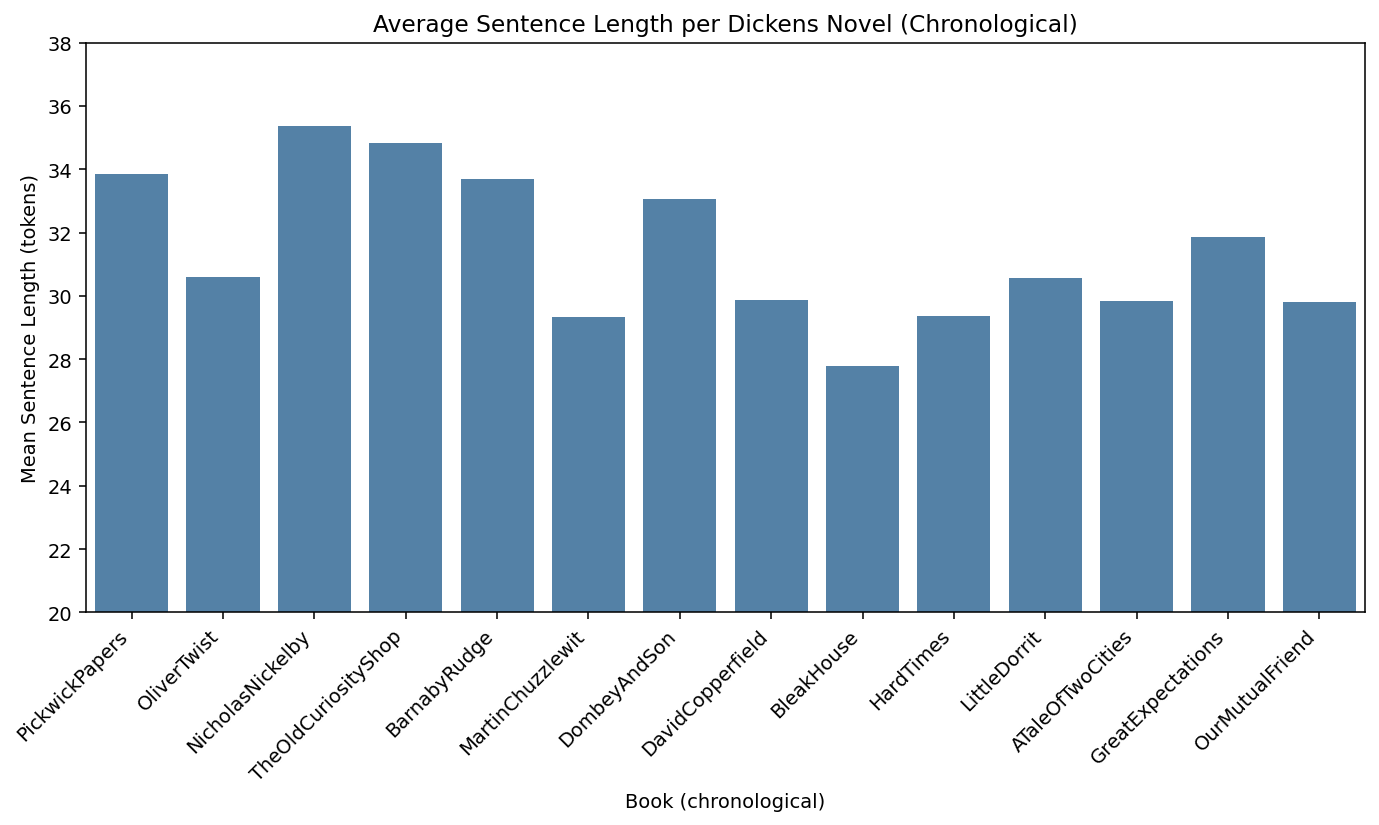

Regression equation: y = -0.3247x + 33.5240
R-squared: 0.3329
P-value: 0.03076
Standard error: 0.1327


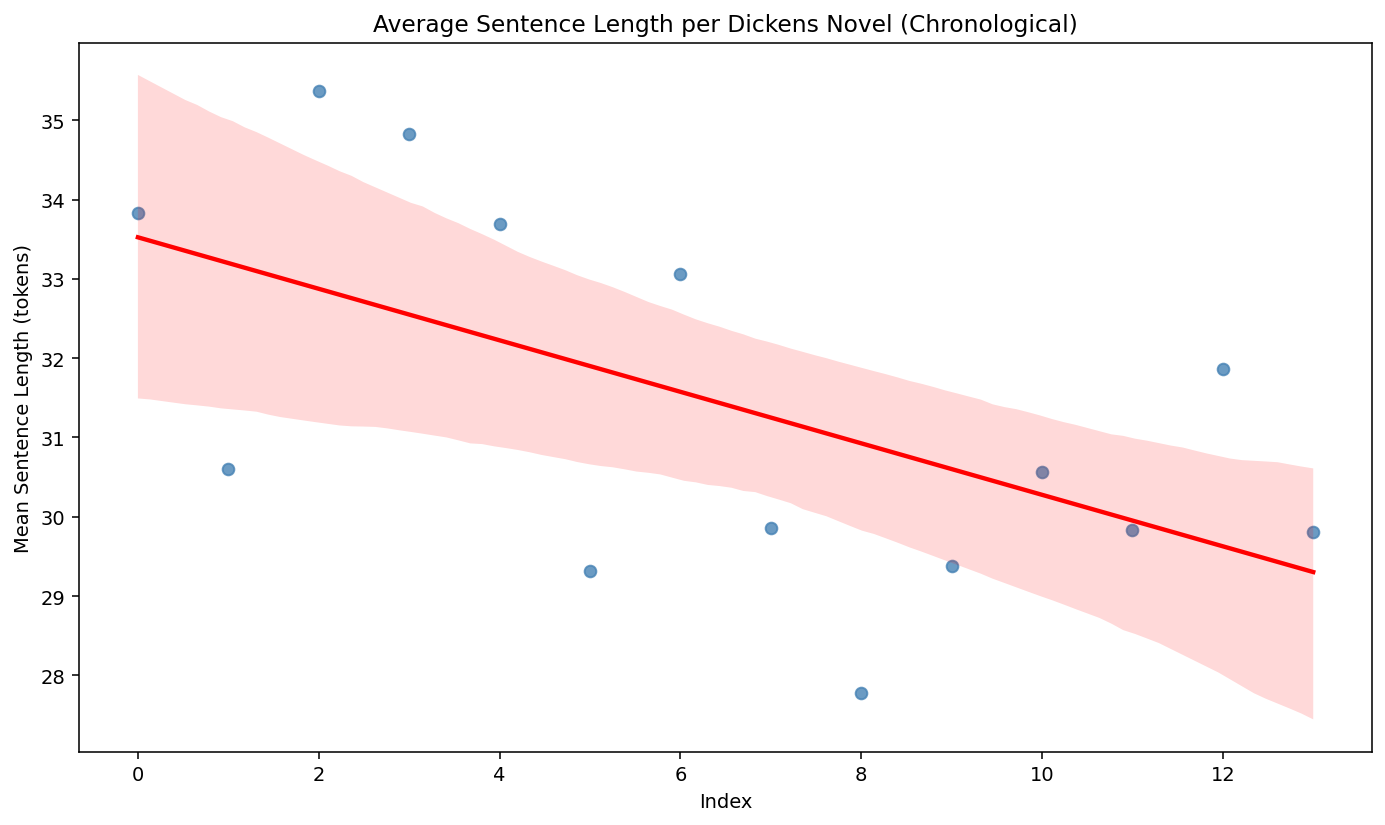

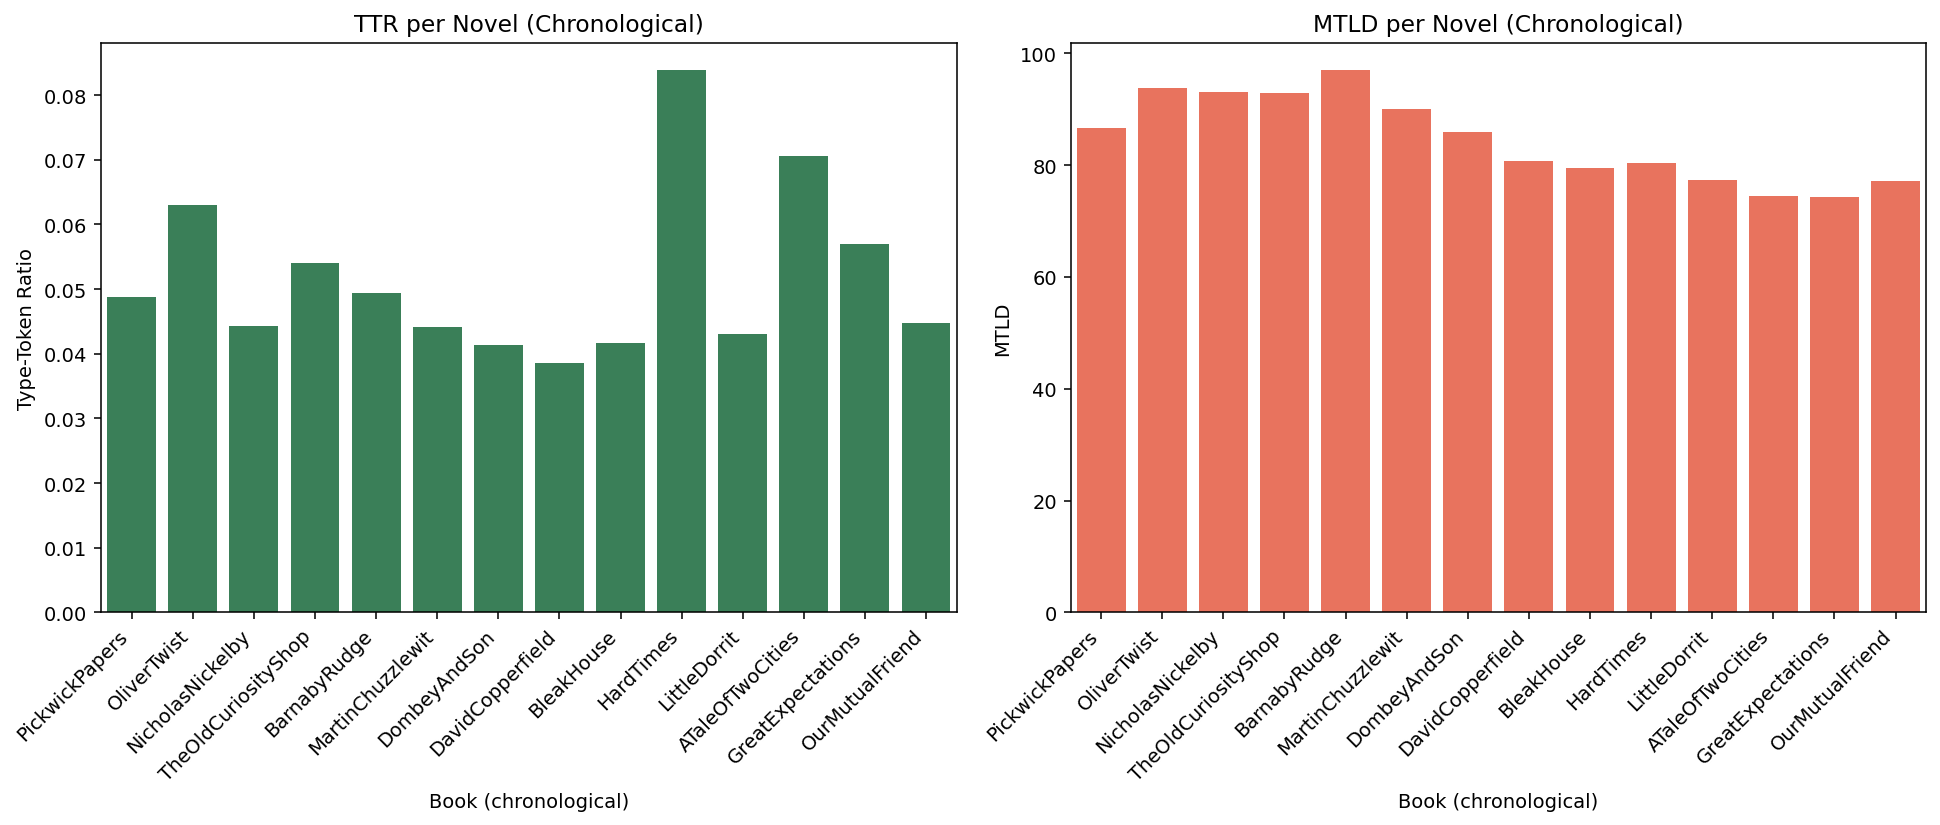

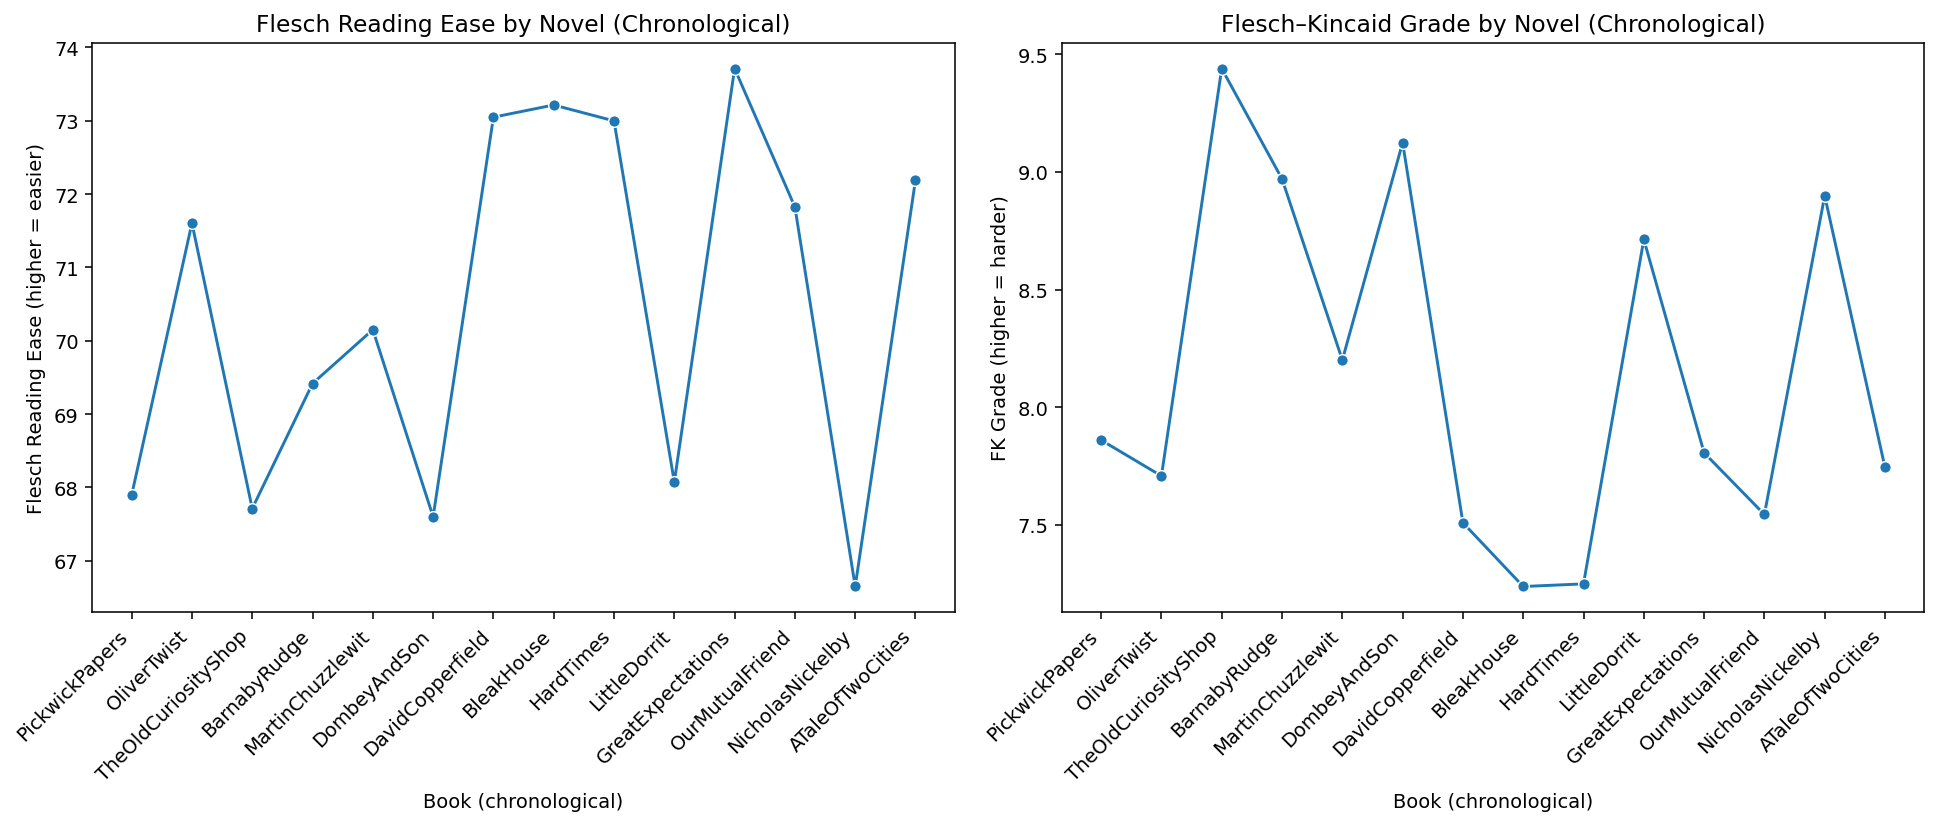

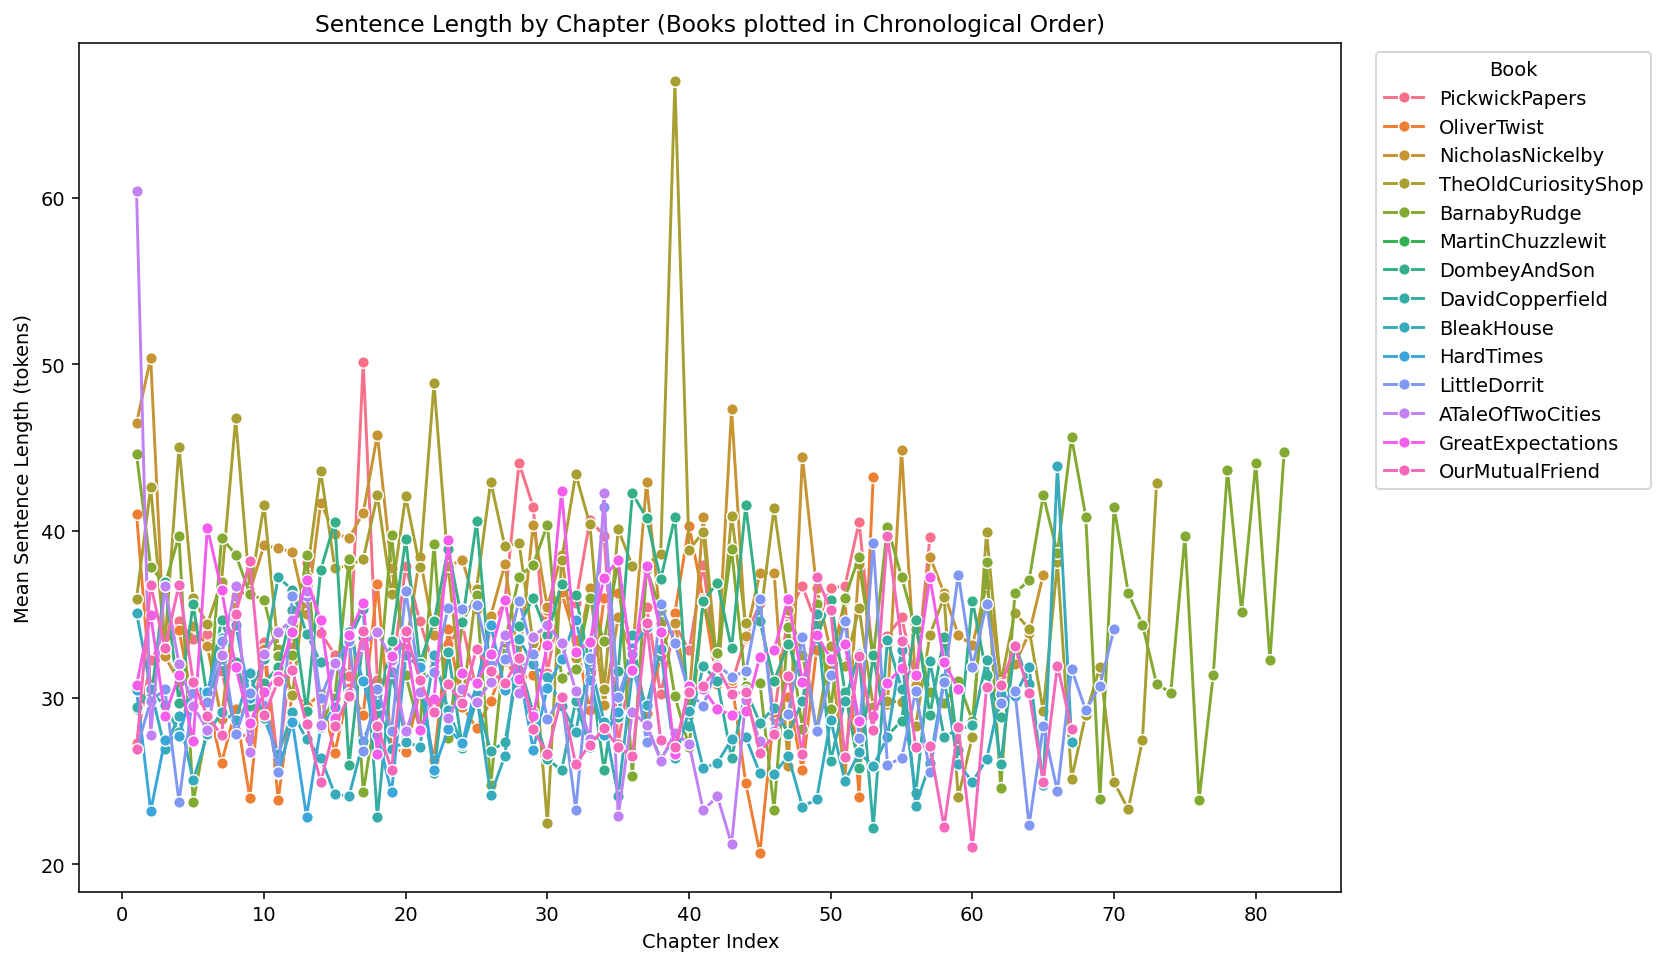

Mean Sentence Length (tokens) vs. Publication Year
  y = -0.119112 * year + 251.462568
  R² = 0.2458 | p = 0.1012 | std_err = 0.065982



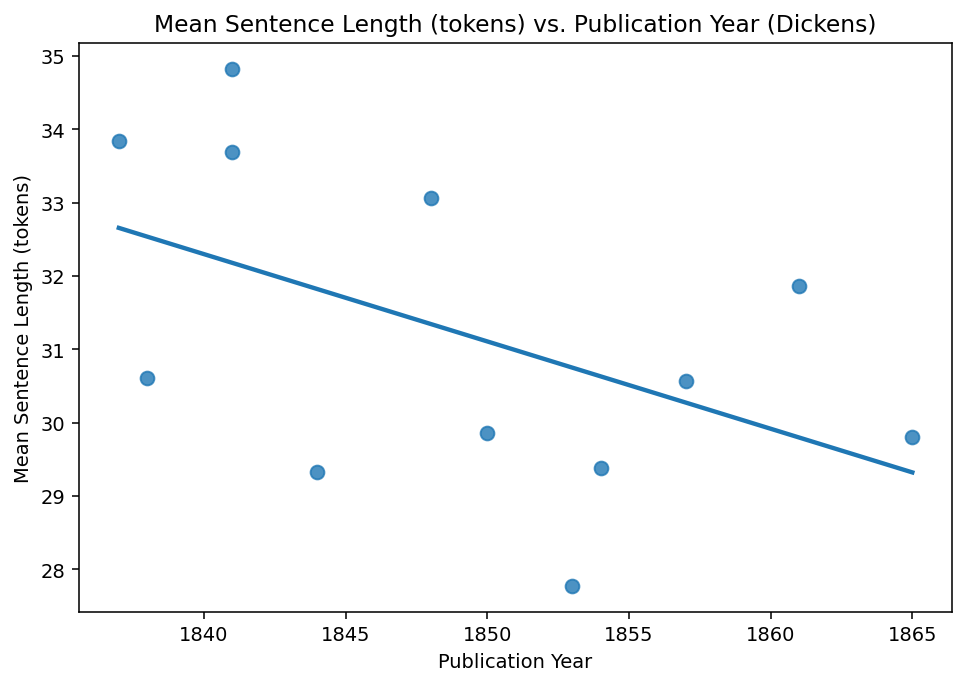

Type-Token Ratio vs. Publication Year
  y = -0.000053 * year + 0.148735
  R² = 0.0015 | p = 0.9057 | std_err = 0.000436



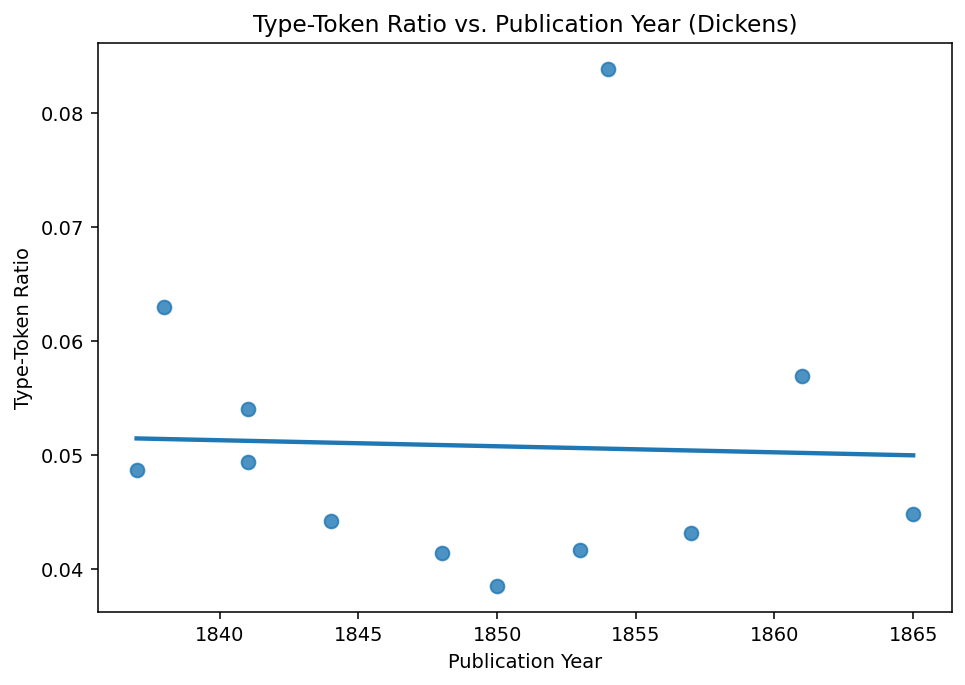

MTLD vs. Publication Year
  y = -0.719633 * year + 1415.289000
  R² = 0.7803 | p = 0.0001393 | std_err = 0.120737



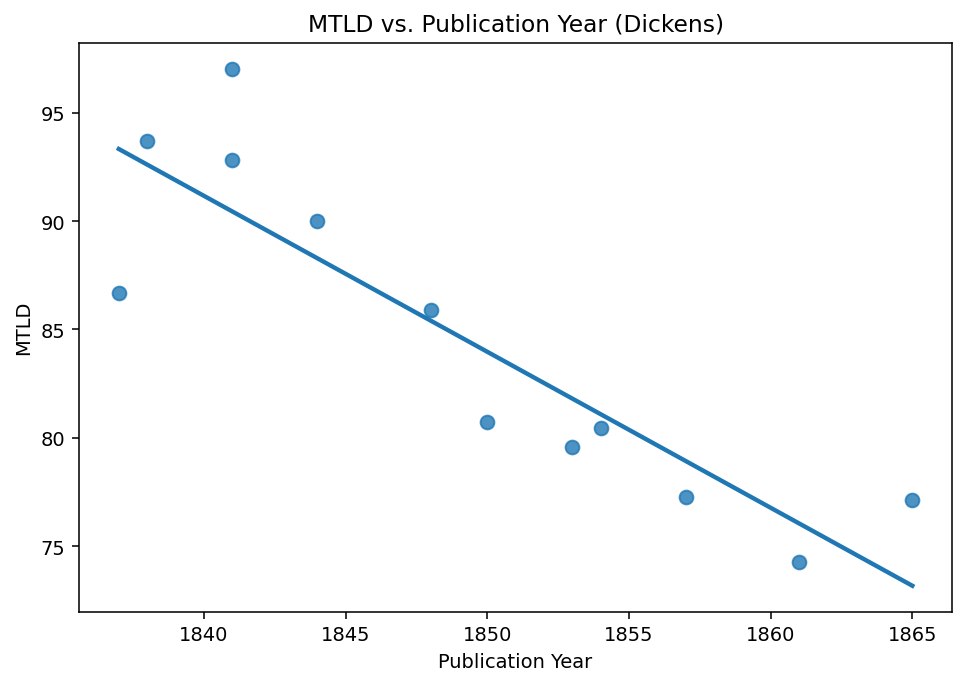

Flesch Reading Ease vs. Publication Year
  y = 0.130653 * year + -170.984484
  R² = 0.2489 | p = 0.09872 | std_err = 0.071775



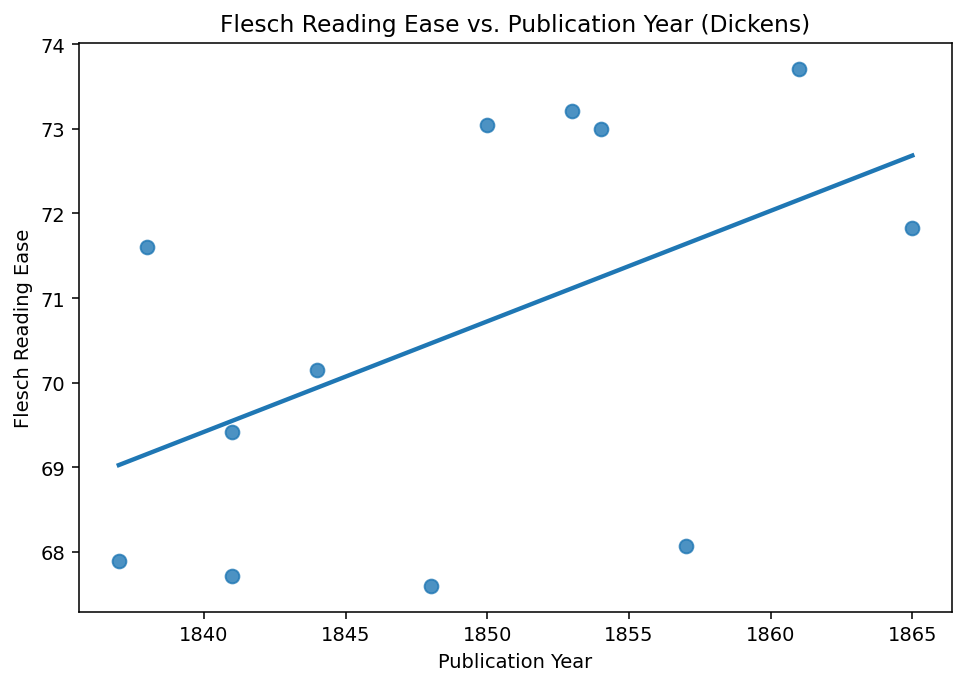

FK Grade vs. Publication Year
  y = -0.030082 * year + 63.736935
  R² = 0.1307 | p = 0.2482 | std_err = 0.024530



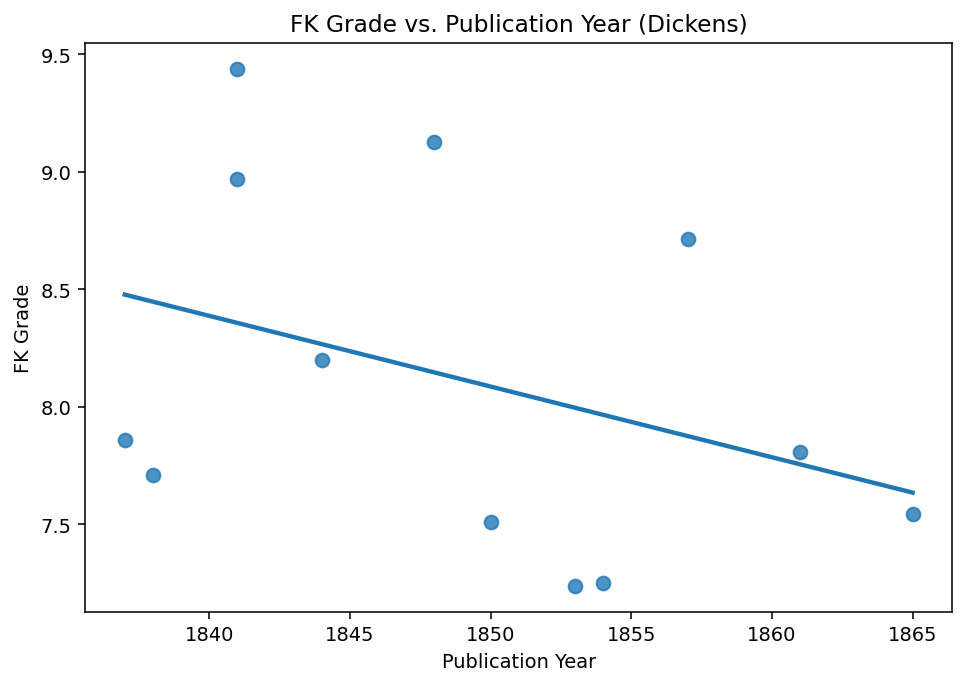

In [5]:
# PART 1 - BASIC ANALYSIS

# Helper function for basic analysis
def rotate_x(ax, rot=45):
    for label in ax.get_xticklabels():
        label.set_rotation(rot)
        label.set_horizontalalignment("right")

# Some helper parameters
plt.rcParams["figure.dpi"] = 140
outdir = Path("plots_dickens_chrono")
outdir.mkdir(parents=True, exist_ok=True)

# Barplot helper function for basic analysis--graphs chronologically
def barplot_by_book(df, y, title, fname, ylabel=None, ymin=None, ymax=None):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df.sort_values("pub_year"),
        x="book_id", y=y,
        order=book_order, color="steelblue"
    )
    rotate_x(ax)
    ax.set_title(title)
    ax.set_xlabel("Book (chronological)")
    ax.set_ylabel(ylabel or y)

    # Set Y-axis limits if provided
    if ymin is not None or ymax is not None:
        ax.set_ylim(ymin, ymax)

    plt.tight_layout()
    #plt.savefig(outdir / fname)
    plt.show()

# Scatterplot helper function for basic analysis--graphs chronologically
def scatterplot_with_regression(df, x, y, title, fname, xlabel=None, ylabel=None, xmin=None, xmax=None, ymin=None, ymax=None):
    # If x is None, use the row index
    if x is None:
        df = df.copy()
        df['__x_index'] = range(len(df))
        x = '__x_index'
        if xlabel is None:
            xlabel = "Index"

    plt.figure(figsize=(10, 6))
    ax = sns.regplot(
        data=df,
        x=x, y=y,
        scatter_kws={"color": "steelblue"},
        line_kws={"color": "red"} )

    ax.set_title(title)
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)

    # Axis limits if provided
    if xmin is not None or xmax is not None:
        ax.set_xlim(xmin, xmax)
    if ymin is not None or ymax is not None:
        ax.set_ylim(ymin, ymax)

    # Calculate regression statistics
    slope, intercept, r_value, p_value, std_err = linregress(df[x], df[y])
    print(f"Regression equation: y = {slope:.4f}x + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"P-value: {p_value:.4g}")
    print(f"Standard error: {std_err:.4f}")

    plt.tight_layout()
    #plt.savefig(outdir / fname)
    plt.show()

# Sentence length over time (barplot)
barplot_by_book(df=df_summary, y="mean_sentence_len_tokens", title="Average Sentence Length per Dickens Novel (Chronological)", 
                fname="01_sentence_length_per_novel.png", ylabel="Mean Sentence Length (tokens)", ymin=20, ymax=38 )

# Sentence length over time (scatterplot)
scatterplot_with_regression(df=df_summary, x=None, y="mean_sentence_len_tokens", title="Average Sentence Length per Dickens Novel (Chronological)",
                            fname="01_sentence_length_per_novel.png", ylabel="Mean Sentence Length (tokens)" )

# Resetting variable for compatibility
df_all = df_chapters

# Graph lexical richness per novel (TTR & MTLD)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.barplot(
    data=df_summary.sort_values("pub_year"),
    x="book_id", y="ttr", order=book_order, color="seagreen", ax=ax[0])
sns.barplot(
    data=df_summary.sort_values("pub_year"),
    x="book_id", y="mtld", order=book_order, color="tomato", ax=ax[1])
for a, ttl, yl in [
    (ax[0], "TTR per Novel (Chronological)", "Type-Token Ratio"),
    (ax[1], "MTLD per Novel (Chronological)", "MTLD"),]:
    a.set_title(ttl)
    a.set_xlabel("Book (chronological)")
    a.set_ylabel(yl)
    rotate_x(a)
plt.tight_layout()
#plt.savefig(outdir / "02_lexical_richness_per_novel.png")
plt.show()

# Graph readabiliy over novels
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.lineplot(
    data=df_summary.sort_values("pub_year"),
    x="book_id", y="flesch_reading_ease", marker="o", ax=ax[0])
sns.lineplot(
    data=df_summary.sort_values("pub_year"),
    x="book_id", y="flesch_kincaid_grade", marker="o", ax=ax[1])
for a, ttl, yl in [
    (ax[0], "Flesch Reading Ease by Novel (Chronological)", "Flesch Reading Ease (higher = easier)"),
    (ax[1], "Flesch–Kincaid Grade by Novel (Chronological)", "FK Grade (higher = harder)"),]:
    a.set_title(ttl)
    a.set_xlabel("Book (chronological)")
    a.set_ylabel(yl)
    rotate_x(a)
plt.tight_layout()
#plt.savefig(outdir / "03_readability_per_novel.png")
plt.show()

# Set chapters only variable for garaphic
chapters_only = df_all[df_all["chapter_index"] > 0].copy()

# Plot sentence length by chapter across books
plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=chapters_only.sort_values(["pub_year","chapter_index"]),
    x="chapter_index", y="mean_sentence_len_tokens",
    hue="book_id", hue_order=book_order, marker="o")
ax.set_title("Sentence Length by Chapter (Books plotted in Chronological Order)")
ax.set_xlabel("Chapter Index")
ax.set_ylabel("Mean Sentence Length (tokens)")
plt.legend(title="Book", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
#plt.savefig(outdir / "05_sentence_length_by_chapter.png")
plt.show()

# Print scatterplots, trendlines, & linear regression info for a few key metrics across publication year
metrics = [
    ("mean_sentence_len_tokens", "Mean Sentence Length (tokens)"),
    ("ttr", "Type-Token Ratio"),
    ("mtld", "MTLD"),
    ("flesch_reading_ease", "Flesch Reading Ease"),
    ("flesch_kincaid_grade", "FK Grade") ]

for col, label in metrics:
    if col not in df_summary.columns:
        continue

    # Drop rows with NaNs for this metric or pub_year
    sub = df_summary[["pub_year", col]].dropna()
    if len(sub) < 2 or sub["pub_year"].nunique() < 2:
        print(f"[skip] Not enough data variation to regress {label} ({col}).")
        continue

    # Store variables
    x = sub["pub_year"].to_numpy()
    y = sub[col].to_numpy()

    # Compute regression for the printed stats
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r2 = r_value ** 2

    # Print regression info
    print(f"{label} vs. Publication Year")
    print(f"  y = {slope:.6f} * year + {intercept:.6f}")
    print(f"  R² = {r2:.4f} | p = {p_value:.4g} | std_err = {std_err:.6f}\n")

    # Plot the graphs
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(
        data=df_summary, x="pub_year", y=col,
        scatter_kws={"s": 50, "alpha": 0.8}, ci=None )
    ax.set_title(f"{label} vs. Publication Year (Dickens)")
    ax.set_xlabel("Publication Year")
    ax.set_ylabel(label)
    plt.tight_layout()
    #plt.savefig(outdir / f"06_trend_{col}.png")
    plt.show()

#print(f"All plots saved to: {outdir.resolve()}")


In [6]:
# PART 2.1 - PARTS-OF-SPEECH HELPER FUNCTIONS

# Identify POS columns
def detect_pos_columns(df):
    # Get a list of all column names in the dataframe
    all_cols = df.columns.tolist()

    # Identify proportion columns (must have '_prop_' in the name and start with either 'pos_univ_' or 'pos_penn_')
    prop_cols = [c for c in all_cols if "_prop_" in c and (c.startswith("pos_univ_") or c.startswith("pos_penn_"))]

    # Identify raw count columns (start with 'pos_univ_' or 'pos_penn_')
    raw_cols  = [c for c in all_cols if c.startswith("pos_univ_") or c.startswith("pos_penn_")]

    # Exclude any that are actually proportion columns
    raw_cols  = [c for c in raw_cols if c not in prop_cols]

    # Remove columns that are clearly not POS counts, such as metadata
    raw_cols = [c for c in raw_cols if c not in ("sample_sentences", "pub_year")]

    # Return two lists: raw POS count columns, and proportion POS columns
    return raw_cols, prop_cols


# Compute proportions if not present
def ensure_proportions(df):
    # Identify raw and proportion columns
    raw_cols, prop_cols = detect_pos_columns(df)

    # If proportion columns already exist, nothing to compute
    if prop_cols:
        return df, prop_cols  

    # Else compute proportions from raw counts, & normalize counts separately for each POS tagset (universal vs penn)
    univ_raw = [c for c in raw_cols if c.startswith("pos_univ_")]
    penn_raw = [c for c in raw_cols if c.startswith("pos_penn_")]

    # Work on a copy to avoid modifying original dataframe in place
    df = df.copy()  

    if univ_raw:
        # Sum all universal POS counts for each row
        total = df[univ_raw].sum(axis=1).replace(0, np.nan)  # Avoid division by zero
        # Create proportion columns for each universal POS tag
        for c in univ_raw:
            df[c.replace("pos_univ_", "pos_univ_prop_")] = df[c] / total

    if penn_raw:
        # Sum all Penn POS counts for each row
        total = df[penn_raw].sum(axis=1).replace(0, np.nan)
        # Create proportion columns for each Penn POS tag
        for c in penn_raw:
            df[c.replace("pos_penn_", "pos_penn_prop_")] = df[c] / total

    # After computing, re-run detection to capture the newly added proportion columns
    _, prop_cols = detect_pos_columns(df)
    return df, prop_cols


# Tidy/long format for plotting
def melt_props(df, id_cols):
    # Detect proportion columns for melting
    _, prop_cols = detect_pos_columns(df)

    # Melt dataframe: each row becomes (id_vars, feature, prop)
    data_long = df.melt(id_vars=id_cols,         # Keep these columns fixed
                        value_vars=prop_cols,    # Columns to unpivot
                        var_name="feature",      # New column name for original column names
                        value_name="prop" )      # New column name for values

    # Add a column indicating whether the feature belongs to universal or Penn tagset
    data_long["tagset"] = np.where(data_long["feature"].str.startswith("pos_univ_prop_"), "universal", "penn" )

    # Extract just the tag name (such as 'NOUN', 'VB') from the feature name
    data_long["tag"] = data_long["feature"].str.replace(
        r"^pos_(univ|penn)_prop_", "", 
        regex=True
    )
    return data_long


# Basic checks / sorting
if "pub_year" not in novels.columns:
    raise ValueError("novels.csv must include a 'pub_year' column.")

# Sort novels chronologically by publication year
novels = novels.sort_values(["pub_year"]).reset_index(drop=True)

if "novel" not in chapters.columns:
    raise ValueError("chapters.csv must include a 'novel' column.")

# If no explicit chapter number, generate one based on order within each novel
if "chapter" not in chapters.columns:
    chapters = chapters.copy()
    chapters["chapter"] = chapters.groupby("novel").cumcount() + 1

# Ensure proportion columns exist for both datasets
novels, novels_prop_cols = ensure_proportions(novels)
chapters, chapters_prop_cols = ensure_proportions(chapters)


title  pub_year             feature   tag      prop
0  Novel_1      1837  pos_univ_prop_NOUN  NOUN  0.255120
1  Novel_1      1837  pos_univ_prop_VERB  VERB  0.196272
2  Novel_1      1837   pos_univ_prop_ADP   ADP  0.120936
3  Novel_1      1837   pos_univ_prop_DET   DET  0.119139
4  Novel_1      1837  pos_univ_prop_PRON  PRON  0.099873
5  Novel_2      1838  pos_univ_prop_NOUN  NOUN  0.225742
6  Novel_2      1838  pos_univ_prop_VERB  VERB  0.206991
7  Novel_2      1838   pos_univ_prop_ADP   ADP  0.124195
8  Novel_2      1838   pos_univ_prop_DET   DET  0.119623
9  Novel_2      1838  pos_univ_prop_PRON  PRON  0.112074

title  pub_year            feature  tag      prop
0  Novel_1      1837   pos_penn_prop_NN   NN  0.154290
1  Novel_1      1837   pos_penn_prop_IN   IN  0.120936
2  Novel_1      1837   pos_penn_prop_DT   DT  0.108242
3  Novel_1      1837  pos_penn_prop_VBD  VBD  0.072311
4  Novel_1      1837   pos_penn_prop_JJ   JJ  0.070660
5  Novel_2      1838   pos_penn_prop_NN   NN  0.146070
6  Novel_2      1838   pos_penn_prop_IN   IN  0.124195
7  Novel_2      1838   pos_penn_prop_DT   DT  0.107907
8  Novel_2      1838  pos_penn_prop_PRP  PRP  0.076919
9  Novel_2      1838  pos_penn_prop_VBD  VBD  0.074379

Universal tags (12): ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
Penn tags (36): ['$', "''", 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


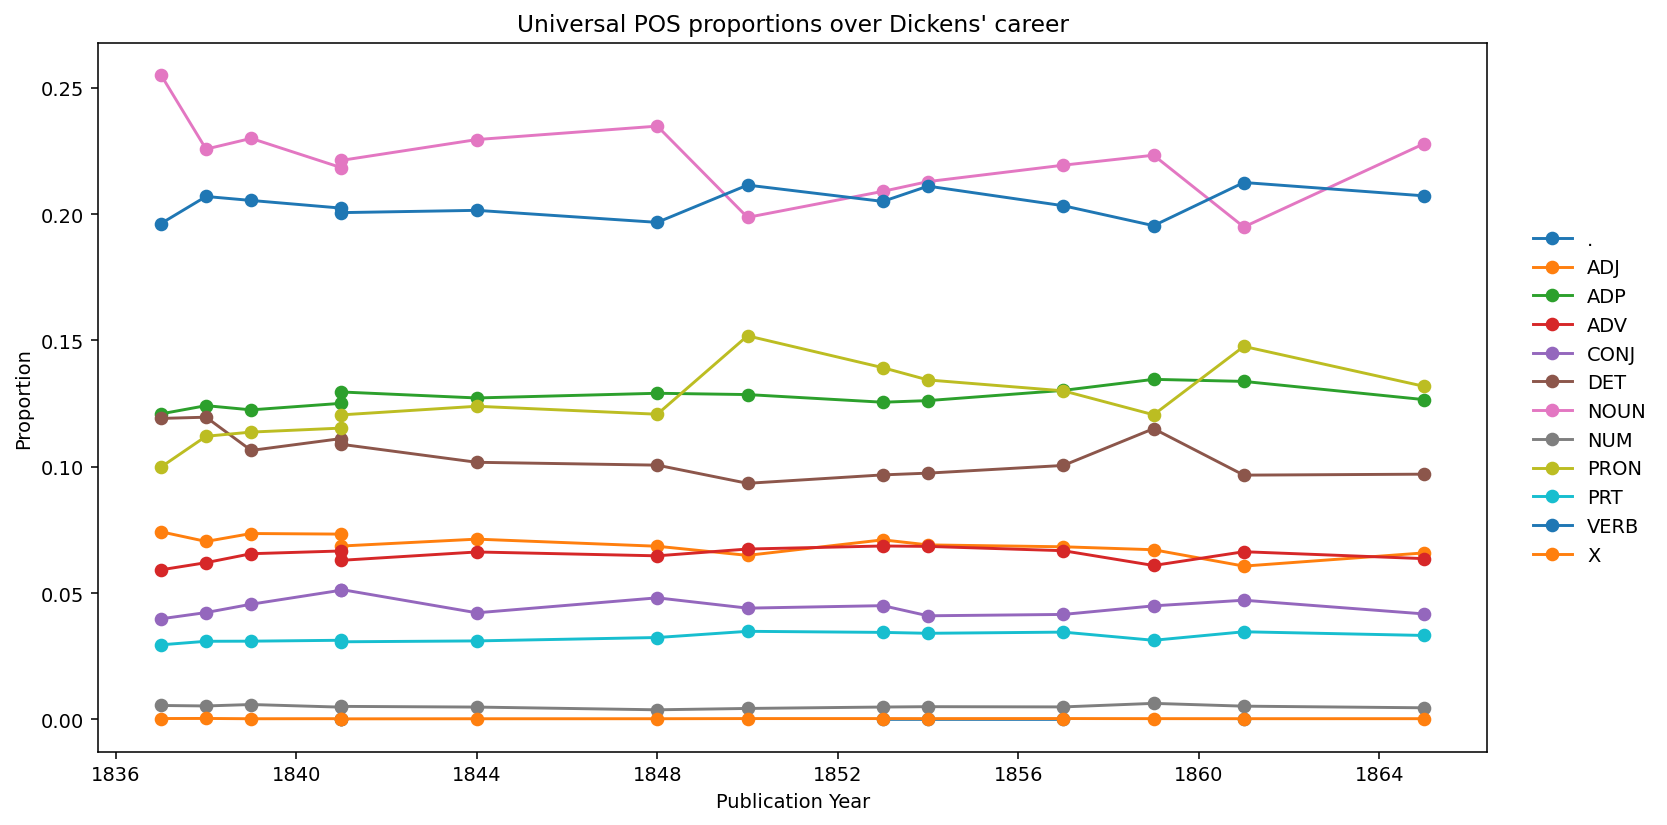

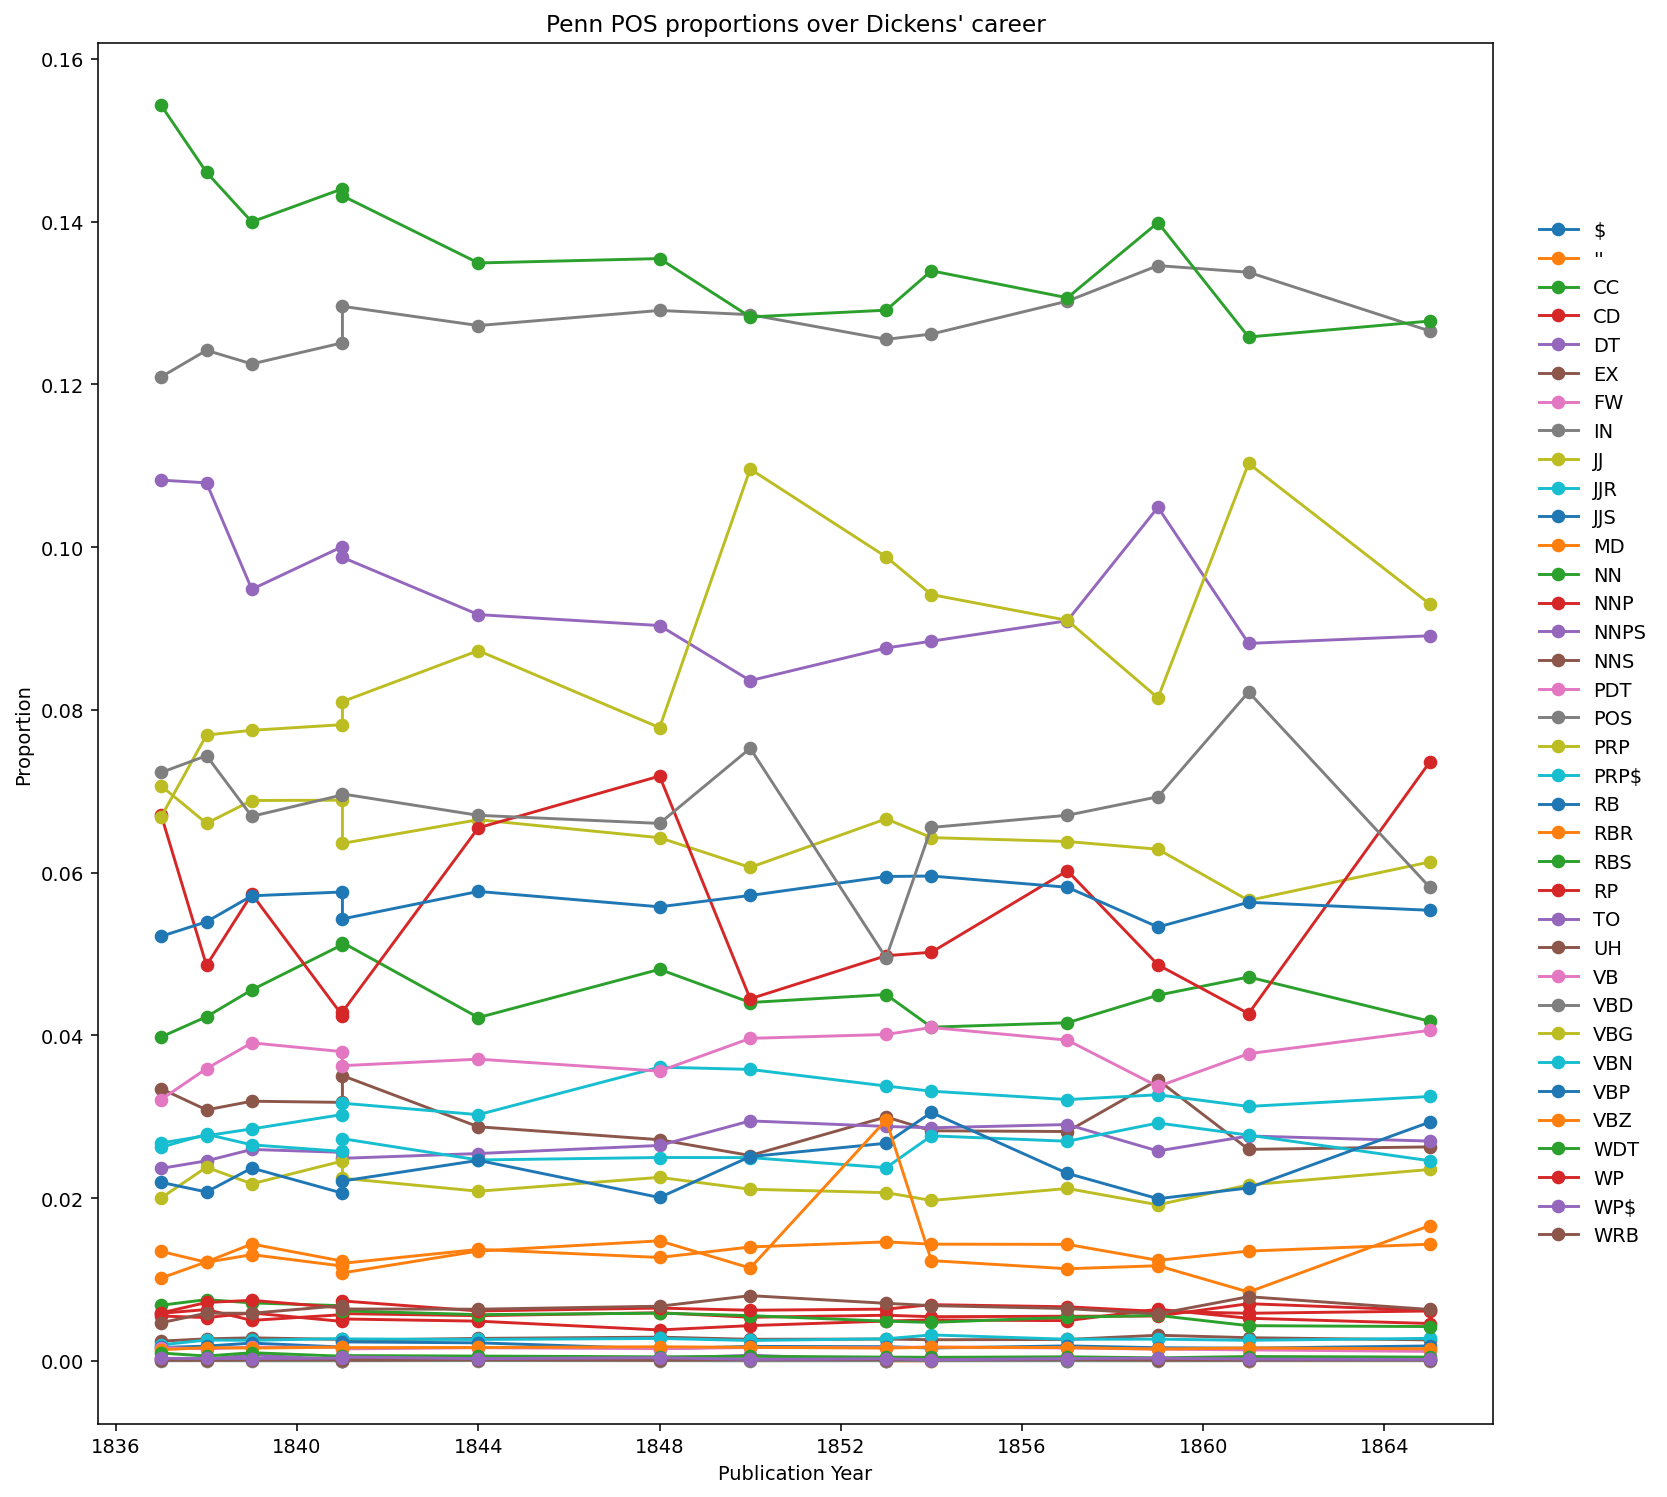

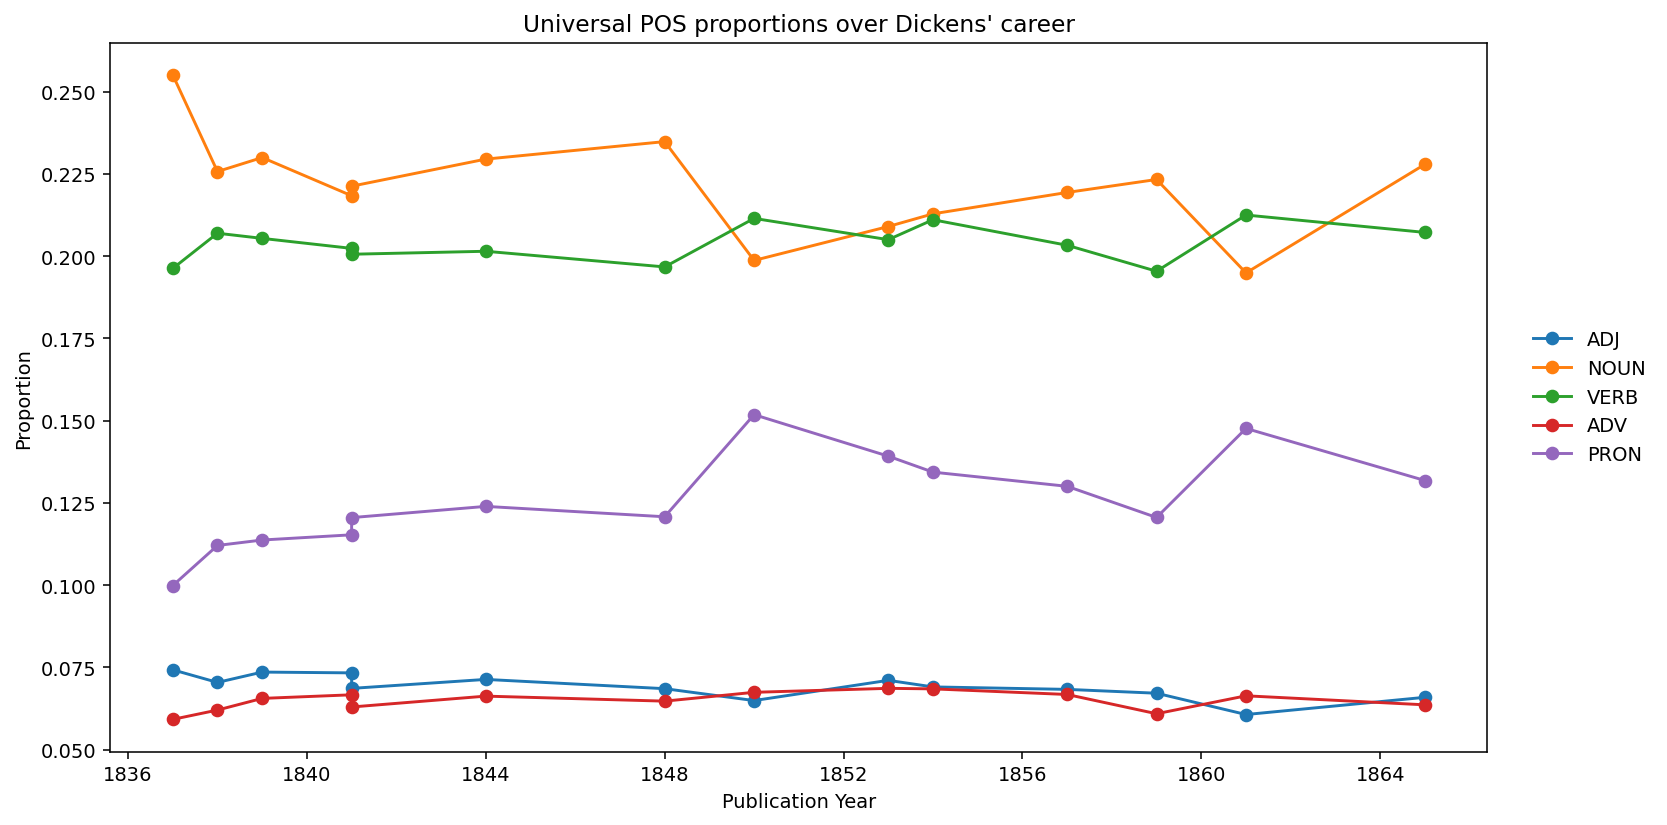

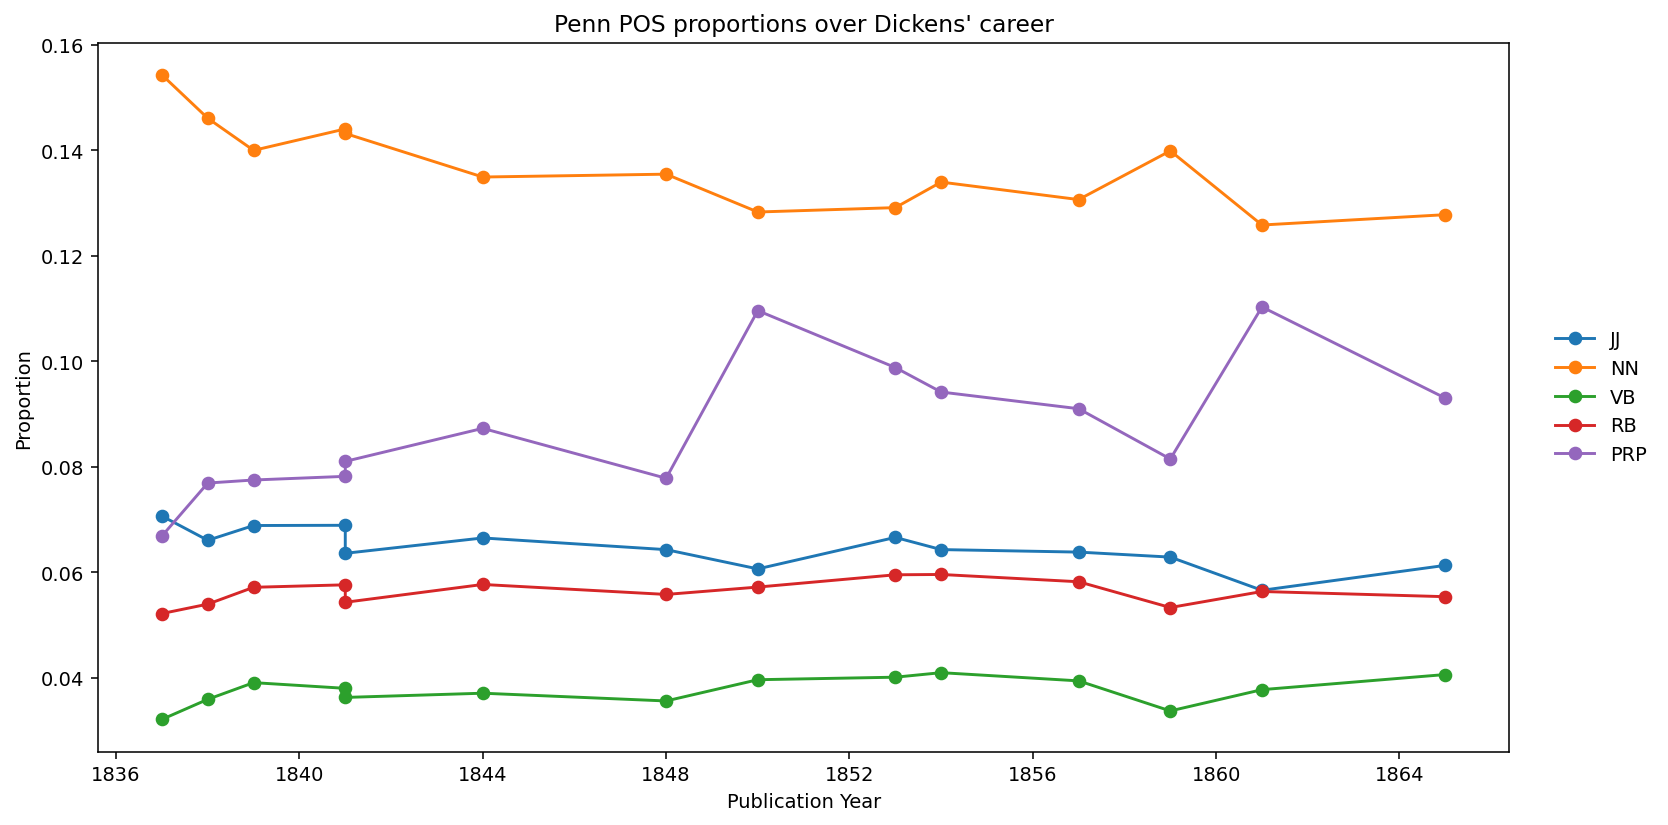

In [7]:
# PART 2.2 - NOVEL-LEVEL DESCRIPTIVE STATISTICS FOR PARTS OF SPEECH

# Identify the top POS tags by mean proportion for each novel
def top_pos_per_novel(df, k=5, tagset="universal"):
    # tagset must be either "universal" or "penn"
    assert tagset in ("universal", "penn")

    # Select only proportion columns matching the chosen tagset
    cols = [c for c in df.columns if c.startswith(f"pos_{'univ' if tagset=='universal' else 'penn'}_prop_")]

    out = []
    # Loop through each row (aka each novel)
    for i, row in df.iterrows():
        vec = row[cols]  # Vector of POS proportions for that novel
        
        # Sort tags in descending order and take the top k
        topk = vec.sort_values(ascending=False).head(k)
        for feature, val in topk.items():
            out.append({"title": row.get("title", f"Novel_{i+1}"),          # Use title if available
                        "pub_year": row.get("pub_year", np.nan),            # Publication year (if available)
                        "feature": feature,                                 # Full column name
                        "tag": feature.split("_prop_")[-1],                 # POS tag only (strip prefix)
                        "prop": val  })                                     # Proportion value   
    # Return as a tidy dataframe
    return pd.DataFrame(out)

# Compute top-k POS tags for each novel (Universal & Penn separately)
top_univ = top_pos_per_novel(novels, k=5, tagset="universal")
top_penn = top_pos_per_novel(novels, k=5, tagset="penn")

# Quick inspection of results
display(top_univ.head(10))
display(top_penn.head(10))

# Full Univ & Penn tagsets
FULL_UNIV = sorted([col.replace("pos_univ_prop_", "") for col in novels.columns if col.startswith("pos_univ_prop_")])
FULL_PENN = sorted([col.replace("pos_penn_prop_", "") for col in novels.columns if col.startswith("pos_penn_prop_")])

print(f"Universal tags ({len(FULL_UNIV)}): {FULL_UNIV}")
print(f"Penn tags ({len(FULL_PENN)}): {FULL_PENN}")

# Selected Univ and Penn tagsets for convenience for soem plots
SELECT_UNIV = ["ADJ","NOUN","VERB","ADV","PRON"]
SELECT_PENN = ["JJ","NN","VB","RB","PRP"]

# Function to plot time series
def plot_time_series(df, tags, tagset, title, fname):
    assert tagset in ("univ","penn")
    
    # Dynamic figure size — make it wider and taller for many tags
    width = 12  # wider plot for better line separation
    height = max(6, len(tags) * 0.3)  # scale height based on number of tags
    plt.figure(figsize=(width, height))
    
    x = df["pub_year"].values
    for t in tags:
        col = f"pos_{tagset}_prop_{t}"
        if col in df.columns:
            plt.plot(x, df[col], marker="o", label=t)
    
    plt.xlabel("Publication Year")
    plt.ylabel("Proportion")
    plt.title(title)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Vertical legend on the right to save horizontal space
    plt.legend(
        frameon=False,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),  # place legend just outside plot area
        ncol=1   )                    # vertical list (1 column)
    
    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, fname), dpi=150, bbox_inches="tight")
    plt.show()

# Plot Universal and Penn POS time series -- all tags
plot_time_series(novels, FULL_UNIV, "univ", "Universal POS proportions over Dickens' career", "novels_univ_timeseries.png")
plot_time_series(novels, FULL_PENN, "penn", "Penn POS proportions over Dickens' career", "novels_penn_timeseries.png")

# Plot Universal and Penn POS time series -- selected tags
plot_time_series(novels, SELECT_UNIV, "univ", "Universal POS proportions over Dickens' career", "novels_univ_timeseries.png")
plot_time_series(novels, SELECT_PENN, "penn", "Penn POS proportions over Dickens' career", "novels_penn_timeseries.png")



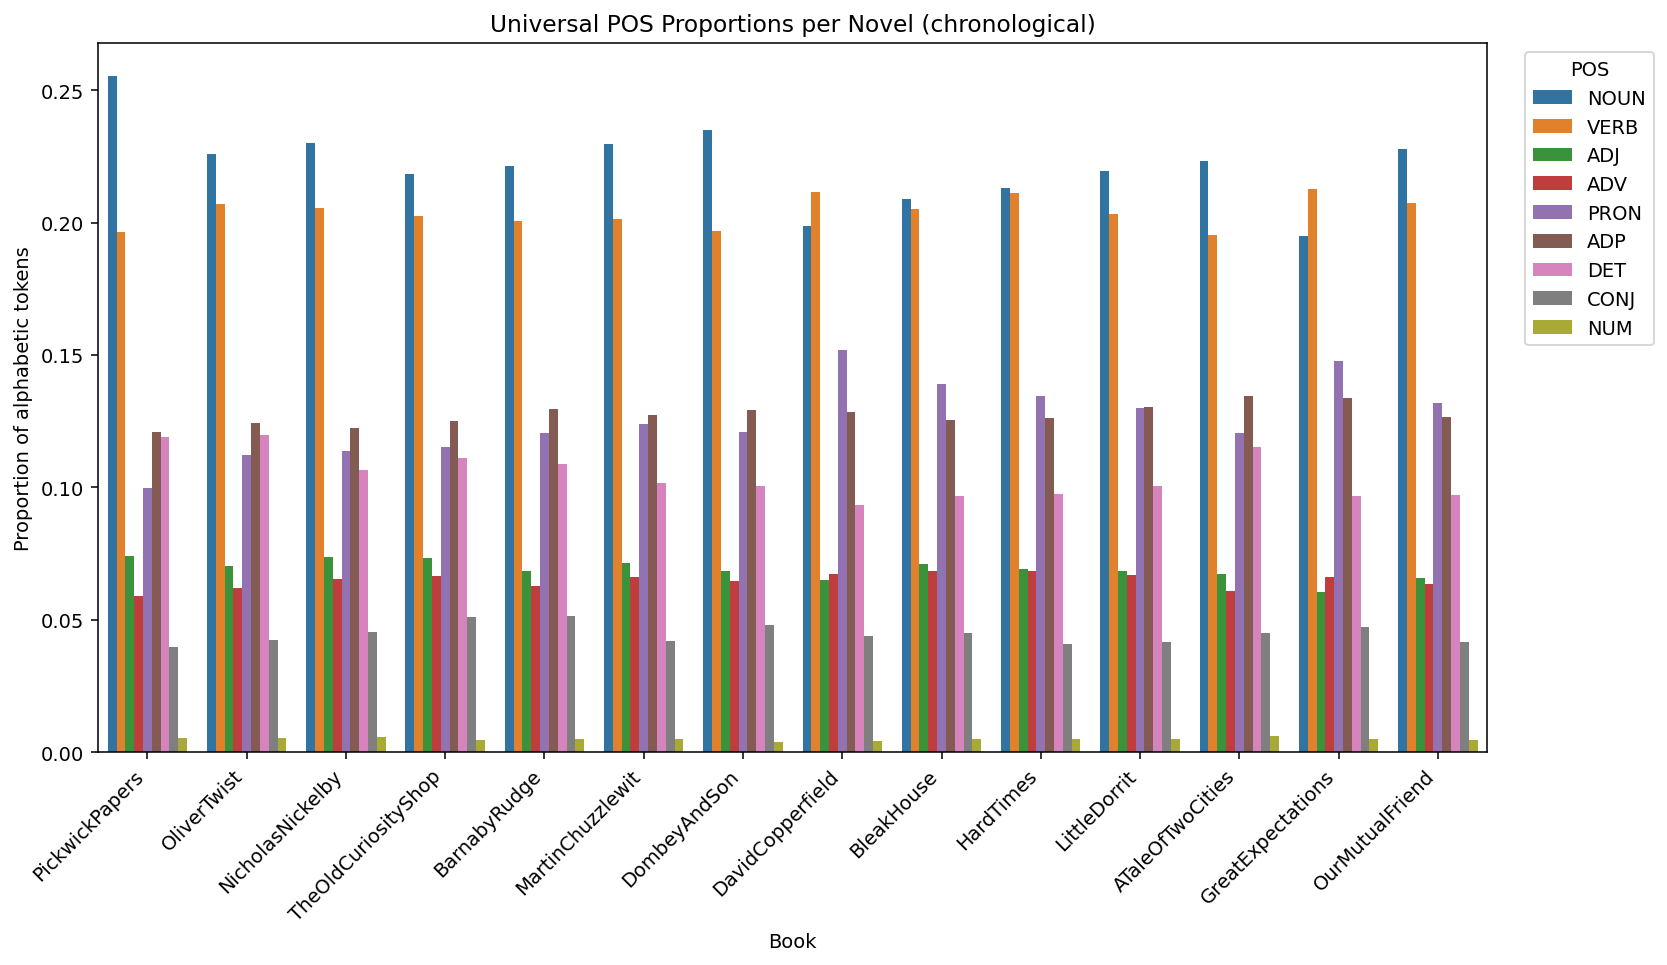

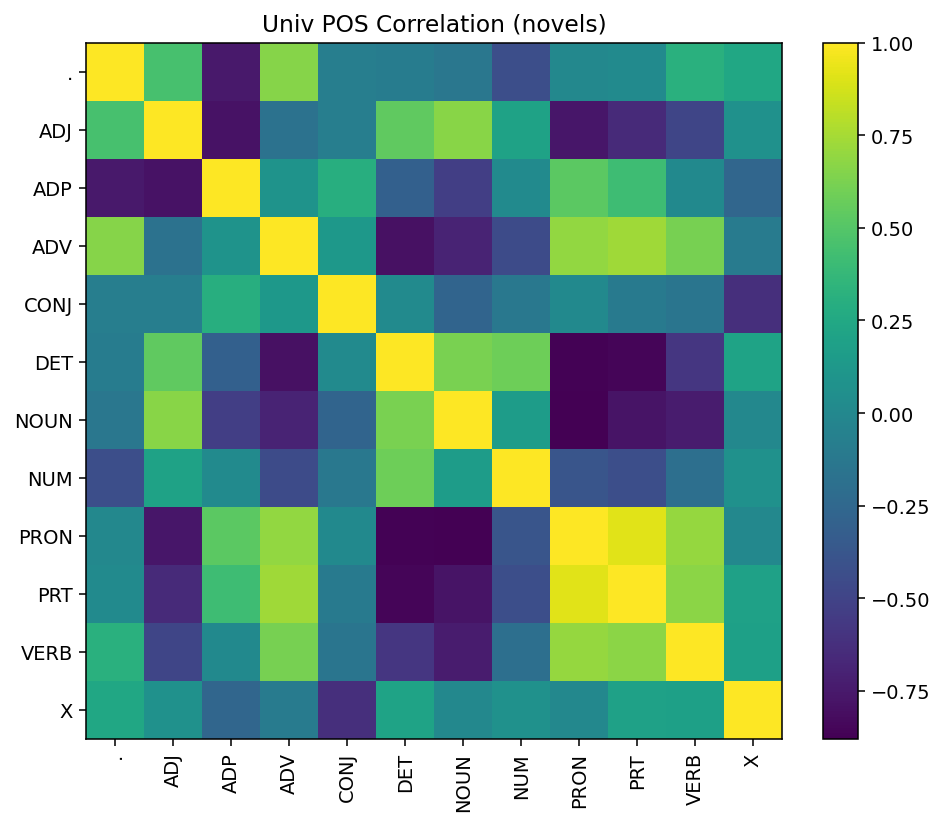

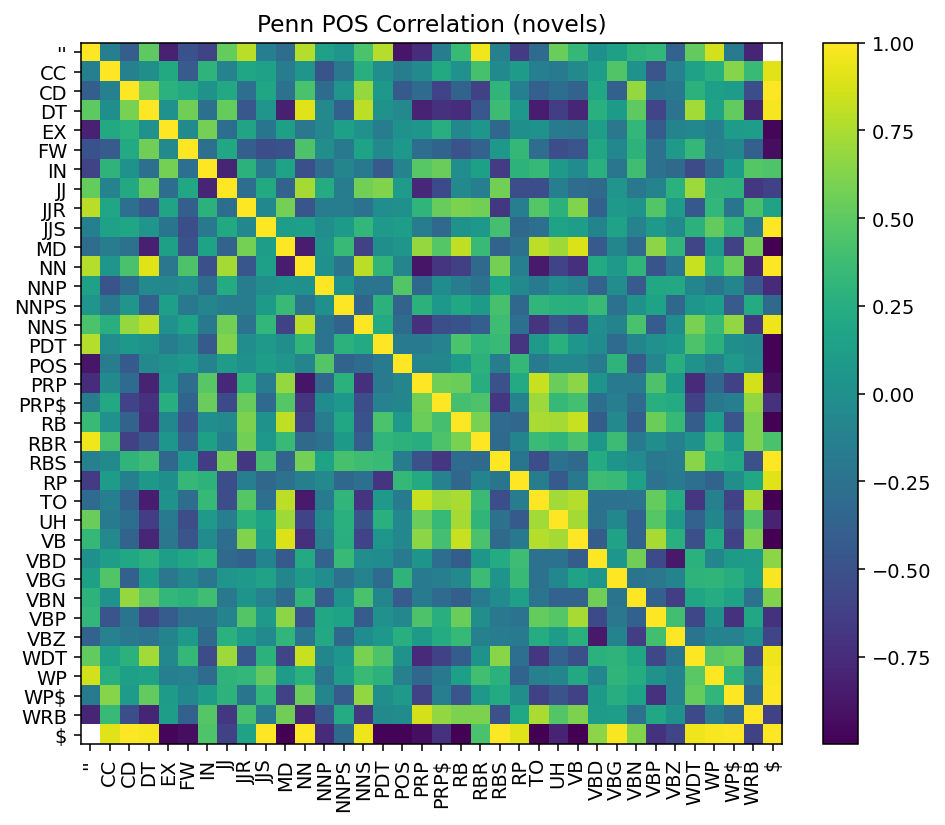

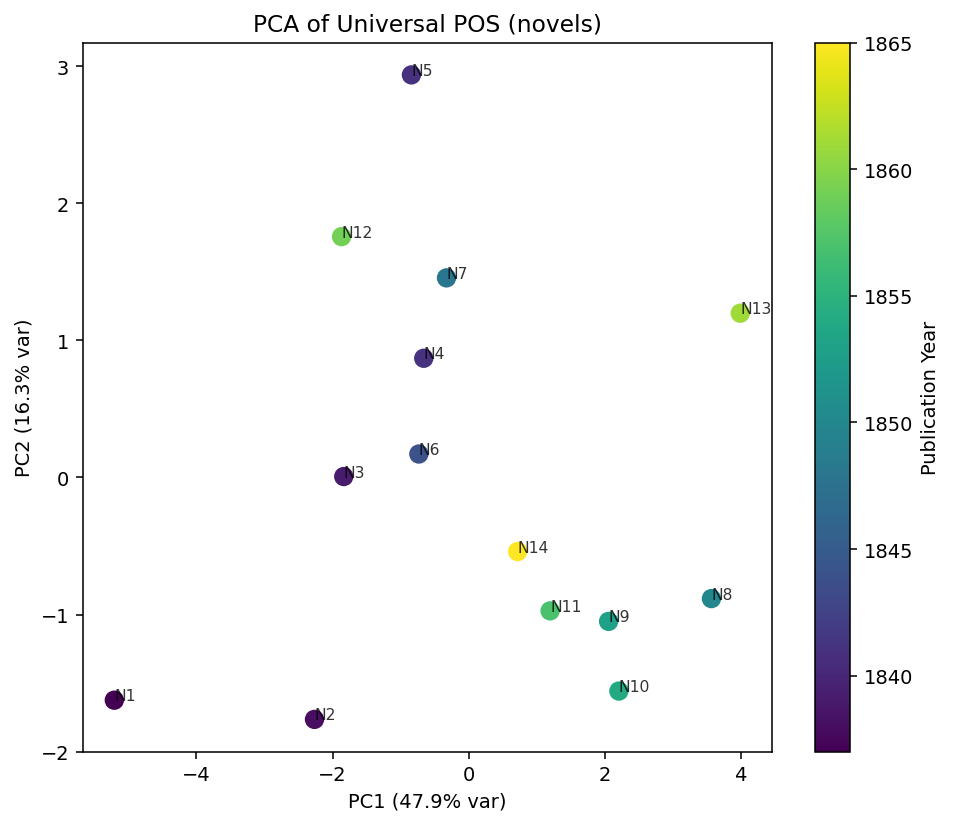

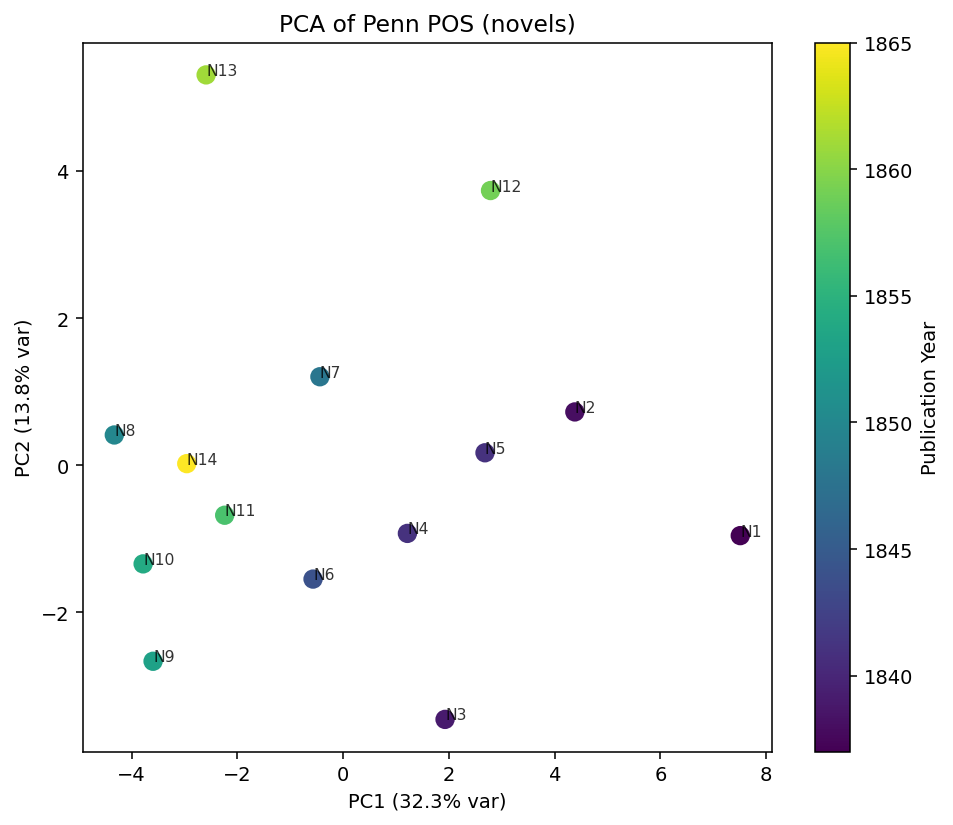

feature  slope_per_year   p_value
1    pos_univ_prop_ADJ       -0.000299  0.002006
9    pos_univ_prop_PRT        0.000142  0.003246
8   pos_univ_prop_PRON        0.001054  0.006842
2    pos_univ_prop_ADP        0.000273  0.011302
5    pos_univ_prop_DET       -0.000576  0.020801
6   pos_univ_prop_NOUN       -0.000793  0.076936
10  pos_univ_prop_VERB        0.000192  0.267600
3    pos_univ_prop_ADV        0.000085  0.339861
4   pos_univ_prop_CONJ       -0.000070  0.545587
7    pos_univ_prop_NUM       -0.000007  0.704934

feature  slope_per_year   p_value
31   pos_penn_prop_WDT       -0.000100  0.000010
11    pos_penn_prop_NN       -0.000702  0.000783
7     pos_penn_prop_JJ       -0.000299  0.001963
21   pos_penn_prop_RBS       -0.000014  0.004431
17   pos_penn_prop_PRP        0.000917  0.009032
6     pos_penn_prop_IN        0.000273  0.011302
23    pos_penn_prop_TO        0.000127  0.012265
15   pos_penn_prop_PDT       -0.000009  0.033521
18  pos_penn_prop_PRP$        0.000169  0.033554
3     pos_penn_prop_DT       -0.000472  0.042337

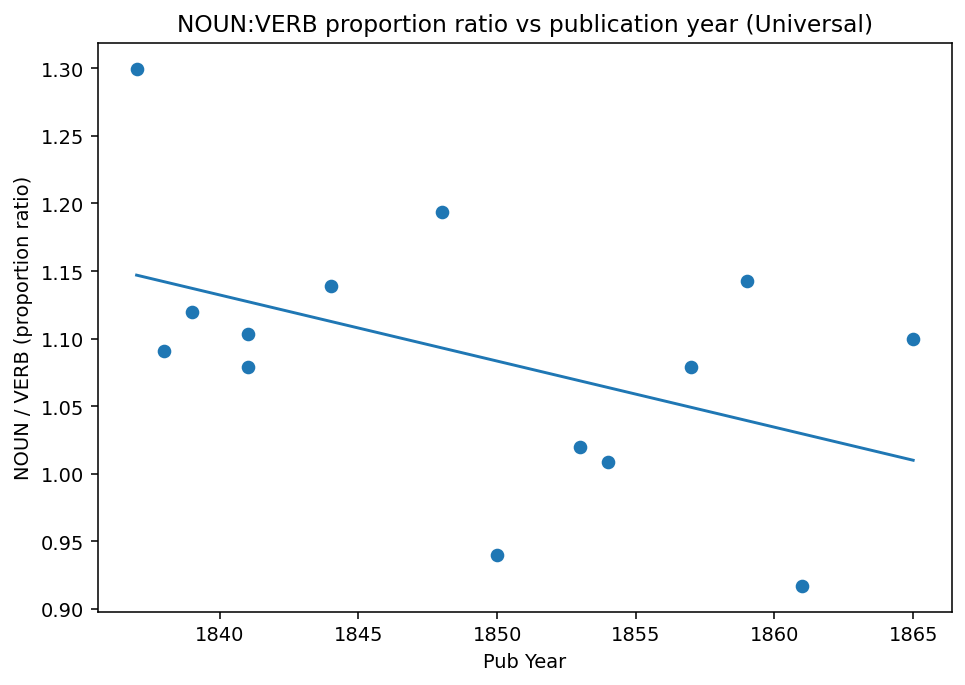

NOUN:VERB proportion ratio vs publication year (Universal)
  slope/year = -0.0049 | p = 0.09524 | R² = 0.215



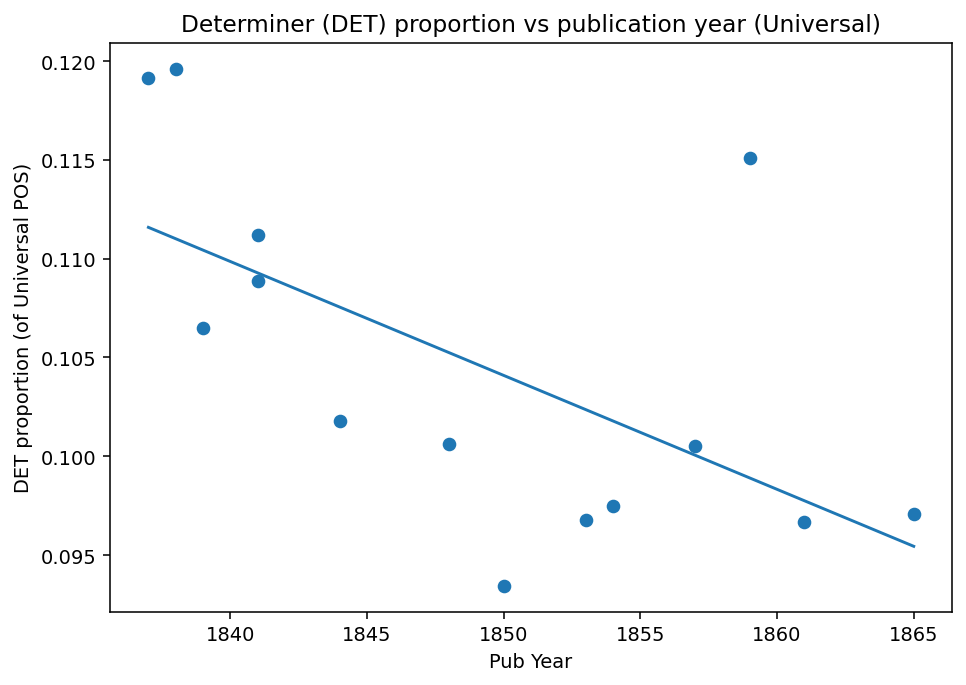

Determiner (DET) proportion vs publication year (Universal)
  slope/year = -0.0006 | p = 0.0208 | R² = 0.371



In [8]:
# PART 2.3 - NOVEL-LEVEL DESCRIPTIVE STATISTICS FOR PARTS OF SPEECH, CONTINUED

# Identify Universal POS columns (counts & props)
# Done to be compatible with code that was originally in a different document
pos_univ_count_cols = sorted([c for c in df_summary_v2.columns if c.startswith("pos_univ_") and not c.startswith("pos_univ_prop_")])
pos_univ_prop_cols  = sorted([c for c in df_summary_v2.columns if c.startswith("pos_univ_prop_")])

# Additionally set this to be compatible with previous code
ordered_books = df_summary_v2["book_id"].tolist()

# Selected tags to plot (all Universal tags)
wanted_tags = ["NOUN","VERB","ADJ","ADV","PRON","ADP","DET","CONJ","ADJ","NUM"]
wanted_prop_cols = [f"pos_univ_prop_{t}" for t in wanted_tags if f"pos_univ_prop_{t}" in df_summary_v2.columns]

# Bar graph with proportions of selected tags per novel
if wanted_prop_cols:
    df_pos = df_summary_v2[["book_id","pub_year"] + wanted_prop_cols].sort_values("pub_year").copy()
    m = df_pos.melt(id_vars=["book_id","pub_year"], var_name="tag_col", value_name="prop")
    m["tag"] = m["tag_col"].str.replace("^pos_univ_prop_", "", regex=True)
    plt.figure(figsize=(12,7))
    ax = sns.barplot(data=m, x="book_id", y="prop", hue="tag", order=ordered_books)
    ax.set_title("Universal POS Proportions per Novel (chronological)")
    ax.set_xlabel("Book"); ax.set_ylabel("Proportion of alphabetic tokens")
    plt.legend(title="POS", bbox_to_anchor=(1.02,1), loc="upper left")
    for lbl in ax.get_xticklabels(): lbl.set_rotation(45); lbl.set_horizontalalignment("right")
    plt.tight_layout()
    plt.show()

# Correlation heatmap of POS proportions (novel-level)
def correlation_heatmap(df, tagset, fname):
    # Get all POS proportion columns for given tagset
    cols = [c for c in df.columns if c.startswith(f"pos_{tagset}_prop_")]
    corr = df[cols].corr()  # Compute correlation matrix

    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)  # Colorbar for correlation scale

    # Axis labels = POS tag names (no prefix)
    plt.xticks(range(len(cols)), [c.replace(f"pos_{tagset}_prop_", "") for c in cols], rotation=90)
    plt.yticks(range(len(cols)), [c.replace(f"pos_{tagset}_prop_", "") for c in cols])

    plt.title(f"{tagset.capitalize()} POS Correlation (novels)")
    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, f"corr_{tagset}_novels.png"), dpi=150)
    plt.show()

# Generate correlation heatmaps for Universal & Penn
correlation_heatmap(novels, "univ", "corr_univ_novels.png")
correlation_heatmap(novels, "penn", "corr_penn_novels.png")

# PCA on POS proportions to visualize stylistic space
def pca_plot(df, tagset, title, fname):
    # Extract proportion columns for the given tagset
    cols = [c for c in df.columns if c.startswith(f"pos_{tagset}_prop_")]
    X = df[cols].fillna(0.0).values  # Replace NaN with 0

    # Standardize features before PCA
    X_scaled = StandardScaler().fit_transform(X)

    # Perform PCA (2 components for plotting)
    pca = PCA(n_components=2, random_state=19)
    Z = pca.fit_transform(X_scaled)

    plt.figure(figsize=(7,6))
    # Color points by publication year
    sc = plt.scatter(Z[:,0], Z[:,1], c=df["pub_year"], s=80)

    # Annotate points with titles (or fallback labels)
    for i, txt in enumerate(df.get("title", pd.Series([f"N{i+1}" for i in range(len(df))]))):
        plt.annotate(str(txt), (Z[i,0], Z[i,1]), fontsize=8, alpha=0.8)

    # Axis labels show variance explained by each component
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.title(title)

    # Colorbar for publication year
    cb = plt.colorbar(sc)
    cb.set_label("Publication Year")

    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, fname), dpi=150)
    plt.show()

# PCA plots for Universal & Penn
pca_plot(novels, "univ", "PCA of Universal POS (novels)", "pca_univ_novels.png")
pca_plot(novels, "penn", "PCA of Penn POS (novels)", "pca_penn_novels.png")

# OLS regression of POS proportion vs publication year
def regress_props_on_year(df, tagset):
    # Get all proportion columns for the chosen tagset
    cols = [c for c in df.columns if c.startswith(f"pos_{tagset}_prop_")]
    rows = []

    # For each POS tag, fit a simple linear model: proportion ~ year
    for c in cols:
        y = df[c]  # Dependent variable: POS proportion
        X = sm.add_constant(df["pub_year"])  # Independent variable: publication year
        model = sm.OLS(y, X, missing="drop").fit()

        # Extract slope and p-value for the year coefficient
        slope = model.params.get("pub_year", np.nan)
        pval = model.pvalues.get("pub_year", np.nan)
        rows.append({"feature": c, "slope_per_year": slope, "p_value": pval})

    # Sort results by statistical significance (smallest p-value first)
    res = pd.DataFrame(rows).sort_values("p_value")
    return res

# Run OLS for Universal & Penn
ols_univ = regress_props_on_year(novels, "univ")
ols_penn = regress_props_on_year(novels, "penn")

# Show the most significant trends
display(ols_univ.head(10))
display(ols_penn.head(10))

# Scatterplot helper that uses OLS (added on for extra graphs below)
def scatter_with_ols(df, xcol, ycol, title, ylabel, fname, annotate_titles=True):
    d = df[[xcol, ycol]].dropna().copy()
    if d.empty:
        print(f"[warn] No data to plot for {ycol}.")
        return

    # Fit OLS: y ~ a + b*x
    X = sm.add_constant(d[xcol])
    y = d[ycol]
    model = sm.OLS(y, X).fit()

    # Prepare regression line
    xx = np.linspace(d[xcol].min(), d[xcol].max(), 200)
    yy = model.predict(sm.add_constant(xx))

    # Plot
    plt.figure(figsize=(7,5))
    plt.scatter(d[xcol], d[ycol])      # scatter points
    plt.plot(xx, yy)                   # fitted line
    plt.xlabel(xcol.replace("_", " ").title())
    plt.ylabel(ylabel)
    plt.title(title)

    # Option to label points with novel titles
    if annotate_titles and "title" in df.columns:
        d2 = df[[xcol, ycol, "title"]].dropna()
        for xi, yi, lab in zip(d2[xcol], d2[ycol], d2["title"]):
            plt.annotate(str(lab), (xi, yi), fontsize=8, alpha=0.75)

    plt.tight_layout()
    #plt.savefig(fname)
    plt.show()

    # Print a compact summary
    slope = model.params.get(xcol, np.nan)
    pval  = model.pvalues.get(xcol, np.nan)
    r2    = model.rsquared
    print(f"{title}\n  slope/year = {slope:.4f} | p = {pval:.4g} | R² = {r2:.3f}\n")

# Make a copy so as not to interfere with original novels variable
novels = novels.copy()

# Calculate & plot NOUN:VERB proportion ratio over time
novels["noun_verb_ratio"] = novels["pos_univ_prop_NOUN"] / novels["pos_univ_prop_VERB"]
scatter_with_ols(novels, xcol="pub_year", ycol="noun_verb_ratio", title="NOUN:VERB proportion ratio vs publication year (Universal)", 
                 ylabel="NOUN / VERB (proportion ratio)", fname="noun_verb_ratio_over_time.png")

# Plot DET proportion over time
scatter_with_ols(novels, xcol="pub_year", ycol="pos_univ_prop_DET", title="Determiner (DET) proportion vs publication year (Universal)", 
                 ylabel="DET proportion (of Universal POS)", fname="det_proportion_over_time.png")



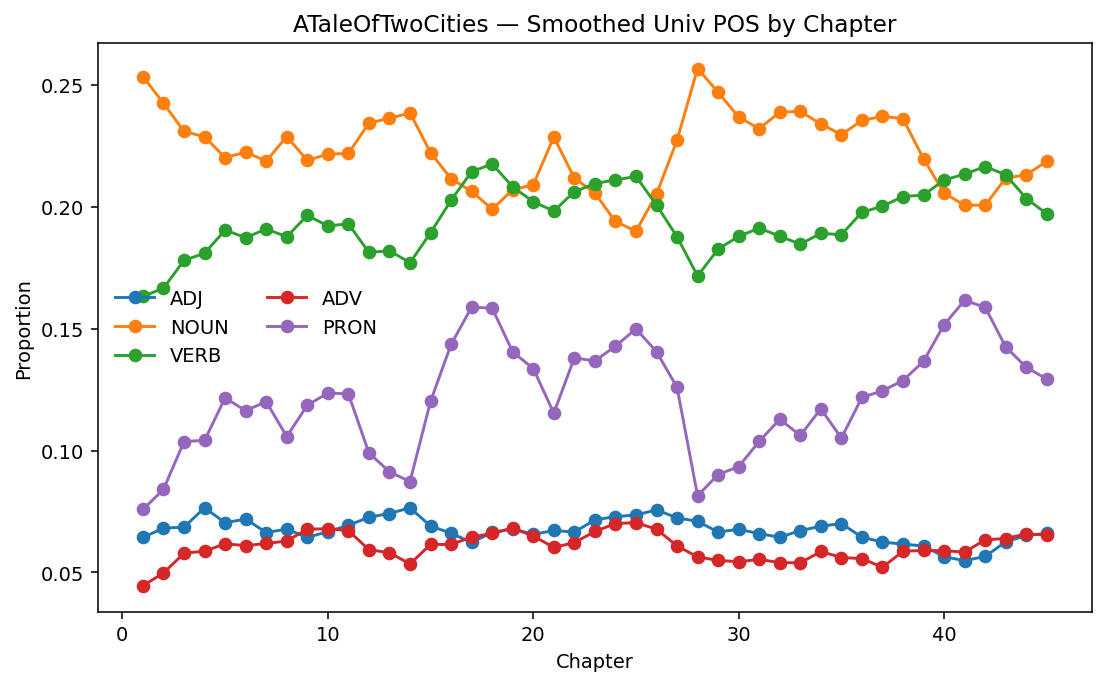

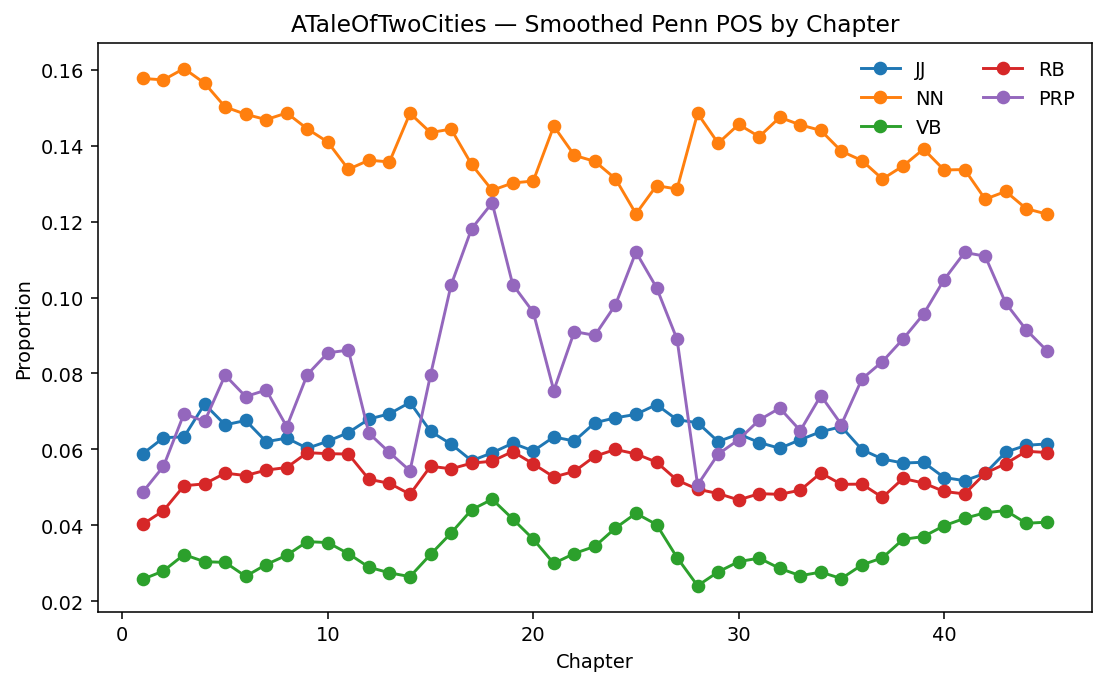

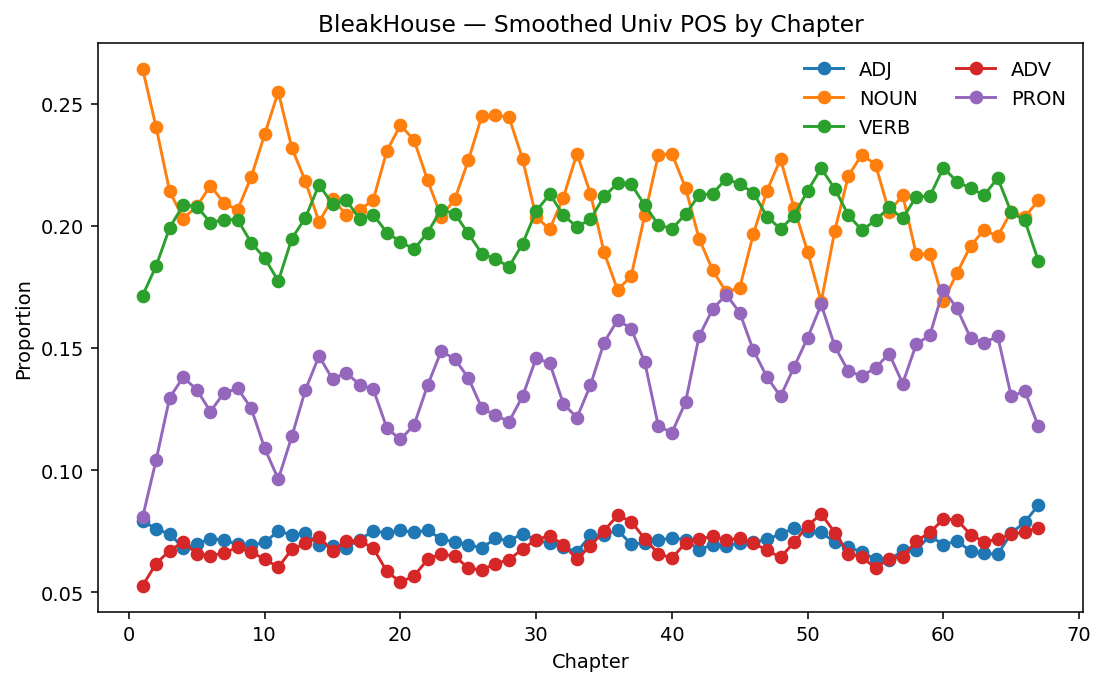

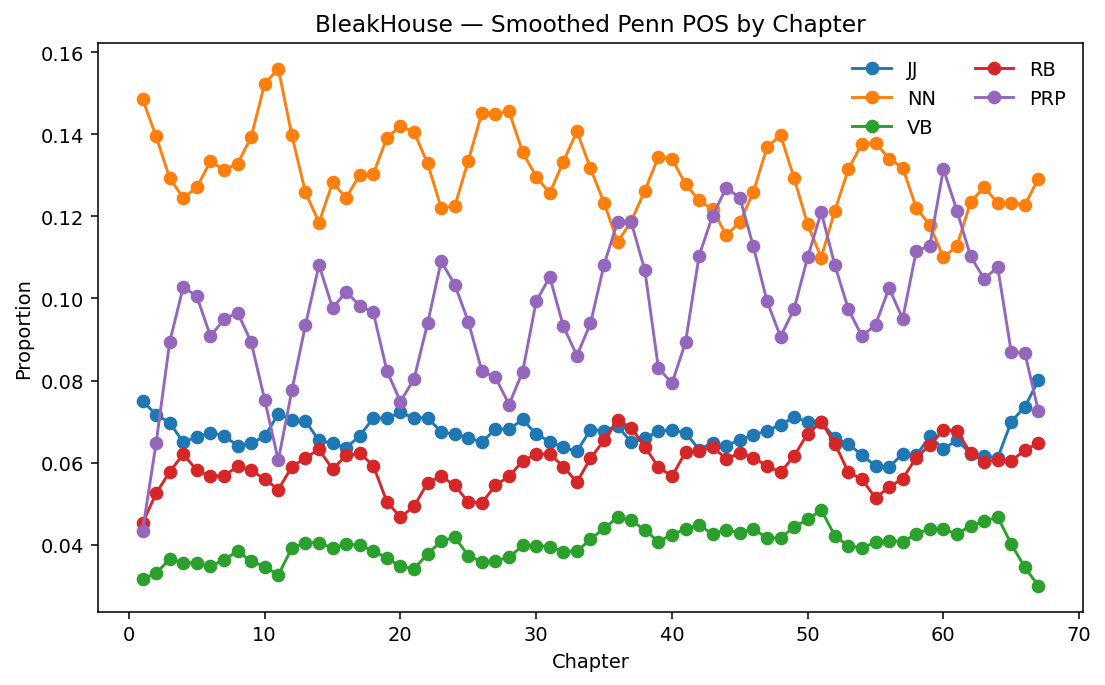

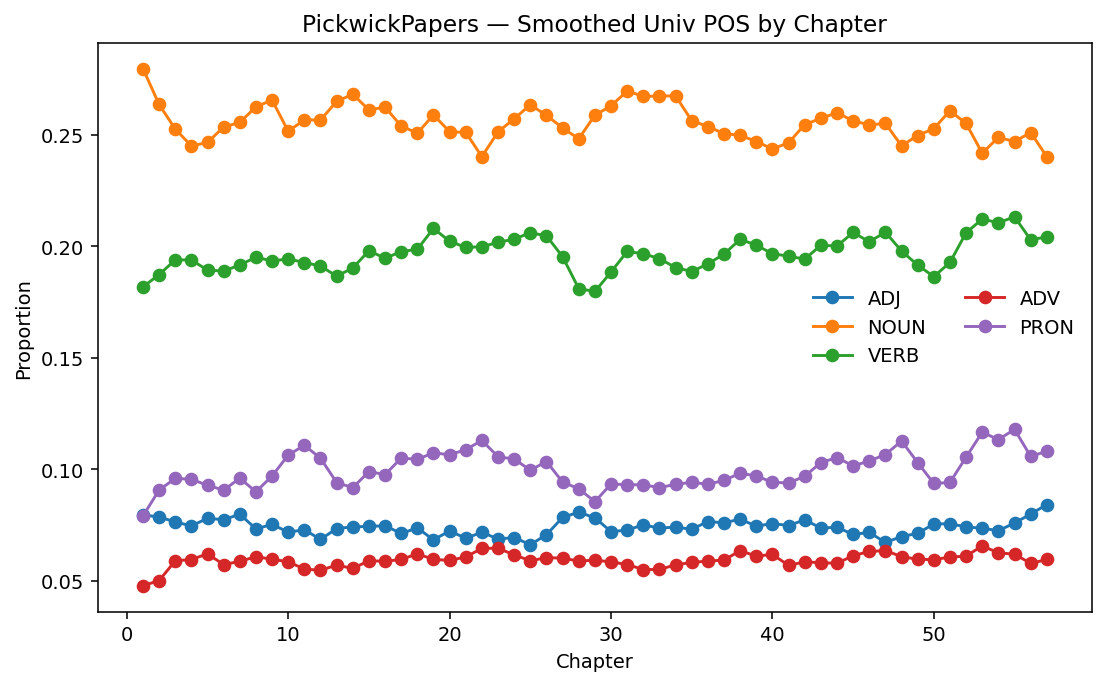

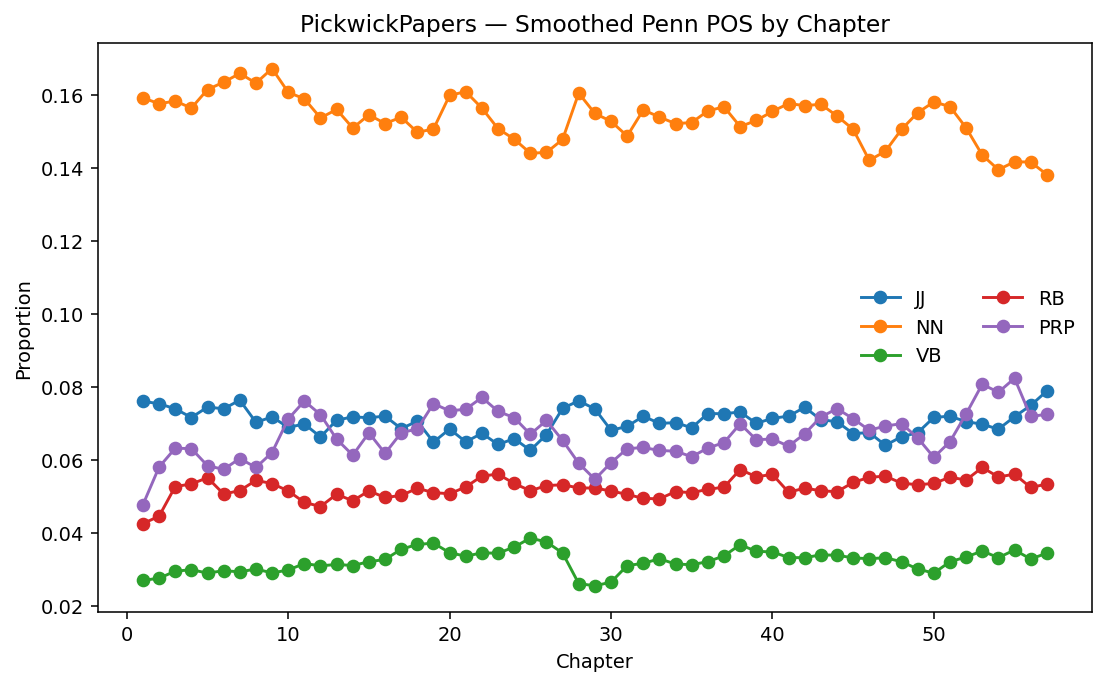

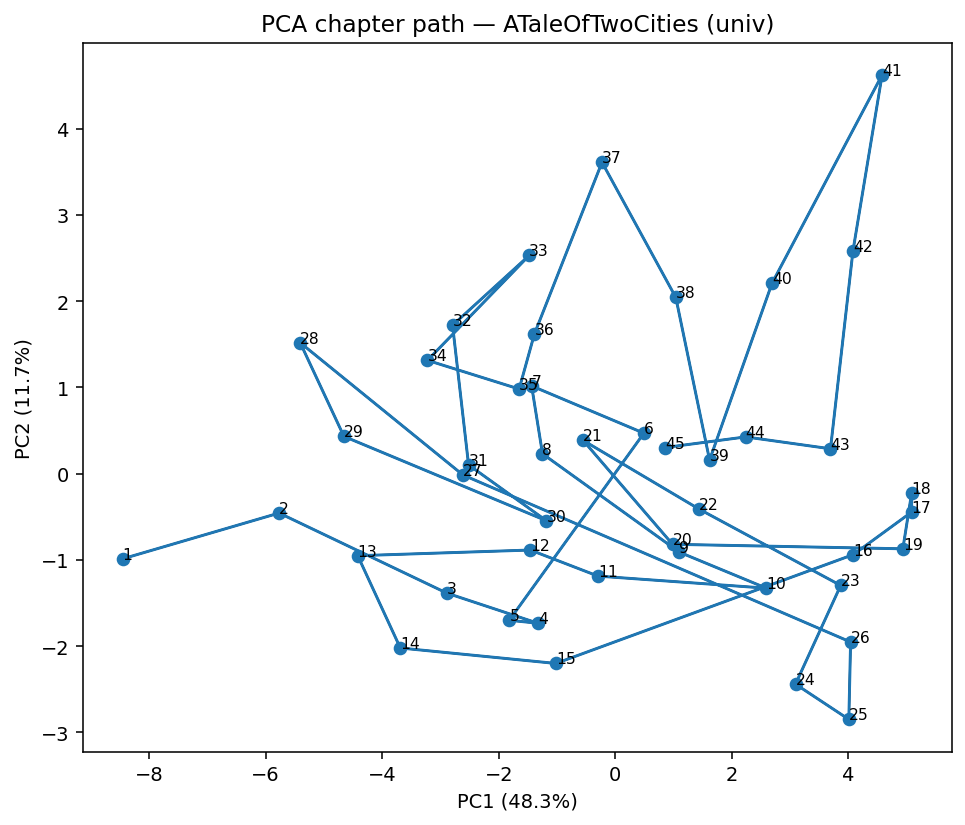

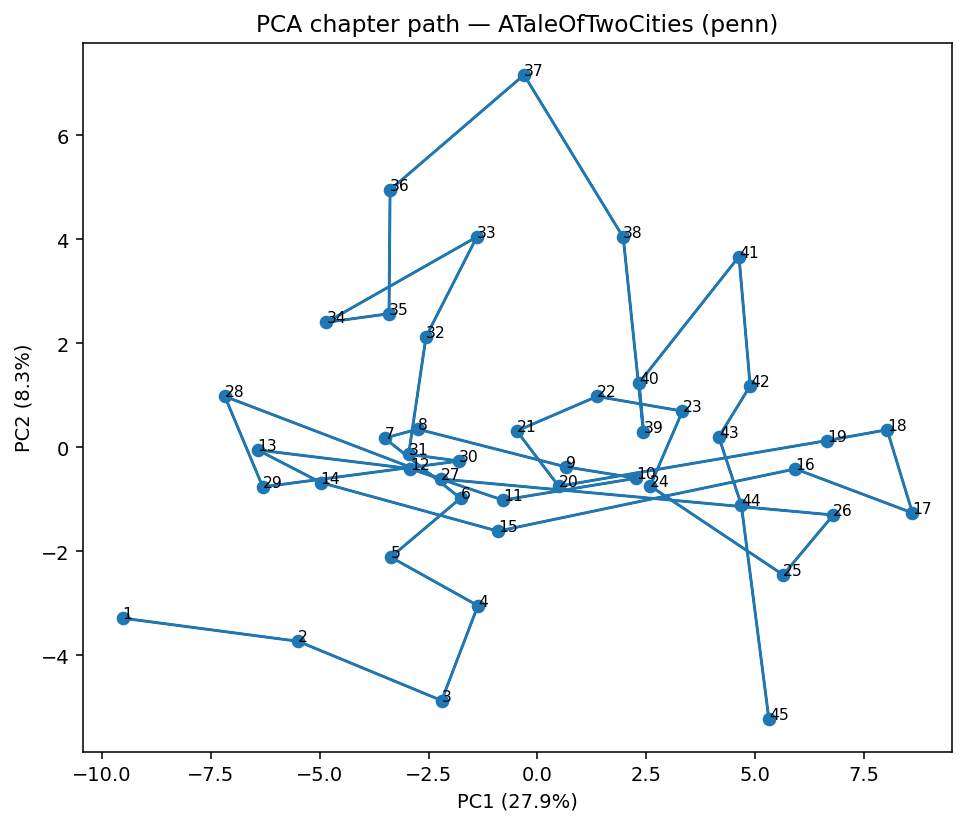

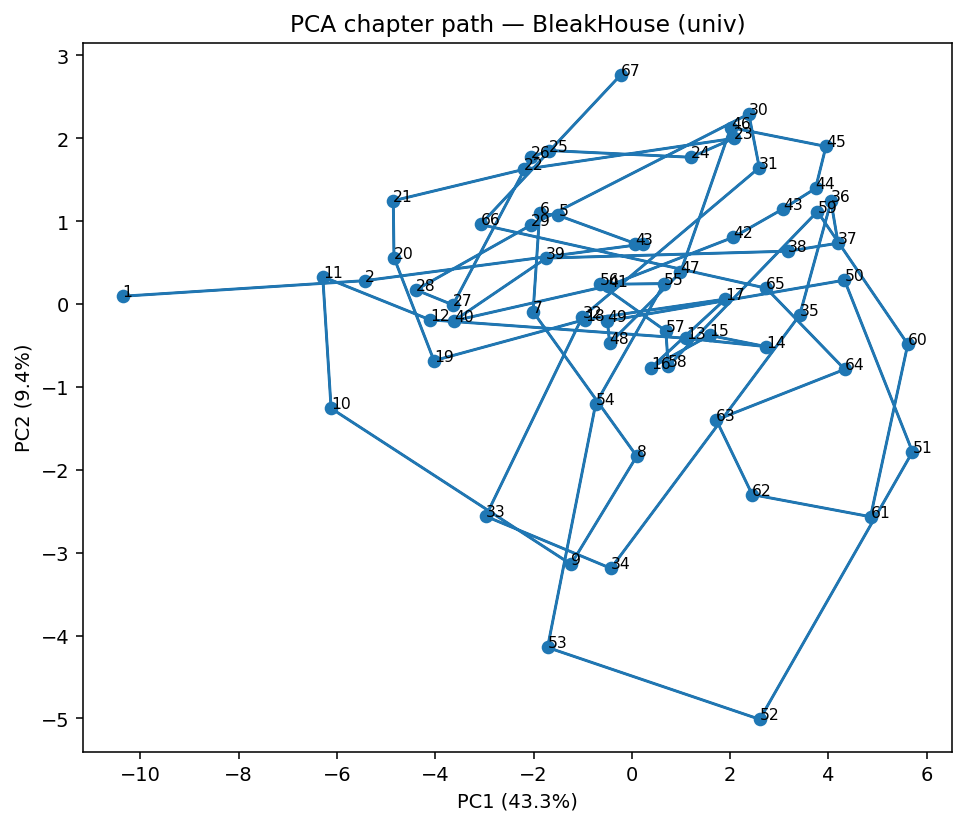

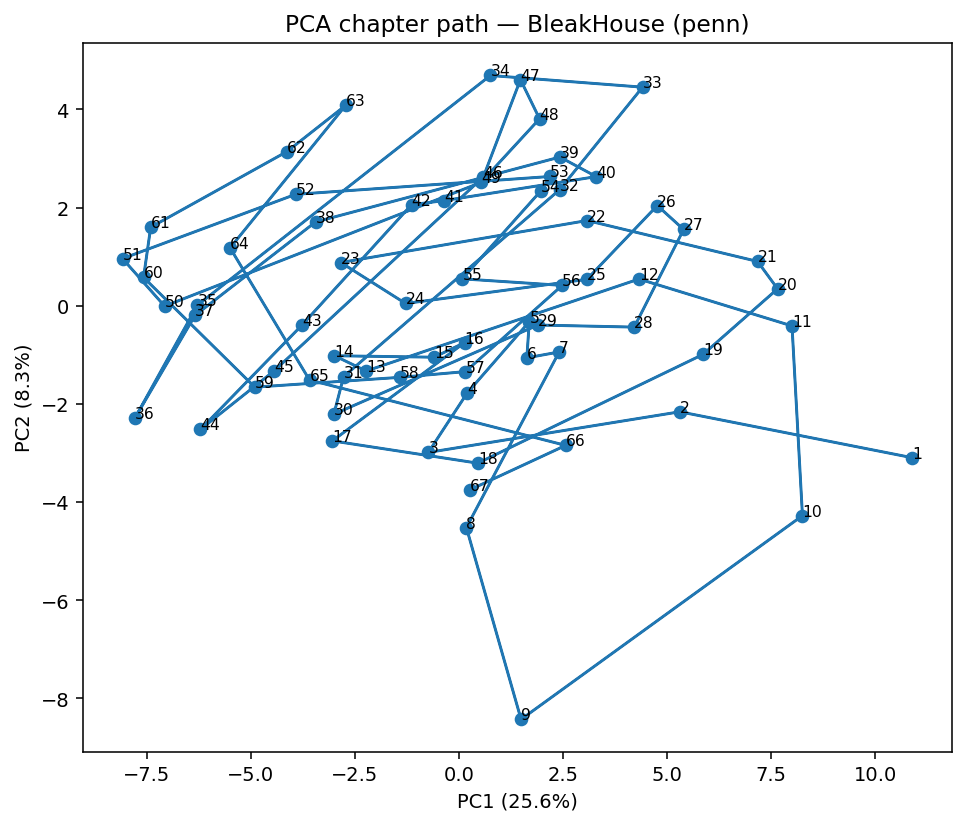

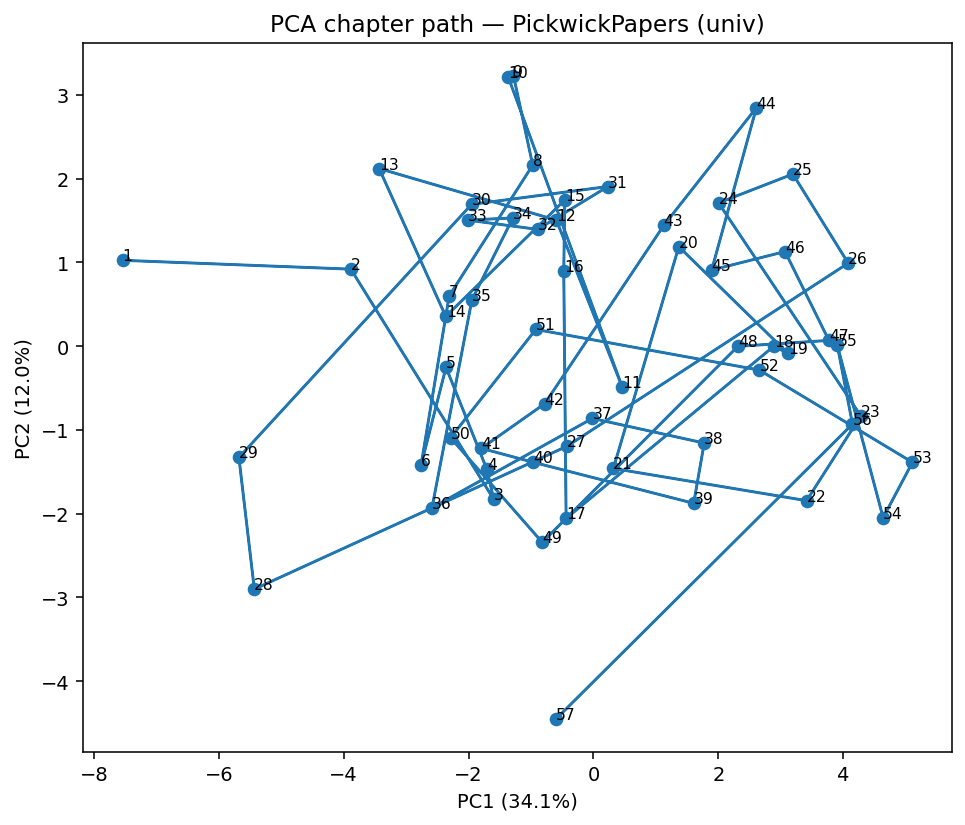

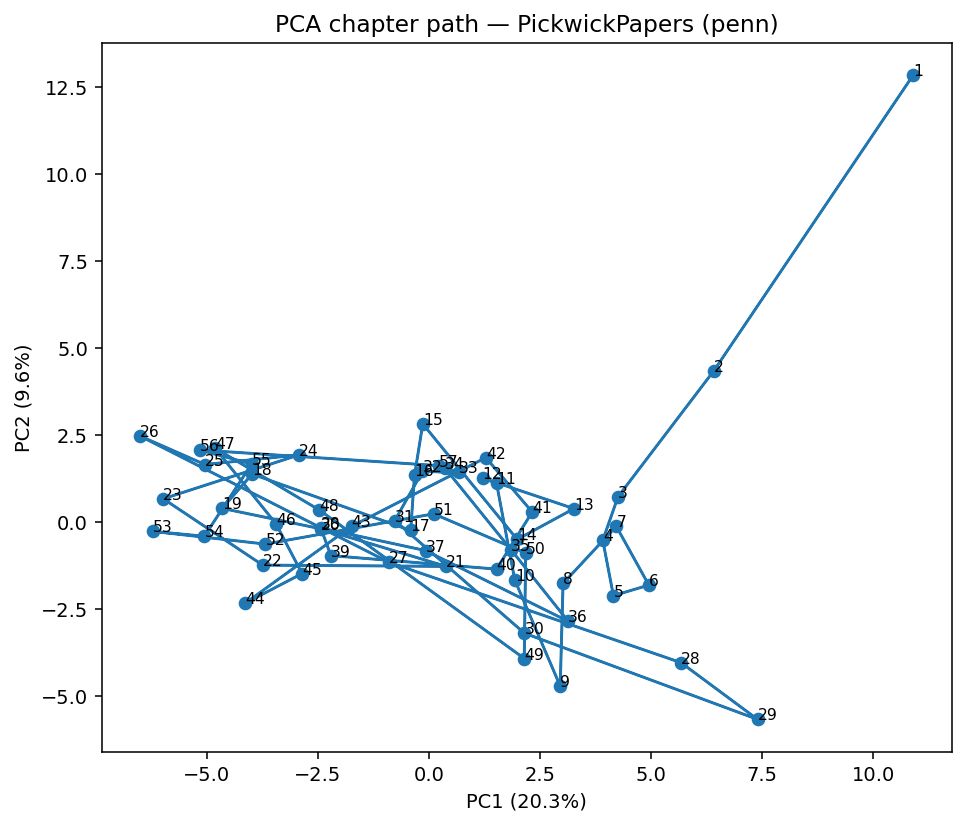

In [9]:
# PART 2.4 - CHAPTER-BY-CHAPTER ANALYSIS FOR THREE NOVELS FOR PARTS OF SPEECH

# Ensure chapter data is ordered correctly before analysis
chapters = chapters.sort_values(["novel", "chapter"]).reset_index(drop=True)

# Rolling smoothing for chapter-level POS signals
def add_rolling(df, tagset="univ", window=3):
    # Identify all POS proportion columns for the given tagset
    cols = [c for c in df.columns if c.startswith(f"pos_{tagset}_prop_")]
    df = df.copy()

    # For each POS proportion column, compute rolling mean per novel
    for col in cols:
        df[col + "_roll"] = (
            df.groupby("novel")[col]  # Group by novel to avoid smoothing across books
              .transform(lambda s: 
                  s.rolling(window=window, min_periods=1, center=True).mean() ) )
    return df

# Apply smoothing separately for universal and Penn tagsets
chapters = add_rolling(chapters, "univ", window=3)
chapters = add_rolling(chapters, "penn", window=3)

# Plotting chapter-by-chapter trajectories of POS usage
def plot_chapter_lines(df, novel_name, tagset, tags, use_roll=True):
    # Filter data for the specific novel
    sub = df[df["novel"] == novel_name].copy()
    if sub.empty:
        print(f"[warn] Novel '{novel_name}' not found in chapters.")
        return

    x = sub["chapter"].values  # X-axis = chapter numbers
    plt.figure(figsize=(8,5))

    # Plot one line per POS tag
    for t in tags:
        # Column name depends on tagset and whether smoothing is applied
        col = f"pos_{tagset}_prop_{t}" + ("_roll" if use_roll else "")
        if col in sub.columns:
            plt.plot(x, sub[col], marker="o", label=t)

    plt.xlabel("Chapter")
    plt.ylabel("Proportion")
    plt.title(f"{novel_name} — {('Smoothed ' if use_roll else '')}{tagset.capitalize()} POS by Chapter")
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()

    # Save figure to FIG_DIR, replacing spaces in novel title with underscores
    fname = f"chapters_{tagset}_{novel_name.replace(' ','_')}.png"
    #plt.savefig(os.path.join(FIG_DIR, fname), dpi=150)
    plt.show()

# Plot trajectories for the first three novels in dataset, for limited set of tags (adjective, noun, verb, adverb, pronoun)
three_novels = chapters["novel"].unique().tolist()[:3]
for nv in three_novels:
    plot_chapter_lines(chapters, nv, "univ", ["ADJ","NOUN","VERB","ADV","PRON"], use_roll=True)
    plot_chapter_lines(chapters, nv, "penn", ["JJ","NN","VB","RB","PRP"], use_roll=True)

# PCA paths for chapter-level stylistic trajectories
def chapter_pca_path(df, novel_name, tagset, fname):
    
    sub = df[df["novel"] == novel_name].copy()
    
    # Select POS proportion columns for the chosen tagset
    cols = [c for c in sub.columns if c.startswith(f"pos_{tagset}_prop_")]
    if not len(cols):
        print(f"[warn] No {tagset} proportion columns for '{novel_name}'.")
        return

    # Standardize POS proportions before PCA
    X = sub[cols].fillna(0.0).values
    X_scaled = StandardScaler().fit_transform(X)

    # Run PCA with 2 components for visualization
    pca = PCA(n_components=2, random_state=19)
    Z = pca.fit_transform(X_scaled)

    plt.figure(figsize=(7,6))
    plt.plot(Z[:,0], Z[:,1], marker="o")

    # Draw arrows from chapter to chapter to indicate reading order
    for i in range(len(Z)-1):
        plt.arrow(Z[i,0], Z[i,1], Z[i+1,0]-Z[i,0], Z[i+1,1]-Z[i,1],
                  length_includes_head=True, head_width=0.03, alpha=0.7)

    # Label points with chapter numbers
    for i, ch in enumerate(sub["chapter"].tolist()):
        plt.annotate(str(ch), (Z[i,0], Z[i,1]), fontsize=8)

    # Axis labels include variance explained by each PC
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.title(f"PCA chapter path — {novel_name} ({tagset})")

    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, fname), dpi=150)
    plt.show()

# Generate PCA chapter paths for each of the first three novels
for nv in three_novels:
    chapter_pca_path(chapters, nv, "univ", f"chap_pca_univ_{nv.replace(' ','_')}.png")
    chapter_pca_path(chapters, nv, "penn", f"chap_pca_penn_{nv.replace(' ','_')}.png")



Ablation: pub_year regression (novel-level)
All (Univ+Penn+Entropy): R2=-1.635±2.409 | MAE=7.53±2.65
Univ only: R2=-10.276±14.314 | MAE=15.04±11.36
Penn only: R2=-0.687±1.113 | MAE=6.31±2.06
Entropy only: R2=-3.909±5.274 | MAE=8.23±2.85
All minus Entropy: R2=-1.051±1.510 | MAE=6.95±2.45
All minus Univ: R2=-0.992±1.489 | MAE=6.65±2.21
All minus Penn: R2=-11.541±18.936 | MAE=12.10±8.76
Content (ADJ/ADV/NOUN/VERB) only: R2=-1.073±1.058 | MAE=7.02±1.92
Function-only: R2=-3.584±3.555 | MAE=9.57±0.30


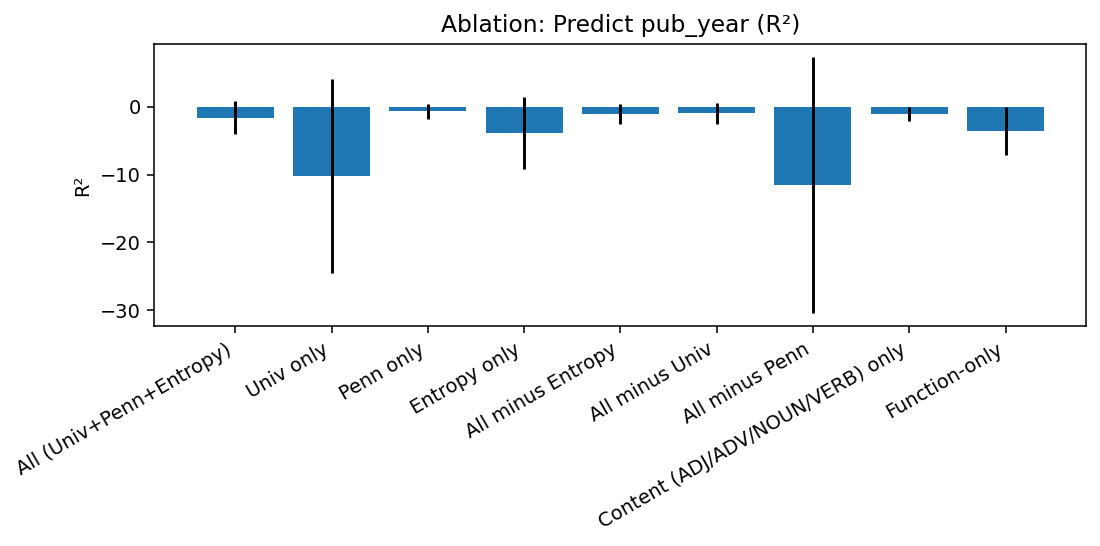

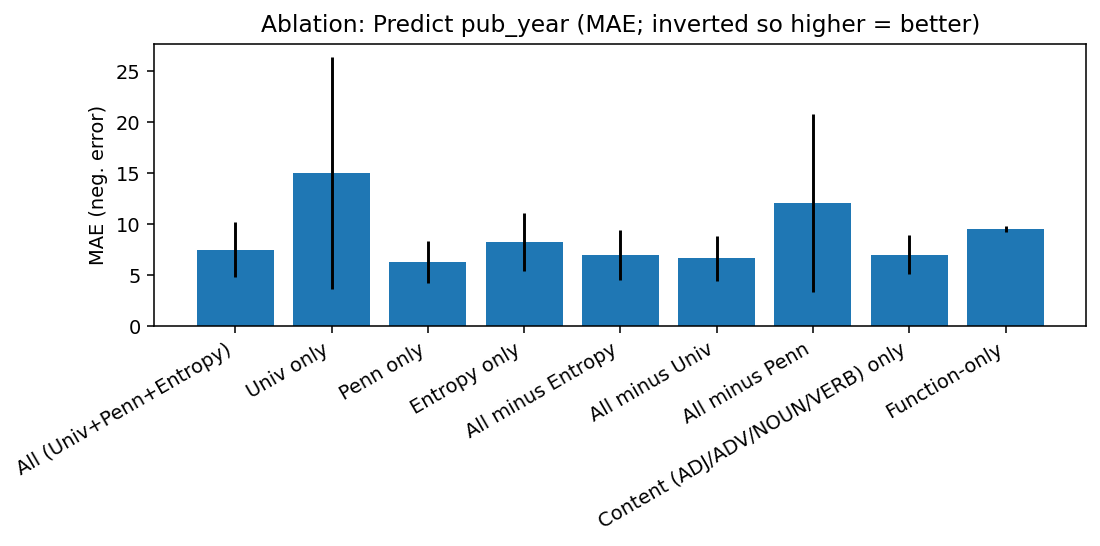


Granularity check: Univ vs Penn vs Penn→Univ (pub_year)
Univ only: R2=-10.276±14.314 | MAE=15.04±11.36
Penn only: R2=-0.687±1.113 | MAE=6.31±2.06
Penn→Univ: R2=-10.253±14.304 | MAE=15.00±11.35


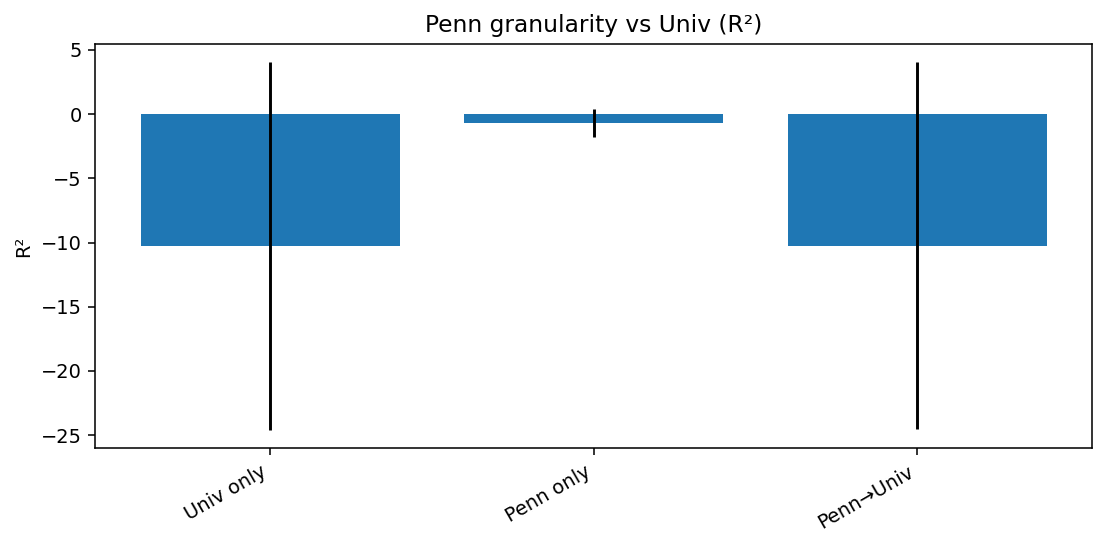

In [10]:
# Part 2.5 - Parts of Speech Ablation Studies (also incorporating Entropy)

# Set the relevant columns

# Universal POS columns (any column starting with "pos_univ_prop_"_
UNIV_COLS = [c for c in novels.columns if c.startswith("pos_univ_prop_")]

# Penn Treebank POS columns (any column starting with "pos_penn_prop_")
PENN_COLS = [c for c in novels.columns if c.startswith("pos_penn_prop_")]

# Extra columns — now is just entropy
EXTRA_COLS = [c for c in ["word_entropy_bits"] if c in novels.columns]

# Subset of Universal POS: only "content" words (adjectives, adverbs, nouns, verbs)
CONTENT_UNIV = [c for c in UNIV_COLS if any(x in c for x in ["_ADJ", "_ADV", "_NOUN", "_VERB"])]

# Opposite subset of Universal POS: only "function" words (determiners, adpositions, pronouns, etc.)
FUNCTION_UNIV = [c for c in UNIV_COLS if c not in CONTENT_UNIV]

# Penn-to-Univ mapping
PENN_TO_UNIV = {
    "''": ".", '$': ".",
    "CC": "CONJ",
    "CD": "NUM",
    "DT": "DET",
    "EX": "PRON",
    "FW": "X",
    "IN": "ADP",
    "JJ": "ADJ", "JJR": "ADJ", "JJS": "ADJ",
    "MD": "VERB",
    "NN": "NOUN", "NNP": "NOUN", "NNPS": "NOUN", "NNS": "NOUN",
    "PDT": "DET",
    "POS": "PRT",
    "PRP": "PRON", "PRP$": "PRON",
    "RB": "ADV", "RBR": "ADV", "RBS": "ADV",
    "RP": "PRT", "TO": "PRT",
    "UH": "X",
    "VB": "VERB", "VBD": "VERB", "VBG": "VERB", "VBN": "VERB", "VBP": "VERB", "VBZ": "VERB",
    "WDT": "DET", "WP": "PRON", "WP$": "PRON", "WRB": "ADV",
}
UNIV_TAGS = sorted(set(PENN_TO_UNIV.values()))

def design_matrix(df, include):
    """Helper function that builds the feature matrix based on the specified included elements"""
    cols = []
    
    # Include all Universal POS proportion features if requested
    if include.get("universal", False):
        cols += [c for c in df.columns if c.startswith("pos_univ_prop_")]
    
    # Include all Penn POS proportion features if requested
    if include.get("penn", False):
        cols += [c for c in df.columns if c.startswith("pos_penn_prop_")]
    
    # Include extra features like entropy if requested
    if include.get("extra", False):
        cols += [c for c in ["word_entropy_bits", "vader_compound", "vader_pos", "vader_neu", "vader_neg"]
                 if c in df.columns]
    
    # Include any custom sets of columns (e.g., CONTENT_UNIV or FUNCTION_UNIV)
    for custom in include.get("custom_cols", []):
        cols += [c for c in df.columns if c in custom]
    
    # Remove duplicates while preserving order, then sort
    cols = sorted(list(dict.fromkeys(cols)))
    
    # Extract numeric matrix, filling NaNs with 0
    X = df[cols].astype(float).fillna(0.0).values
    return X, cols

def barplot_scores(summary, title, ylabel, fname):
    """ Basic bar plot helper for visualizing results"""
    labels = list(summary.keys())
    means = [summary[k][0] for k in labels]
    stds  = [summary[k][1] for k in labels]
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(labels)), means, yerr=stds)
    plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    # plt.savefig(fname, dpi=150)
    plt.show()

def ablate_pub_year(novels_df):
    """ Run an ablation study to see which feature groups are most important for predicting publication year of novels."""
    y = novels_df["pub_year"].values  # target variable
    kf = KFold(n_splits=min(5, len(novels_df)), shuffle=True, random_state=19)  # 5-fold CV
    
    # Define the different configurations to test
    configs = {
        "All (Univ+Penn+Entropy)": {"universal": True, "penn": True, "extra": True},
        "Univ only":               {"universal": True, "penn": False, "extra": False},
        "Penn only":               {"universal": False, "penn": True, "extra": False},
        "Entropy only":            {"universal": False, "penn": False, "extra": True},
        "All minus Entropy":       {"universal": True, "penn": True, "extra": False},
        "All minus Univ":          {"universal": False, "penn": True, "extra": True},
        "All minus Penn":          {"universal": True, "penn": False, "extra": True},
        "Content (ADJ/ADV/NOUN/VERB) only": {"universal": False, "penn": False, "extra": False, "custom_cols": [CONTENT_UNIV]},
        "Function-only":           {"universal": False, "penn": False, "extra": False, "custom_cols": [FUNCTION_UNIV]} }
    
    # Define scoring metrics (R² and MAE)
    scoring = {"R2": make_scorer(r2_score),
            "MAE": make_scorer(mean_absolute_error, greater_is_better=False) } # MAE is negated here for plotting convenience/clarity
    
    results = {}
    
    # Run each configuration
    for name, include in configs.items():
        # Build features
        X, cols = design_matrix(novels_df, include)
        
        # Ridge regression model with scaling
        model = make_pipeline(StandardScaler(with_mean=True), RidgeCV(alphas=np.logspace(-3, 3, 25), cv=3) )
        
        # Cross-validate
        cv = cross_validate(model, X, y, scoring=scoring, cv=kf, n_jobs=None, return_train_score=False)
        
        # Flip sign of MAE (so bigger = better aka more intuitive for plotting)
        results[name] = {"R2": cv["test_R2"], "MAE": -cv["test_MAE"]}
        
        # Print mean ± std for both metrics
        print(f"{name}: R2={cv['test_R2'].mean():.3f}±{cv['test_R2'].std():.3f} | "
              f"MAE={-cv['test_MAE'].mean():.2f}±{cv['test_MAE'].std():.2f}")
    
    # Prepare summaries for plotting
    r2_summary  = {k: (v["R2"].mean(), v["R2"].std()) for k, v in results.items()}
    mae_summary = {k: (v["MAE"].mean(), v["MAE"].std()) for k, v in results.items()}
    
    # Plot results
    barplot_scores(r2_summary,  "Ablation: Predict pub_year (R²)", "R²", "ablation_pubyear_r2.png")
    barplot_scores(mae_summary, "Ablation: Predict pub_year (MAE; inverted so higher = better)",
                   "MAE (neg. error)", "ablation_pubyear_mae.png")


# Now do granularity check to compare Universal vs Penn vs Penn→Univ
def replace_penn_with_pennAsUniv(df):
    """Aggregate Penn POS proportions into Universal POS categories."""
    pcols = [c for c in df.columns if c.startswith("pos_penn_prop_")]
    if not pcols:
        return df  # no Penn columns to replace
    
    from collections import defaultdict
    accum = defaultdict(lambda: np.zeros(len(df)))
    
    # Sum Penn columns into their mapped Universal category
    for c in pcols:
        tag = c.replace("pos_penn_prop_", "")
        univ = PENN_TO_UNIV.get(tag)
        if univ:
            accum[f"pennAs_pos_univ_prop_{univ}"] += df[c].fillna(0.0).values
    
    out = df.copy()
    for k, v in accum.items():
        out[k] = v
    return out


def quick_pubyear_compare_penn_variants(novels_df):
    """ Compare model performance using Univ only, Penn only, or Penn aggregated to Universal categories"""
    y = novels_df["pub_year"].values
    kf = KFold(n_splits=min(5, len(novels_df)), shuffle=True, random_state=19)
    
    configs = {"Univ only": {"cols": [c for c in novels_df.columns if c.startswith("pos_univ_prop_")]},
               "Penn only": {"cols": [c for c in novels_df.columns if c.startswith("pos_penn_prop_")]},
               "Penn→Univ": {"cols": [c for c in novels_df.columns if c.startswith("pennAs_pos_univ_prop_")]} }
    
    res = {}
    
    # Run each variant
    for name, cfg in configs.items():
        X = novels_df[cfg["cols"]].astype(float).fillna(0.0).values
        model = make_pipeline(StandardScaler(with_mean=True),
                              RidgeCV(alphas=np.logspace(-3, 3, 25), cv=3))
        
        r2s, maes = [], []
        
        for tr, te in kf.split(X):
            model.fit(X[tr], y[tr])
            pred = model.predict(X[te])
            r2s.append(r2_score(y[te], pred))
            maes.append(mean_absolute_error(y[te], pred))
        
        res[name] = (np.mean(r2s), np.std(r2s)), (np.mean(maes), np.std(maes))
        
        # Print mean ± std for both metrics
        print(f"{name}: R2={np.mean(r2s):.3f}±{np.std(r2s):.3f} | "
              f"MAE={np.mean(maes):.2f}±{np.std(maes):.2f}")
    
    # Plot only the R² values
    barplot_scores({k: v[0] for k, v in res.items()},
                   "Penn granularity vs Univ (R²)",
                   "R²", "ablation_penn_variants_r2.png")

# Run ablation studies
print("\nAblation: pub_year regression (novel-level)")
ablate_pub_year(novels)

# Run granularity check
novels_p2u = replace_penn_with_pennAsUniv(novels)
chapters_p2u = replace_penn_with_pennAsUniv(chapters)
print("\nGranularity check: Univ vs Penn vs Penn→Univ (pub_year)")
quick_pubyear_compare_penn_variants(novels_p2u)

[ok] Created/updated:
  - word_entropy_bits_univ_content  (novels: ✓, chapters: ✓)
  - word_entropy_bits_penn_coarse  (novels: ✓, chapters: ✓)


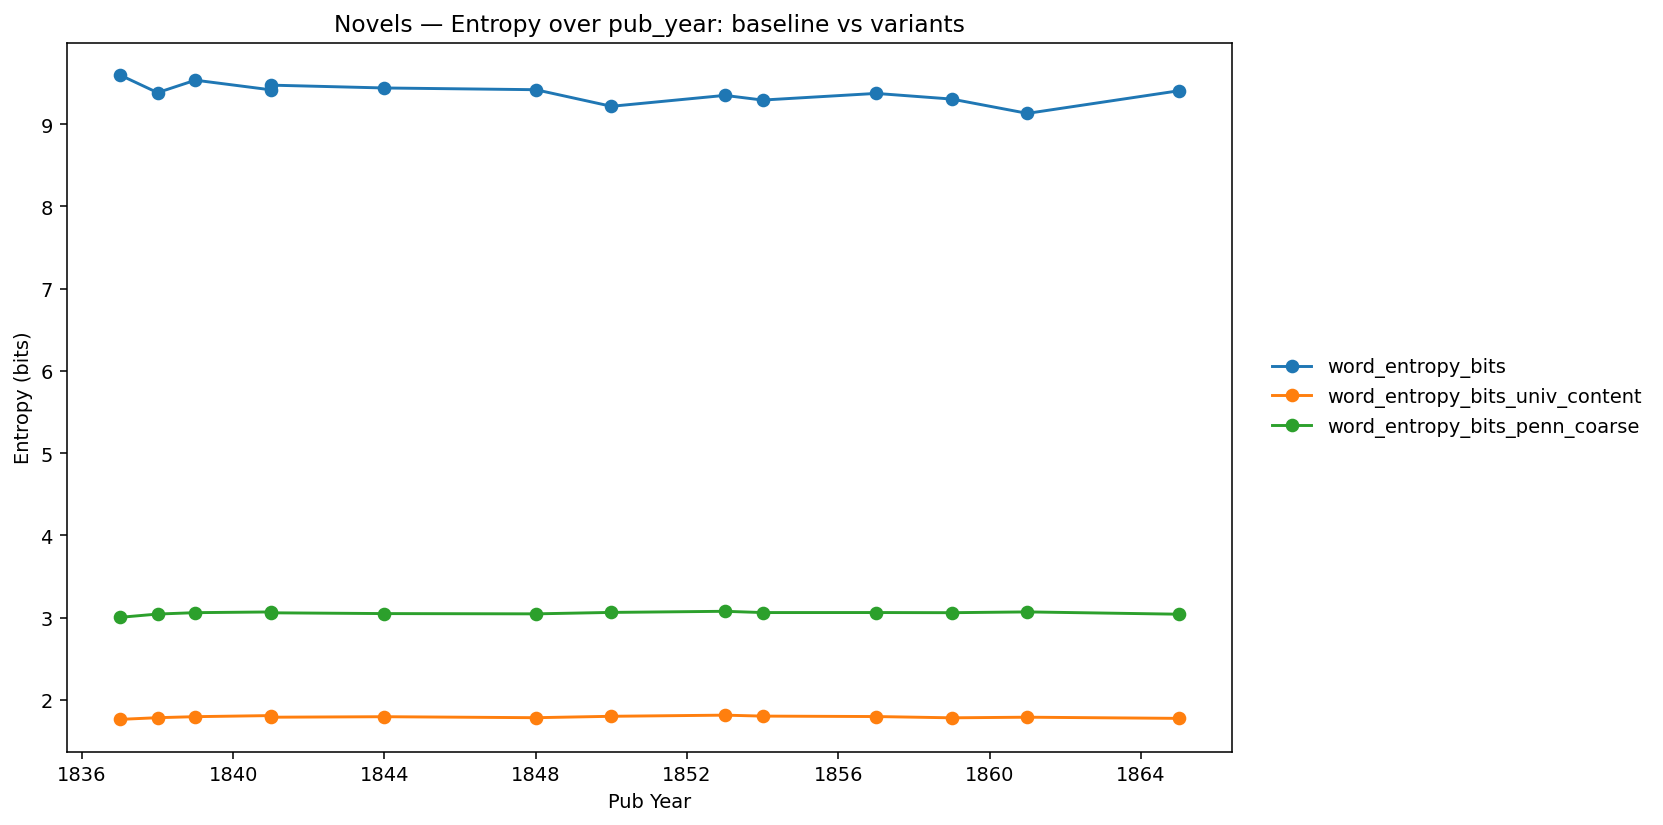

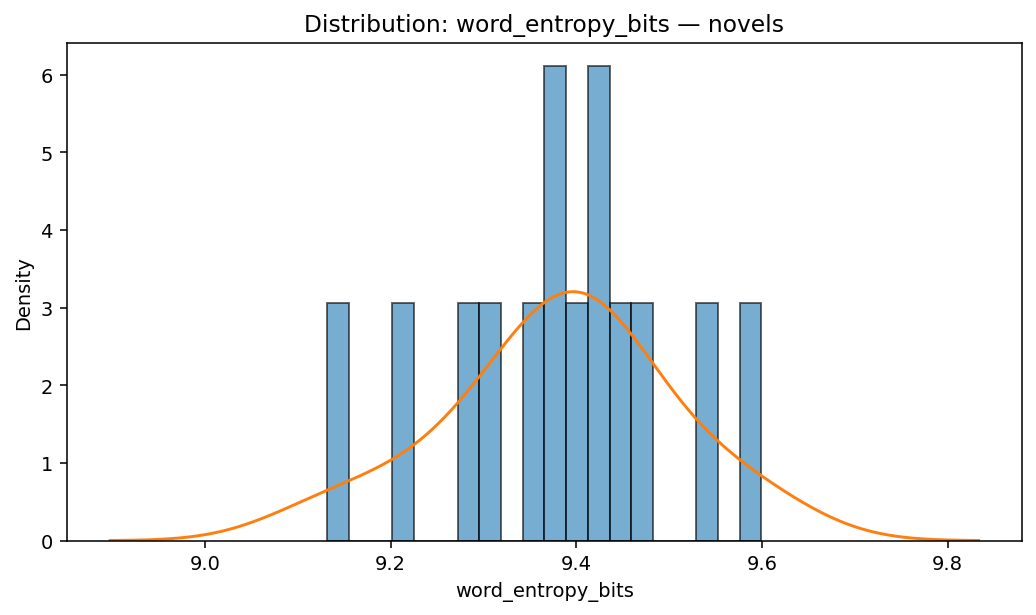

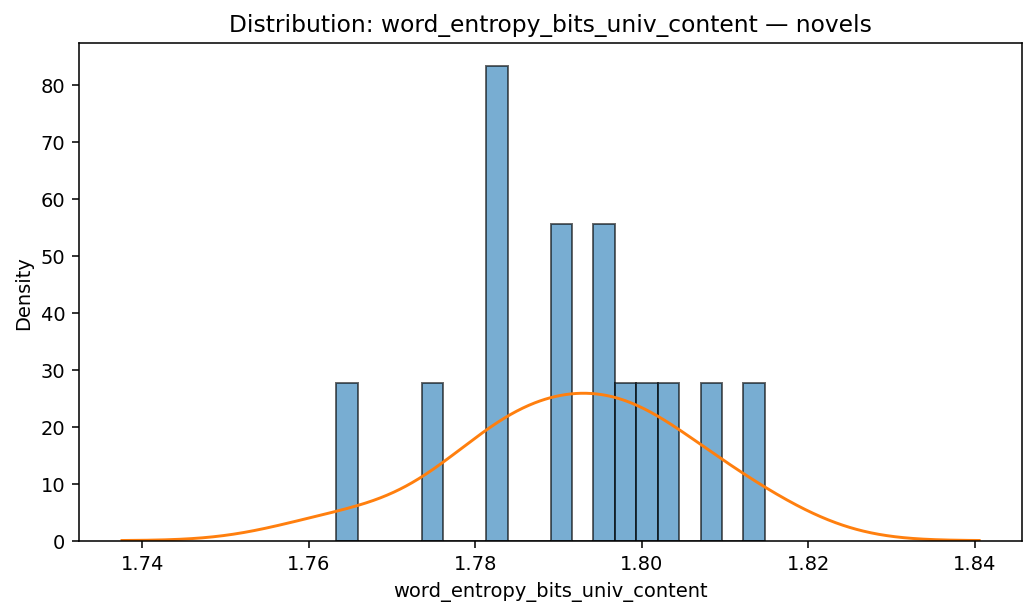

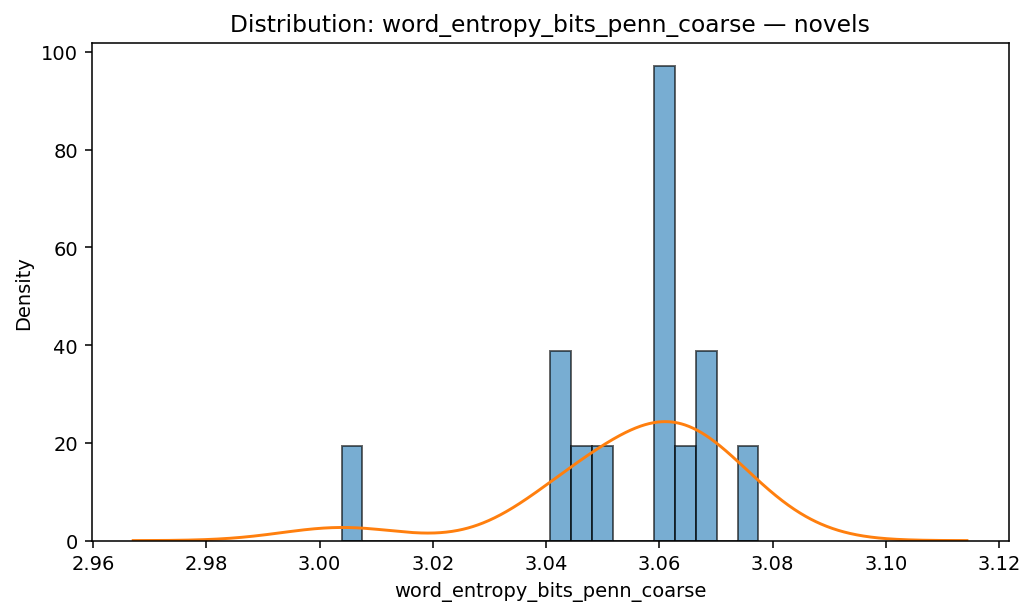

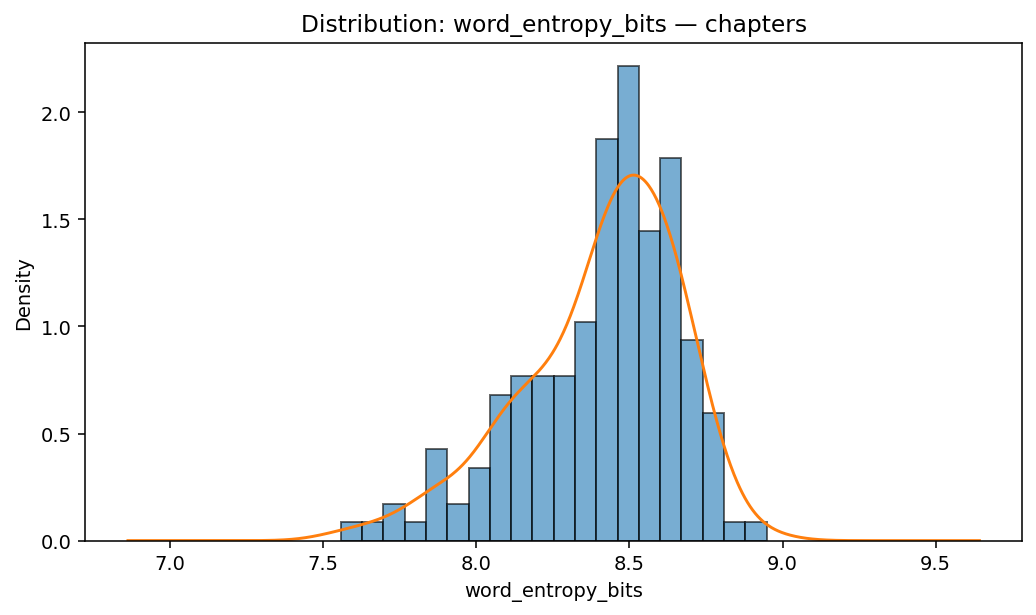

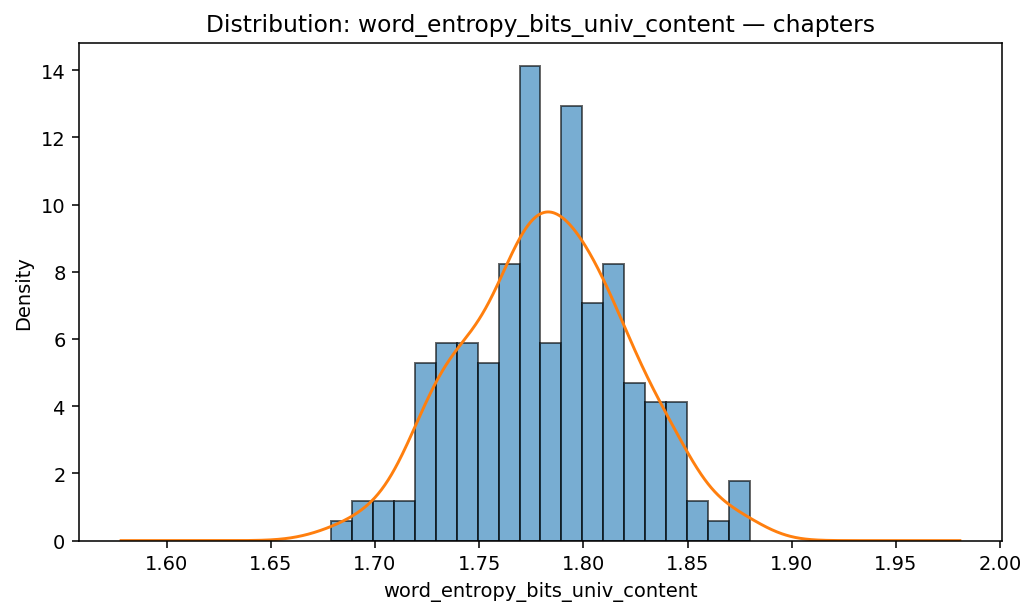

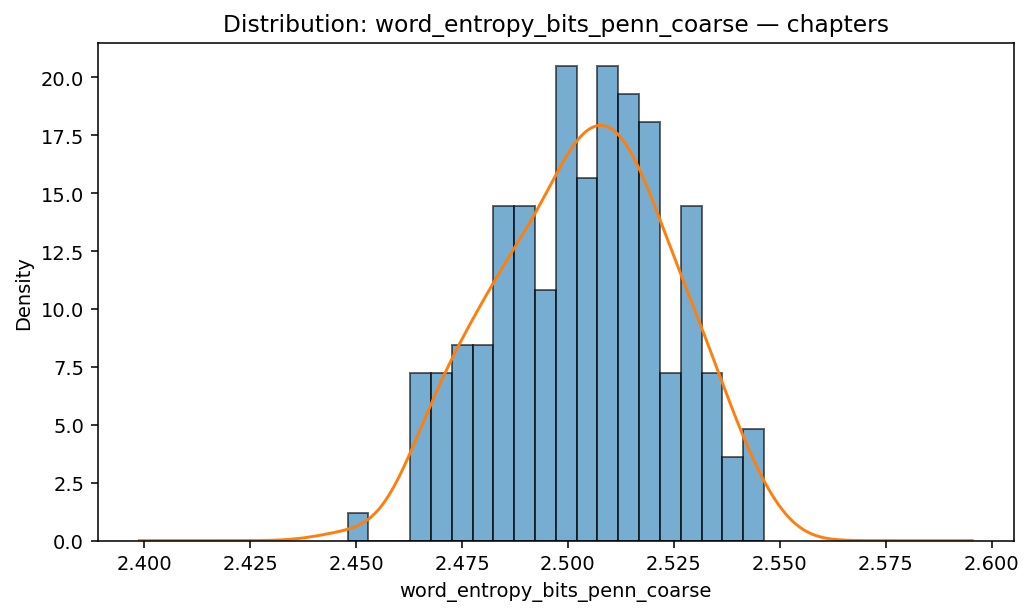

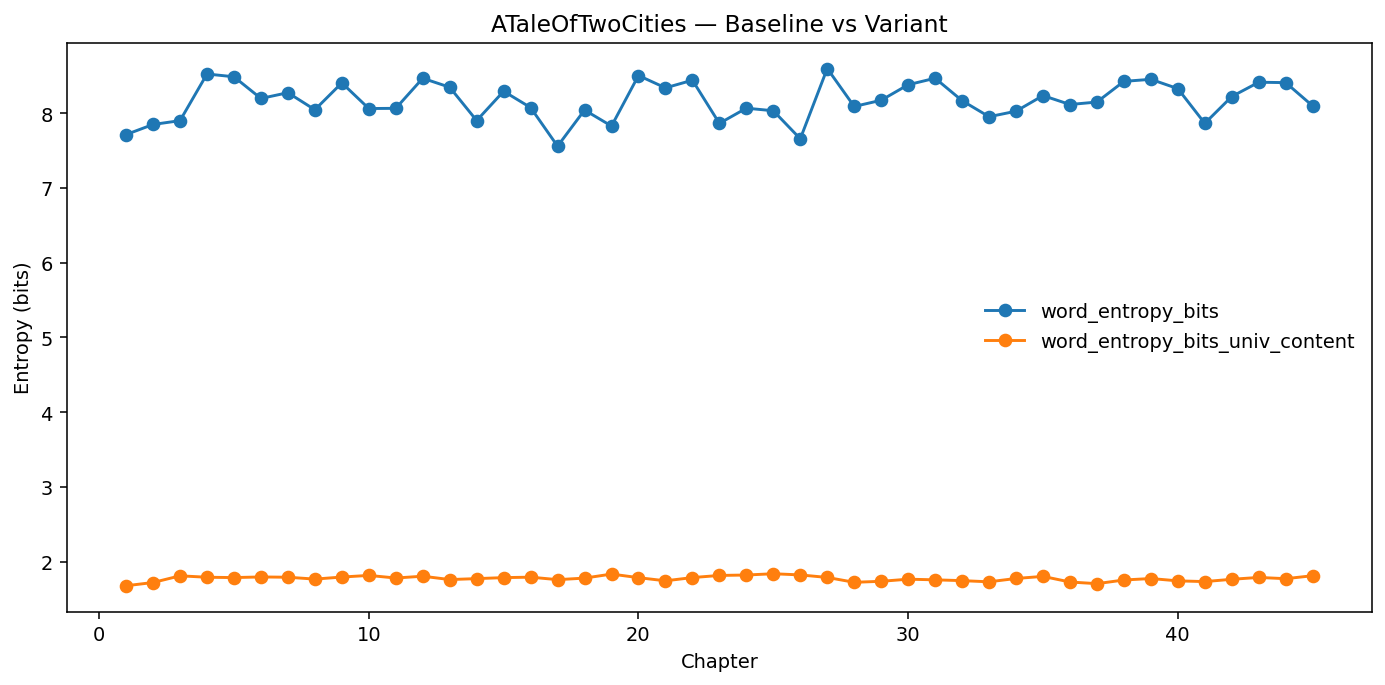

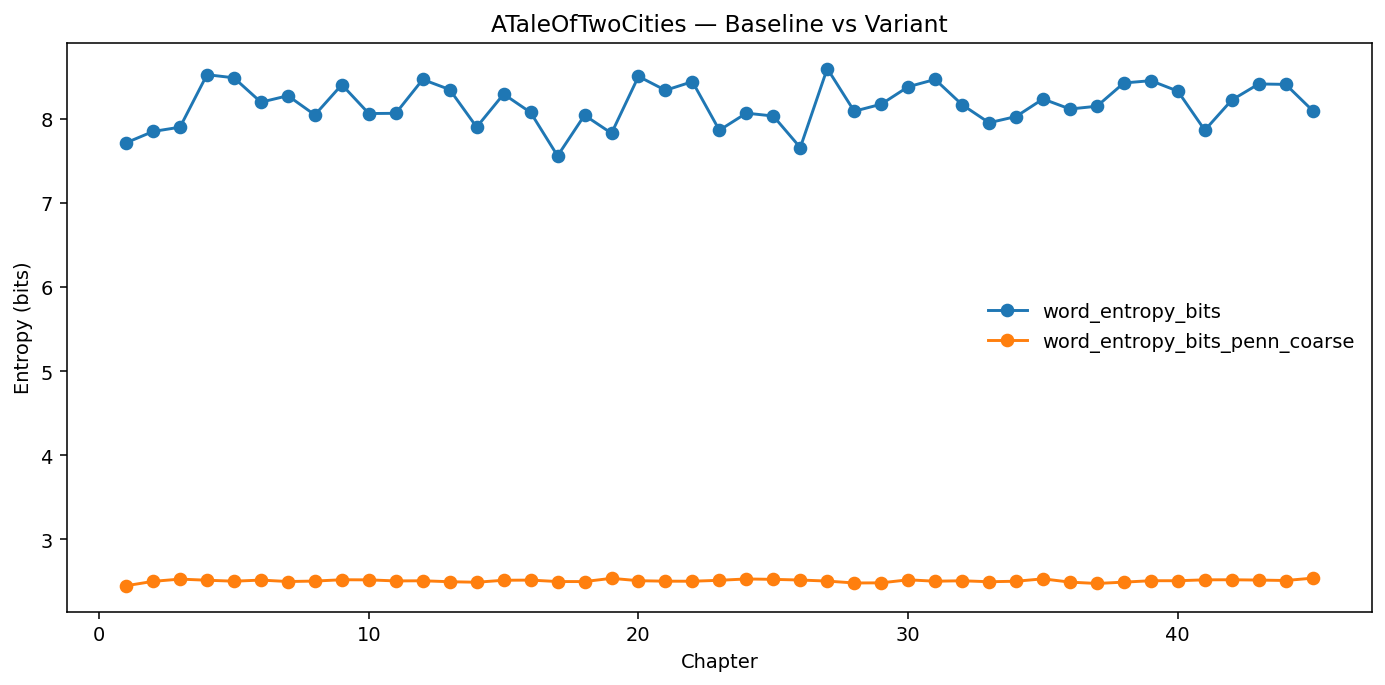

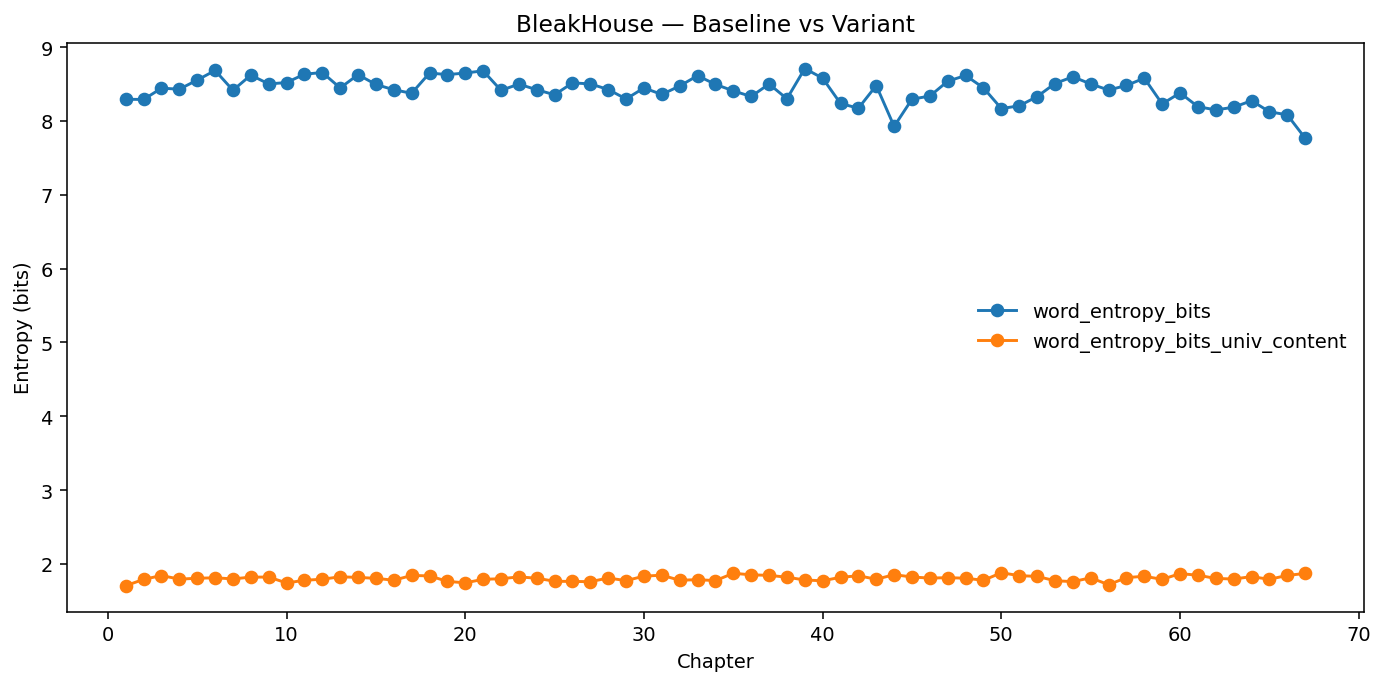

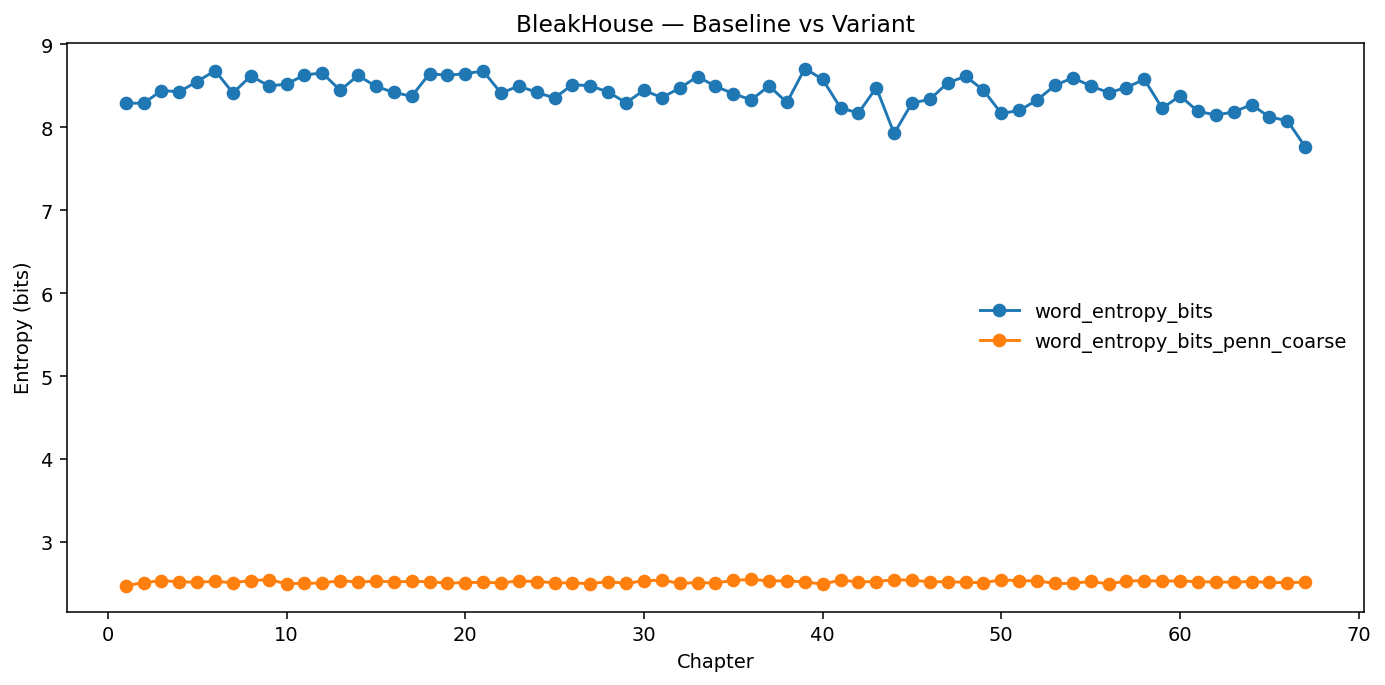

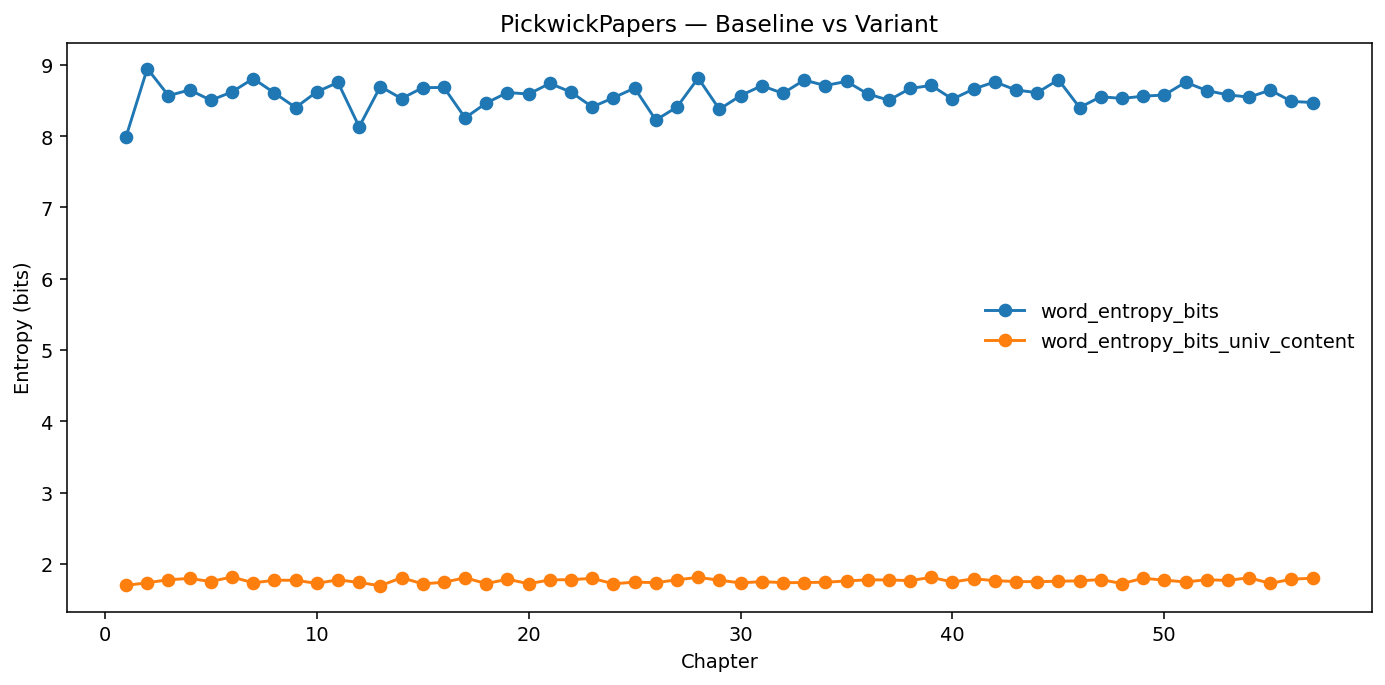

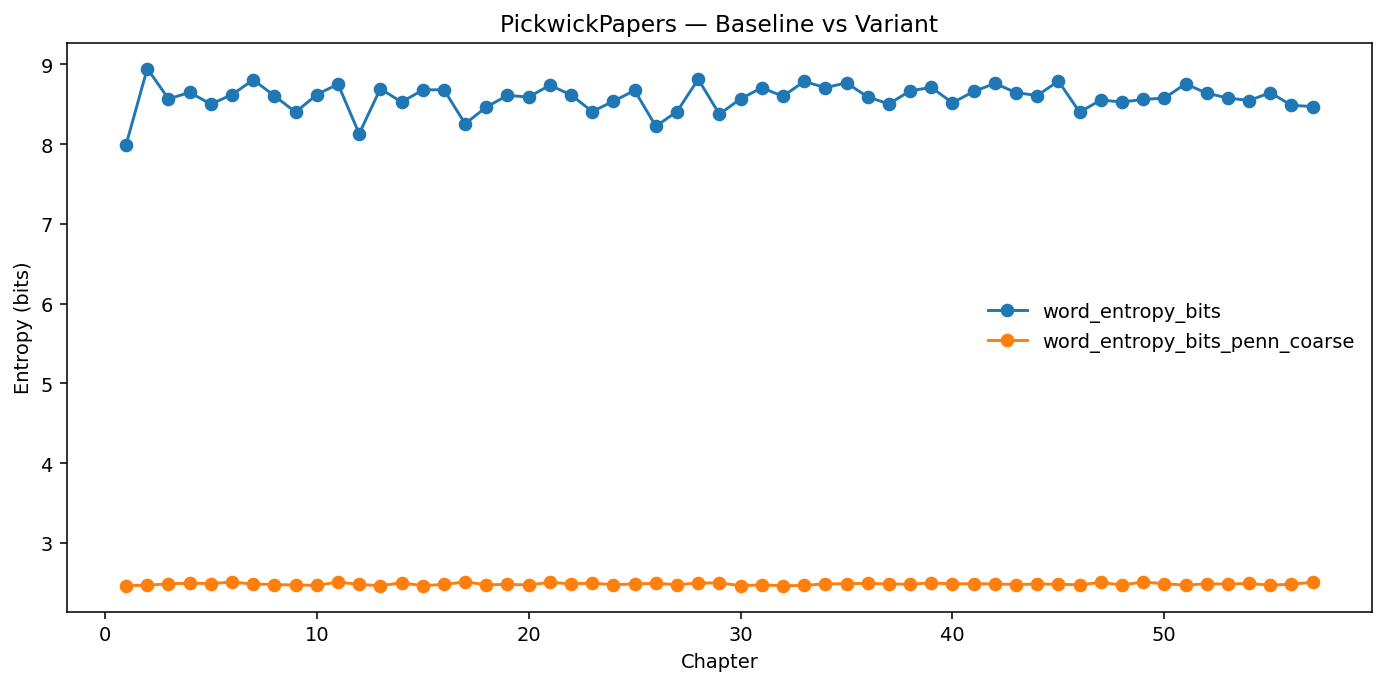

In [11]:
# PART 3.1 - Entropy Analysis

def entropy_bits_from_props_array(props):
    """ Calculate Shannon entropy (in bits) given an array of proportions."""
    # Convert to a NumPy array of floats for safe math
    p = np.asarray(props, dtype=float)

    # Remove NaN entries (missing data should not affect sums)
    p = p[~np.isnan(p)]

    # Remove zero entries (terms with p=0 contribute nothing to entropy)
    p = p[p > 0]

    # If no valid proportions remain, entropy is undefined
    if p.size == 0:
        return np.nan

    # Normalize so that the proportions sum to exactly 1
    p = p / p.sum()

    # Compute Shannon entropy in bits: -Σ(p * log₂(p))
    return -(p * np.log2(p)).sum()

def recompute_entropy_from_cols(df, prop_cols, out_col):
    """ Given a df and a list of proportion columns, compute entropy per row."""
    # Work on a copy to avoid modifying the original df
    out = df.copy()

    # If no columns provided, fill with NaN
    if not prop_cols:
        out[out_col] = np.nan
        return out

    # Apply row-wise entropy calculation:
    #   - For each row, extract the values from prop_cols
    #   - Pass them to entropy_bits_from_props_array
    out[out_col] = out[prop_cols].apply(
        lambda r: entropy_bits_from_props_array(r.values),
        axis=1 )

    return out

def compare_time_series(novels_df, base_col, variant_cols, xcol="pub_year", label="novels"):
    """ Helper function for plotting for entropy
    Plots baseline + each variant as separate lines vs pub_year. Legend is outside; figure expands with number of series. """
    cols = _present_cols(novels_df, [base_col] + list(variant_cols))
    if base_col not in cols:
        print(f"[warn] '{base_col}' not found. Skipping time series.")
        return
    width = 12
    height = max(6, 3 + 0.5*len(cols))
    plt.figure(figsize=(width, height))
    x = novels_df[xcol].values
    for c in cols:
        plt.plot(x, novels_df[c], marker="o", label=c)
    plt.xlabel(xcol.replace("_", " ").title())
    plt.ylabel("Entropy (bits)")
    plt.title(f"{label.capitalize()} — Entropy over {xcol}: baseline vs variants")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    out = os.path.join(FIG_DIR, f"compare_timeseries_{label}.png")
    plt.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()

def compare_distributions(df, base_col, variant_cols, label, bins=20):
    """ Helper function that plots distributions separately for each column (baseline + variants), so 
    shapes are easy to compare without overplotting.
    """
    cols = _present_cols(df, [base_col] + list(variant_cols))
    if not cols:
        print(f"[warn] No columns to plot for {label}.")
        return
    for c in cols:
        series = df[c].dropna()
        if series.empty:
            continue
        plt.figure(figsize=(7.5, 4.5))
        series.plot.hist(bins=bins, alpha=0.6, edgecolor="black", density=True)
        if series.var() > 0:
            series.plot.kde()
        plt.xlabel(c); plt.ylabel("Density")
        plt.title(f"Distribution: {c} — {label}")
        plt.tight_layout()
        out = os.path.join(FIG_DIR, f"compare_dist_{c}_{label}.png")
        plt.savefig(out, dpi=150)
        plt.show()

def compare_chapter_trajectory(chapters_df, novel_name, base_col, variant_col, use_roll=True):
    """Helper to make a  Line plot of baseline vs variant entropy over chapters for a given novel."""
    sub = chapters_df[chapters_df["novel"] == novel_name].copy()
    if sub.empty:
        print(f"[warn] Novel '{novel_name}' not found.")
        return
    b_col = f"{base_col}_roll" if use_roll and f"{base_col}_roll" in sub.columns else base_col
    v_col = f"{variant_col}_roll" if use_roll and f"{variant_col}_roll" in sub.columns else variant_col
    missing = [c for c in [b_col, v_col] if c not in sub.columns]
    if missing:
        print(f"[warn] Missing {missing} for '{novel_name}'.")
        return

    x = sub["chapter"] if "chapter" in sub.columns else sub["chapter_index"]
    plt.figure(figsize=(10, 5))
    plt.plot(x, sub[b_col], marker="o", label=b_col)
    plt.plot(x, sub[v_col], marker="o", label=v_col)
    plt.xlabel("Chapter")
    plt.ylabel("Entropy (bits)")
    roll_txt = " (smoothed)" if (b_col.endswith("_roll") or v_col.endswith("_roll")) else ""
    plt.title(f"{novel_name} — Baseline vs Variant{roll_txt}")
    plt.legend(frameon=False, loc="best")
    plt.tight_layout()
    fname = f"compare_chapters_{novel_name.replace(' ', '_')}_{os.path.basename(v_col)}_vs_{os.path.basename(b_col)}.png"
    plt.savefig(os.path.join(FIG_DIR, fname), dpi=150, bbox_inches="tight")
    plt.show()

# Content-only (Universal) → entropy over ADJ, ADV, NOUN, VERB
CONTENT_UNIV = ["ADJ", "ADV", "NOUN", "VERB"]

def build_content_only_univ(df, out_col="word_entropy_bits_univ_content"):
    """Keep only Universal content POS (ADJ, ADV, NOUN, VERB), renormalize, recompute entropy (bits)."""
    prefix = "pos_univ_prop_"
    cols = [f"{prefix}{t}" for t in CONTENT_UNIV if f"{prefix}{t}" in df.columns]
    return recompute_entropy_from_cols(df, cols, out_col)

# Penn-coarse mapping → collapse fine Penn tags to coarse buckets
PENN_TO_COARSE = {
    "JJ":"ADJ","JJR":"ADJ","JJS":"ADJ",
    "NN":"NOUN","NNS":"NOUN","NNP":"NOUN","NNPS":"NOUN",
    "VB":"VERB","VBD":"VERB","VBG":"VERB","VBN":"VERB","VBP":"VERB","VBZ":"VERB",
    "RB":"ADV","RBR":"ADV","RBS":"ADV","WRB":"ADV",
    "PRP":"PRON","PRP$":"PRON","WP":"PRON","WP$":"PRON",
    "DT":"DET","WDT":"DET","PDT":"DET",
    "IN":"ADP","TO":"PART","RP":"PART",
    "MD":"AUX",
    "CC":"CONJ",
    "CD":"NUM",
    "POS":"PART",
    "SYM":"SYM", "$":"PUNCT", "''":"PUNCT",
    "EX":"OTHER","FW":"OTHER","LS":"OTHER","UH":"OTHER"
}

def _present_cols(df, cols):
    """Helper to return only the columns that exist."""
    return [c for c in cols if c in df.columns]

def collapse_penn_and_entropy(df, out_entropy_col="word_entropy_bits_penn_coarse", coarse_prefix="pos_penn_prop_COARSE_"):
    """Collapse pos_penn_prop_* → coarse buckets, overwrite any existing coarse cols, renormalize, and compute entropy over the coarse set"""
    prefix = "pos_penn_prop_"
    fine_cols = [c for c in df.columns if c.startswith(prefix)]
    if not fine_cols:
        out = df.copy(); out[out_entropy_col] = np.nan
        return out

    # Sum fine tags into coarse buckets
    coll = {}
    for c in fine_cols:
        fine = c.replace(prefix, "")
        coarse = PENN_TO_COARSE.get(fine, "OTHER")
        coll.setdefault(coarse, 0.0)
        coll[coarse] = coll[coarse] + df[c].fillna(0.0)

    coarse_df = pd.DataFrame({f"{coarse_prefix}{k}": v for k, v in coll.items()})
    # Renormalize row-wise across coarse buckets
    coarse_sum = coarse_df.sum(axis=1).replace(0, np.nan)
    coarse_df = coarse_df.div(coarse_sum, axis=0)

    # Drop any existing coarse cols to avoid overlap, then attach fresh ones
    out = df.copy()
    existing = [c for c in out.columns if c.startswith(coarse_prefix)]
    if existing:
        out = out.drop(columns=existing)
    out = out.reset_index(drop=True).join(coarse_df.reset_index(drop=True))

    # Compute entropy over coarse set
    coarse_cols = list(coarse_df.columns)
    out = recompute_entropy_from_cols(out, coarse_cols, out_entropy_col)
    return out

# Build the two variants in both dataframes
novels  = build_content_only_univ(novels,  out_col="word_entropy_bits_univ_content")
chapters = build_content_only_univ(chapters, out_col="word_entropy_bits_univ_content")

novels  = collapse_penn_and_entropy(novels,  out_entropy_col="word_entropy_bits_penn_coarse")
chapters = collapse_penn_and_entropy(chapters, out_entropy_col="word_entropy_bits_penn_coarse")

# Print info
print("[ok] Created/updated:")
for c in ["word_entropy_bits_univ_content", "word_entropy_bits_penn_coarse"]:
    print(f"  - {c}  (novels: {'✓' if c in novels.columns else '✗'}, chapters: {'✓' if c in chapters.columns else '✗'})")

# Run comparisons

baseline = "word_entropy_bits"
variants = ["word_entropy_bits_univ_content", "word_entropy_bits_penn_coarse"]

# Novel-level time series
compare_time_series(novels, baseline, variants, xcol="pub_year", label="novels")

# Distributions
compare_distributions(novels,   baseline, variants, label="novels",   bins=20)
compare_distributions(chapters, baseline, variants, label="chapters", bins=20)

# Chapter trajectories for a few sample novels
sample_novels = chapters["novel"].unique().tolist()[:3] if "novel" in chapters.columns else chapters["book_id"].unique().tolist()[:3]
for nv in sample_novels:
    for v in variants:
        compare_chapter_trajectory(chapters, nv, baseline, v, use_roll=True)


In [12]:
# Part 3.2 - Entropy Ablation Studies

def analyze_entropy_deltas(df, id_col="novel"):
    # Find all POS proportion columns for both tagsets
    pos_cols = [c for c in df.columns if c.startswith("pos_univ_prop_") or c.startswith("pos_penn_prop_")]

    results = []

    # Delta for baseline minus Penn-coarse
    if "word_entropy_bits_penn_coarse" in df.columns:
        df["delta_penn_coarse"] = df["word_entropy_bits"] - df["word_entropy_bits_penn_coarse"]
        corr_pc = df[pos_cols + ["delta_penn_coarse"]].corr()["delta_penn_coarse"].drop("delta_penn_coarse")
        corr_pc = corr_pc.abs().sort_values(ascending=False)  # sort by strength of correlation
        results.append(("Baseline vs Penn-coarse", corr_pc))

    # Delta for baseline minus Univ-content
    if "word_entropy_bits_univ_content" in df.columns:
        df["delta_content"] = df["word_entropy_bits"] - df["word_entropy_bits_univ_content"]
        corr_ct = df[pos_cols + ["delta_content"]].corr()["delta_content"].drop("delta_content")
        corr_ct = corr_ct.abs().sort_values(ascending=False)
        results.append(("Baseline vs Content-only", corr_ct))

    # Print top results
    for title, corr_series in results:
        print(f"\n=== Top POS correlations with {title} entropy delta ===")
        print(corr_series.head(10))

# Run for novel-level
print("\n[Novel-level delta analysis]")
analyze_entropy_deltas(novels)

# Run for chapter-level
print("\n[Chapter-level delta analysis]")
analyze_entropy_deltas(chapters)



[Novel-level delta analysis]

=== Top POS correlations with Baseline vs Penn-coarse entropy delta ===
pos_penn_prop_$              0.980821
pos_penn_prop_COARSE_NOUN    0.918465
pos_univ_prop_NOUN           0.918465
pos_penn_prop_COARSE_PRON    0.858771
pos_univ_prop_PRON           0.858771
pos_penn_prop_PRP            0.855572
pos_penn_prop_WRB            0.834693
pos_penn_prop_JJ             0.803922
pos_penn_prop_COARSE_ADJ     0.801945
pos_univ_prop_ADJ            0.801945
Name: delta_penn_coarse, dtype: float64

=== Top POS correlations with Baseline vs Content-only entropy delta ===
pos_penn_prop_$              0.980752
pos_penn_prop_COARSE_NOUN    0.916086
pos_univ_prop_NOUN           0.916086
pos_penn_prop_COARSE_PRON    0.863023
pos_univ_prop_PRON           0.863023
pos_penn_prop_PRP            0.861673
pos_penn_prop_WRB            0.839180
pos_univ_prop_PRT            0.796644
pos_penn_prop_COARSE_PART    0.796644
pos_penn_prop_JJ             0.787076
Name: delta_content, dt

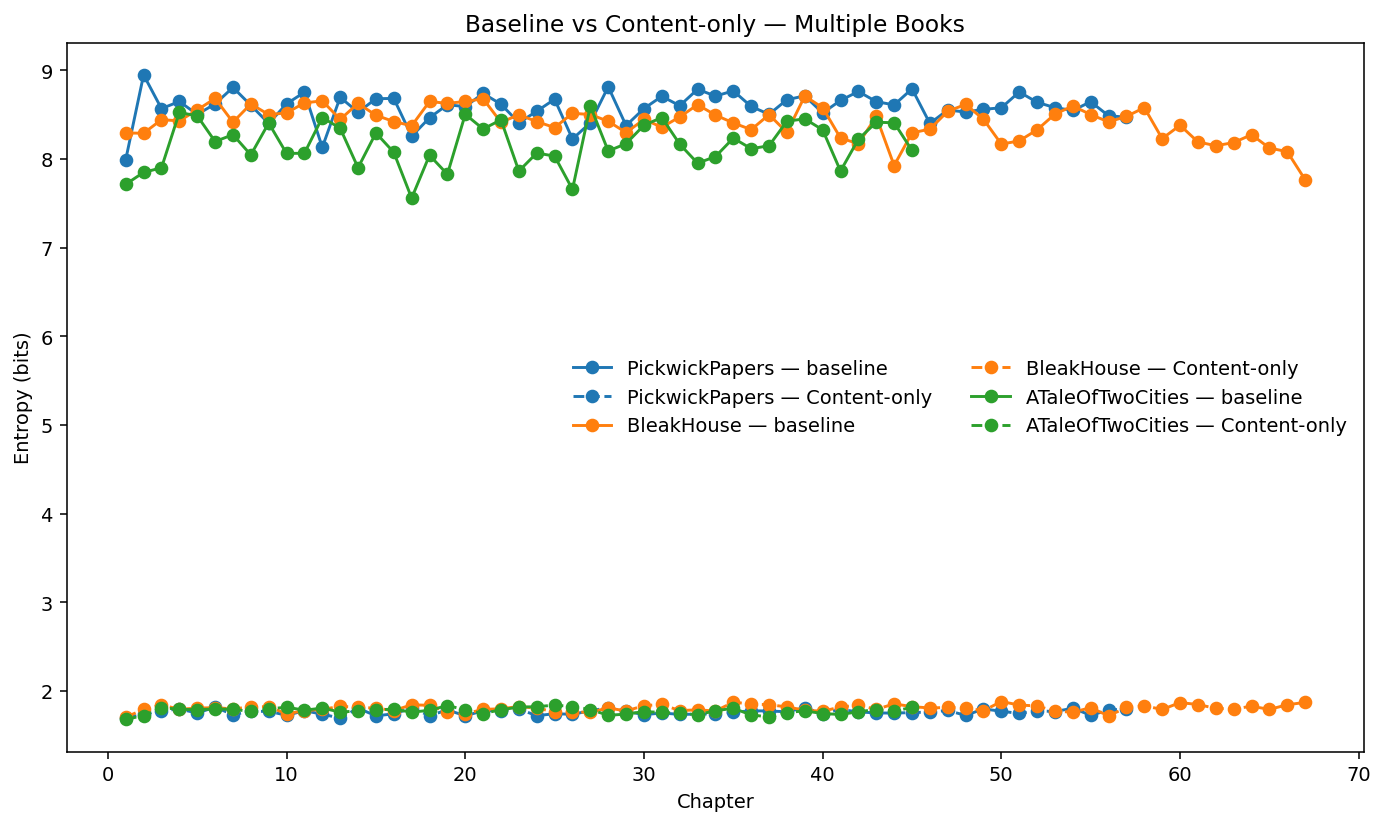

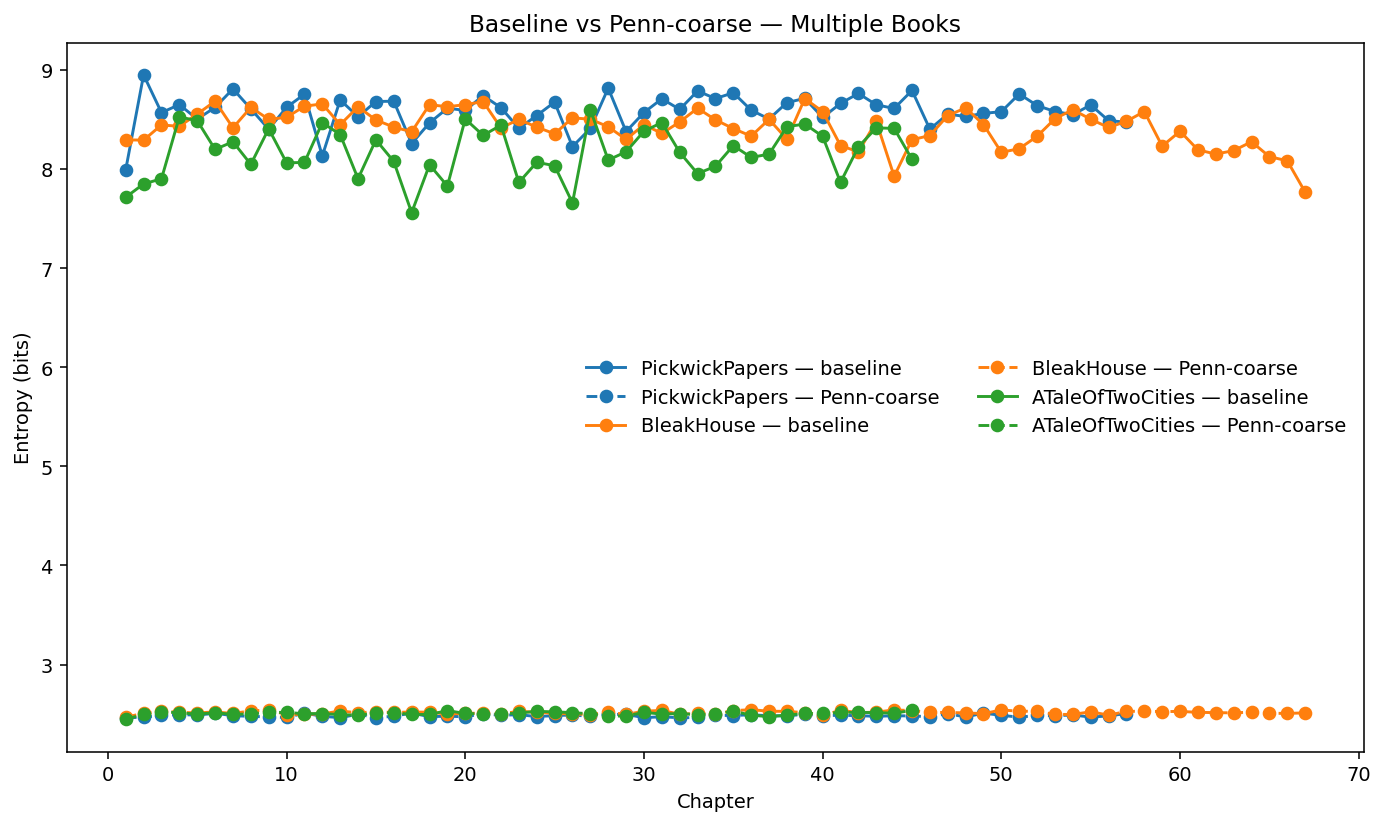

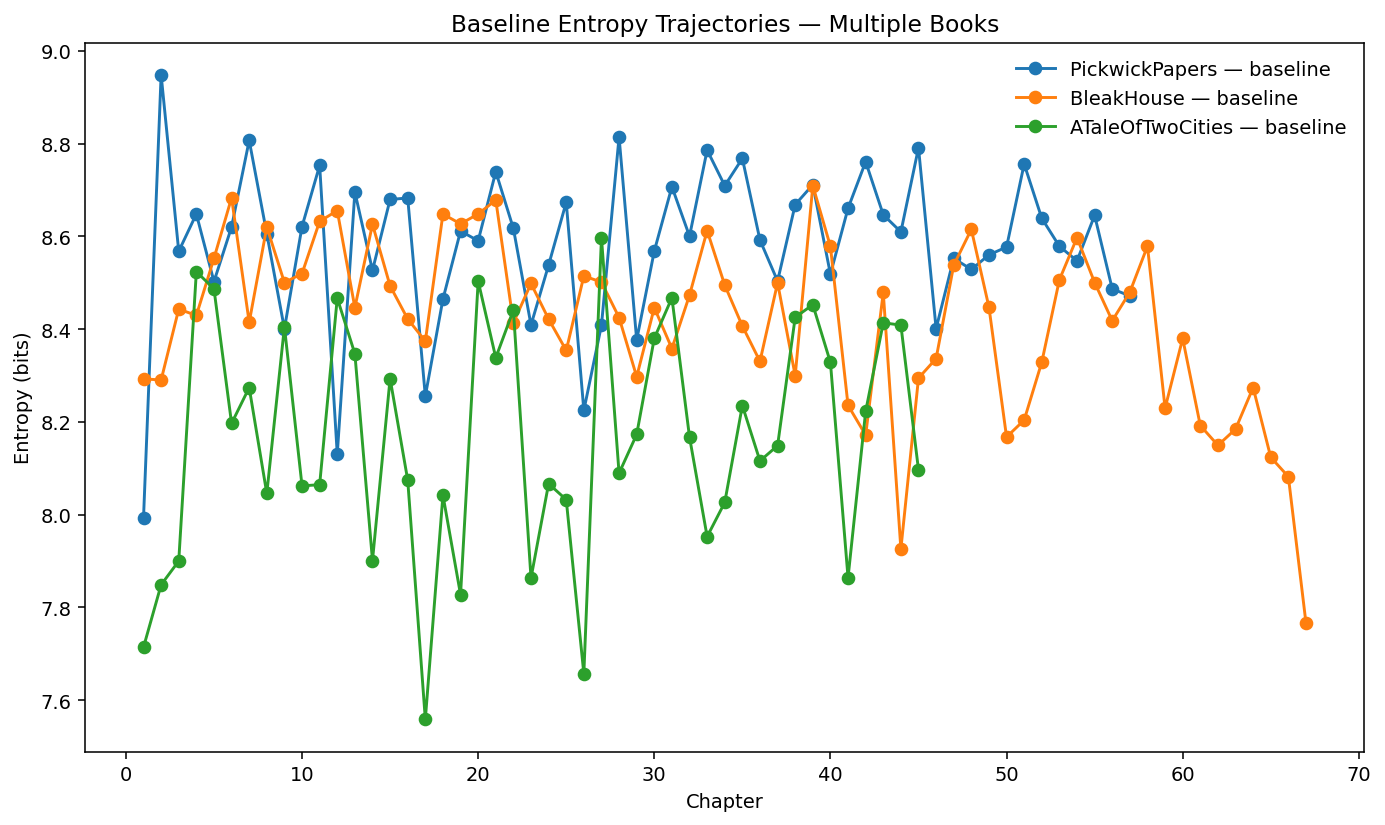

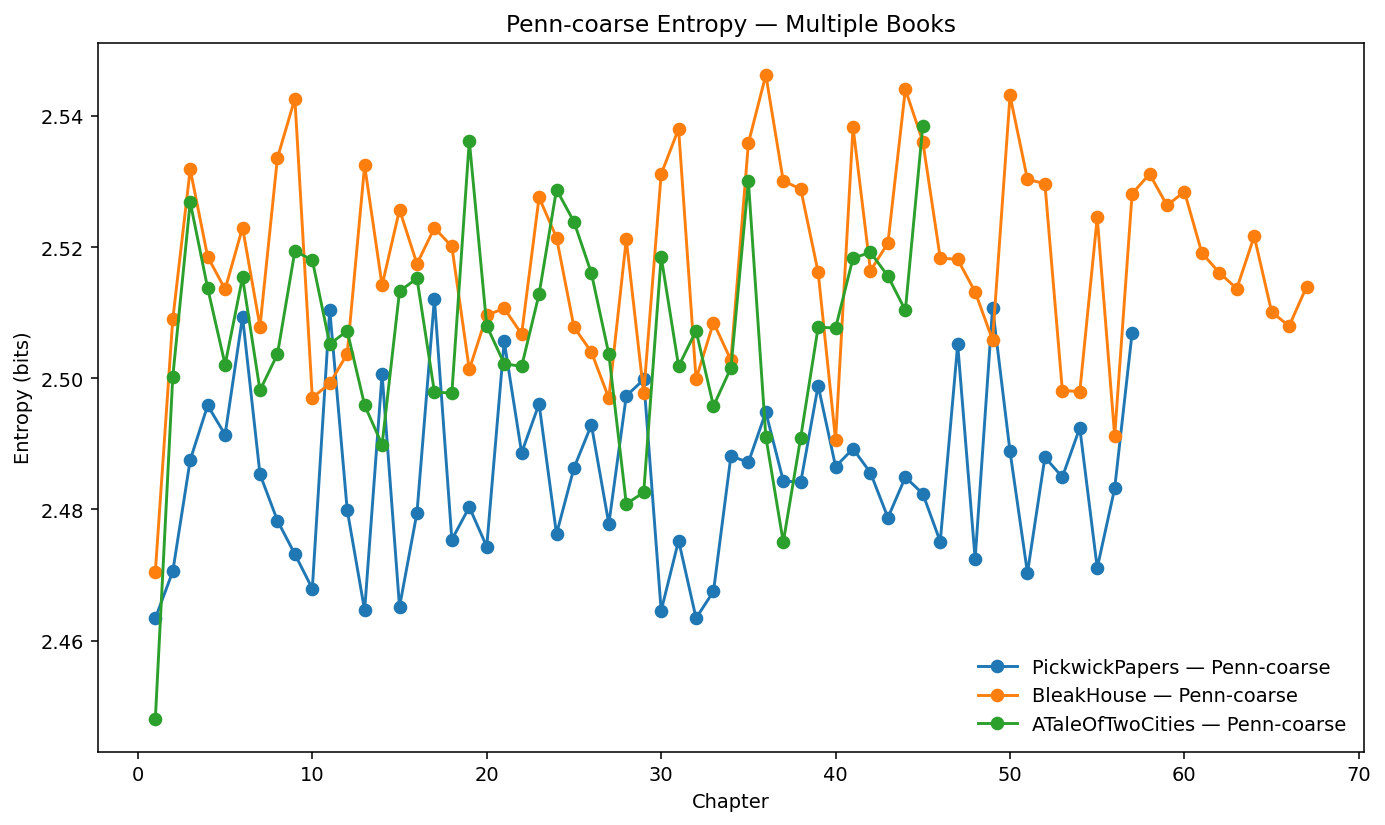

In [13]:
# Part 3.3 - Further entropy graphs to use for report

def _pick_chapter_col(df, chapter_col):
    """ Helper to automatically pick the x-axis column for chapters."""
    if chapter_col is not None:
        return chapter_col
    if "chapter_index" in df.columns:
        return "chapter_index"
    if "chapter" in df.columns:
        return "chapter"
    raise ValueError("No chapter column found. Provide 'chapter_col' or add 'chapter_index'/'chapter'.")

def plot_multi_book_lines(
    df,
    books,
    ycols,                     # List of series columns to plot (e.g., ["word_entropy_bits"] or ["word_entropy_bits", "word_entropy_bits_univ_content"])
    labels=None,               # Legend labels for each ycol (same length as ycols). Defaults to ycols themselves.
    linestyles=None,           # Linestyles for each ycol (same length as ycols). Defaults to all solid lines.
    chapter_col=None,          # X-axis column for chapter number/index (auto-picked if None)
    id_col=None,               # Column for book ID (auto-picked if None: tries 'book_id', then 'novel')
    use_roll=True,              # If True, and a "{col}_roll" exists, uses that instead of the raw column
    figsize=(10, 6),            # Size of the figure
    title="",                   # Plot title
    legend_ncol=2               # Number of columns in the legend
):
    """
    General-purpose multi-line plotter for comparing entropy variants across books.

    Each book gets its own color.
    Each ycol gets its own linestyle.
    Labels combine both: "<book> — <variant label>".
    """
    # Choose x-axis column (chapter index)
    chap = _pick_chapter_col(df, chapter_col)

    # Choose identifier column for book selection
    if id_col is None:
        if "book_id" in df.columns:
            id_col = "book_id"
        elif "novel" in df.columns:
            id_col = "novel"
    if id_col is None:
        raise ValueError("Need an identifier column ('book_id' or 'novel').")

    # Default values if labels/linestyles not provided
    ycols = list(ycols)
    labels = labels or ycols
    linestyles = linestyles or ["-"] * len(ycols)

    # Assign a consistent color to each book (color reused across variants for that book)
    cmap = plt.get_cmap("tab10")
    color_map = {b: cmap(i % 10) for i, b in enumerate(books)}

    # Create the figure
    plt.figure(figsize=figsize)

    for b in books:
        # Subset dataframe to this book only
        sub = df[df[id_col] == b]
        if sub.empty:
            print(f"[warn] No data for {id_col}='{b}'")
            continue

        # Sort by chapter so the lines draw in correct order
        sub = sub.sort_values(chap)

        for col, lab, ls in zip(ycols, labels, linestyles):
            # Use smoothed column if requested and available
            col_plot = f"{col}_roll" if (use_roll and f"{col}_roll" in sub.columns) else col
            if col_plot not in sub.columns:
                print(f"[warn] Column '{col_plot}' not found for {id_col}='{b}'")
                continue

            # Plot this series
            plt.plot(
                sub[chap],
                sub[col_plot],
                marker="o",
                linestyle=ls,
                color=color_map[b],
                label=f"{b} — {lab}" ) # Legend entry shows both book and variant

    # Axis labels and title
    plt.xlabel("Chapter")
    plt.ylabel("Entropy (bits)")
    plt.title(title)

    # Legend formatting
    plt.legend(frameon=False, ncol=legend_ncol)

    plt.tight_layout()
    plt.show()

def plot_multi_book_baseline_only(df, books, baseline_col="word_entropy_bits", **kwargs):
    """Wrapper to plot baseline entropy trajectories for multiple books."""
    plot_multi_book_lines(
        df=df,
        books=books,
        ycols=[baseline_col],
        labels=["baseline"],
        linestyles=["-"],
        title="Baseline Entropy Trajectories — Multiple Books",
        legend_ncol=1,  # vertical legend for clarity
        **kwargs    )

def plot_multi_book_baseline_vs_variant(df, books, baseline_col="word_entropy_bits", variant_col="word_entropy_bits_univ_content",
    variant_label="Content-only", **kwargs ):
    """Wrapper to compare baseline vs a single variant (e.g., content-only or Penn-coarse) for multiple books on one plot."""
    plot_multi_book_lines(
        df=df,
        books=books,
        ycols=[baseline_col, variant_col],
        labels=["baseline", variant_label],
        linestyles=["-", "--"],  # solid for baseline, dashed for variant
        title=f"Baseline vs {variant_label} — Multiple Books",
        legend_ncol=2,
        **kwargs    )

def plot_multi_book_penn_only(df, books, penn_col="word_entropy_bits_penn_coarse", **kwargs):
    """Wrapper for Penn-only trajectories for multiple books (single series)"""
    plot_multi_book_lines(
        df=df,
        books=books,
        ycols=[penn_col],
        labels=["Penn-coarse"],
        linestyles=["-"],
        title="Penn-coarse Entropy — Multiple Books",
        legend_ncol=1,
        **kwargs    )

# Set the example books to use
example_books = ["PickwickPapers", "BleakHouse", "ATaleOfTwoCities"]

# Baseline vs Content-only
plot_multi_book_baseline_vs_variant(chapters, books=example_books, baseline_col="word_entropy_bits", 
                                    variant_col="word_entropy_bits_univ_content", variant_label="Content-only")

# Baseline vs Penn-coarse
plot_multi_book_baseline_vs_variant(chapters, books=example_books, baseline_col="word_entropy_bits", 
                                    variant_col="word_entropy_bits_penn_coarse", variant_label="Penn-coarse")
# Baseline only
plot_multi_book_baseline_only(chapters, books=example_books, baseline_col="word_entropy_bits")

# Penn_coarse only
plot_multi_book_penn_only(chapters, books=example_books, penn_col="word_entropy_bits_penn_coarse")




VADER: Time series (novel-level)


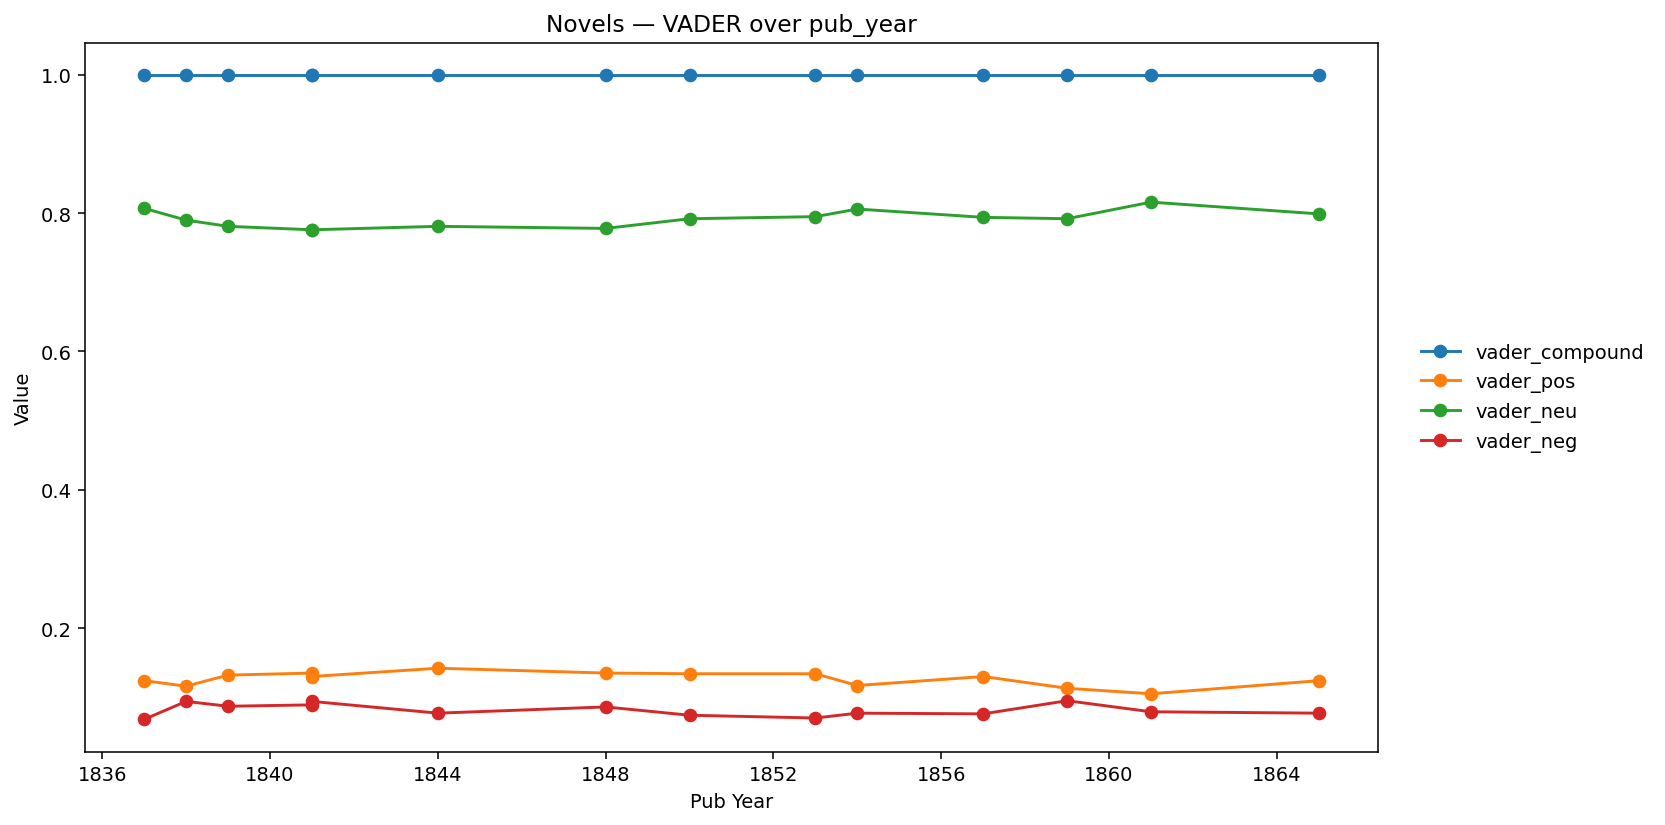


VADER: Distributions
[info] Skipping KDE for vader_compound — constant values detected.


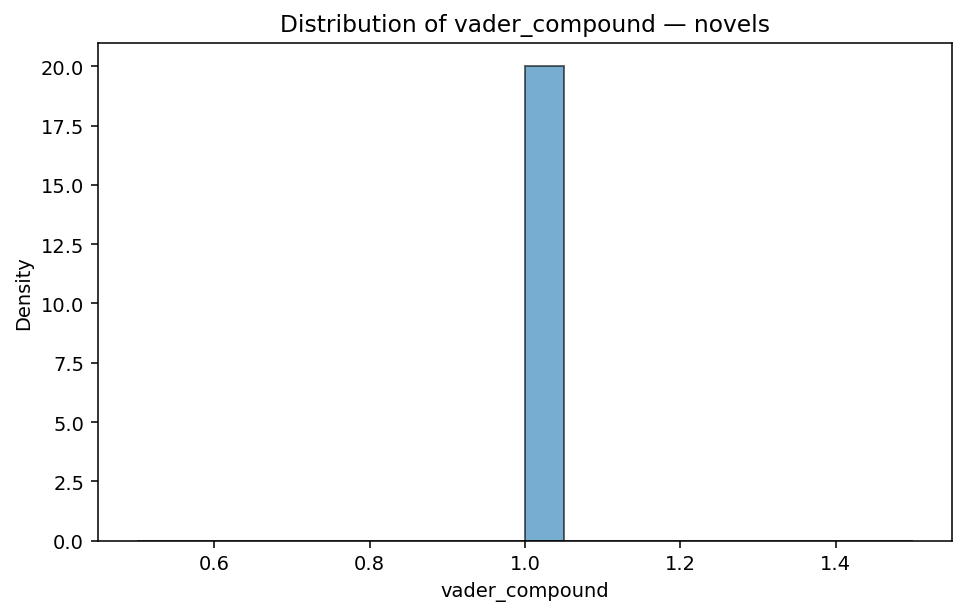

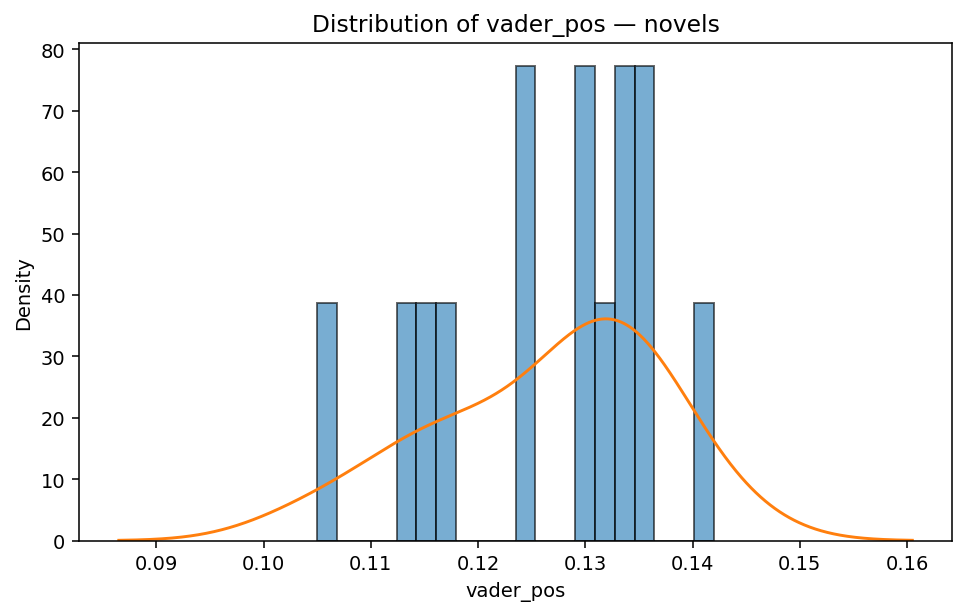

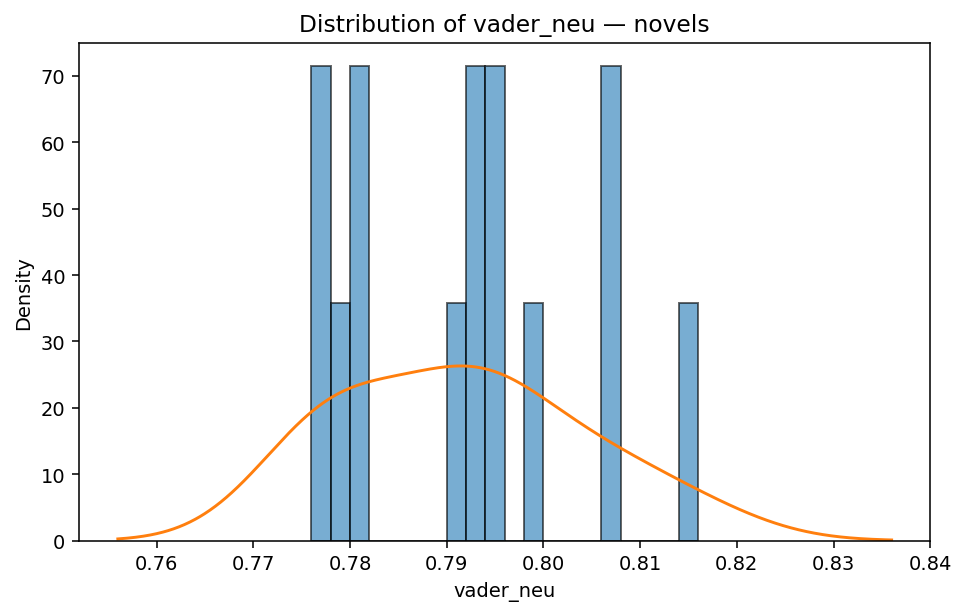

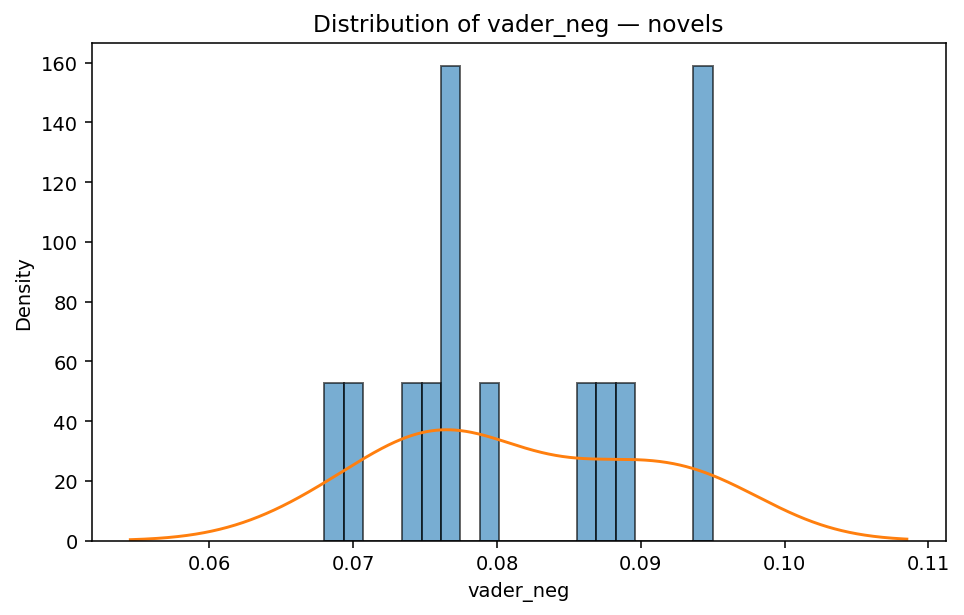

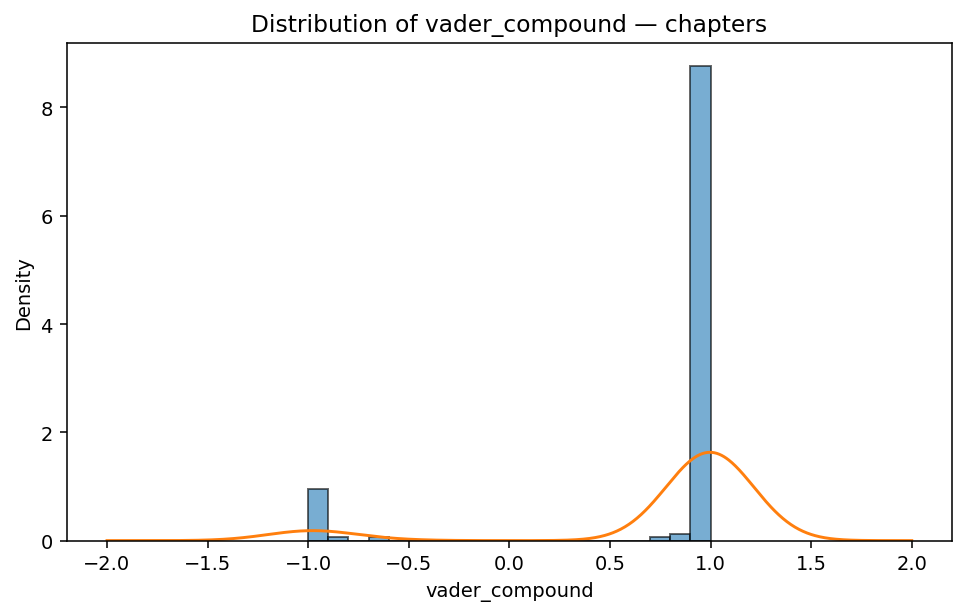

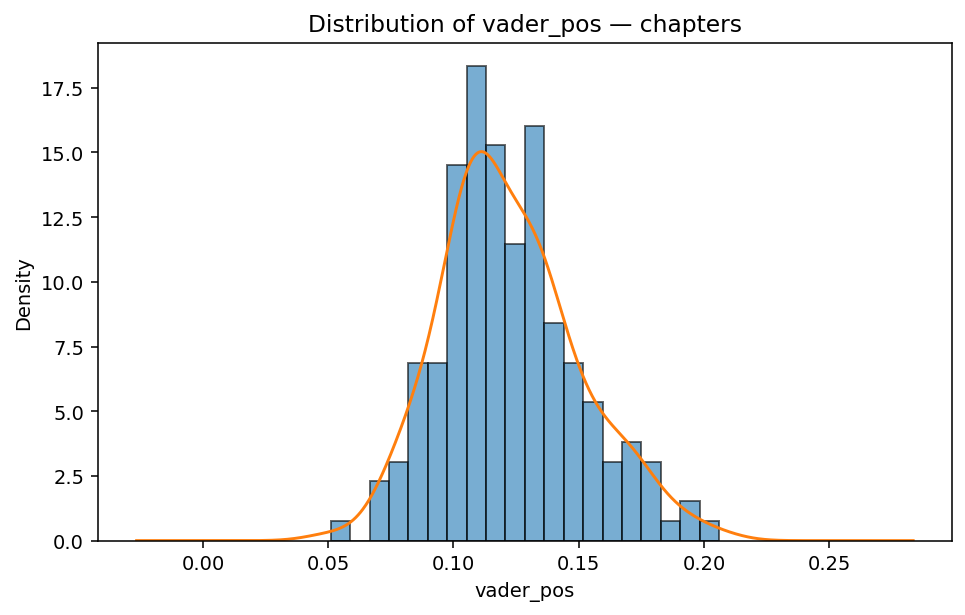

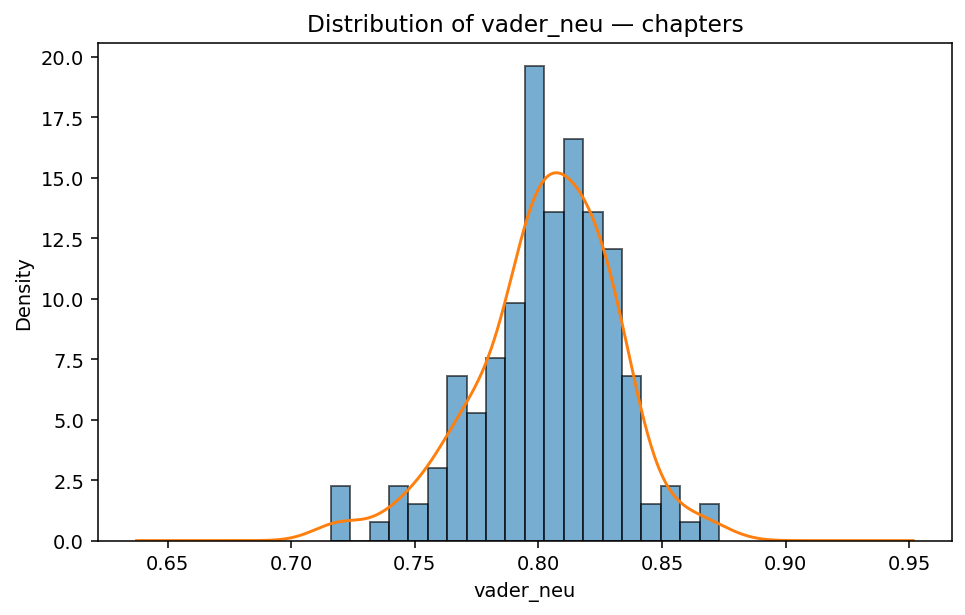

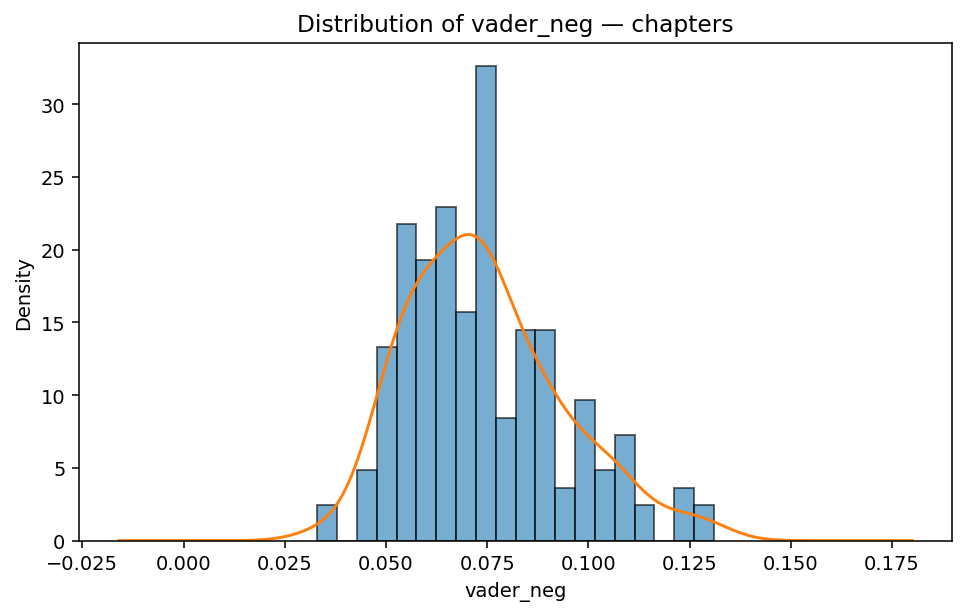


VADER: Chapter-level trajectories


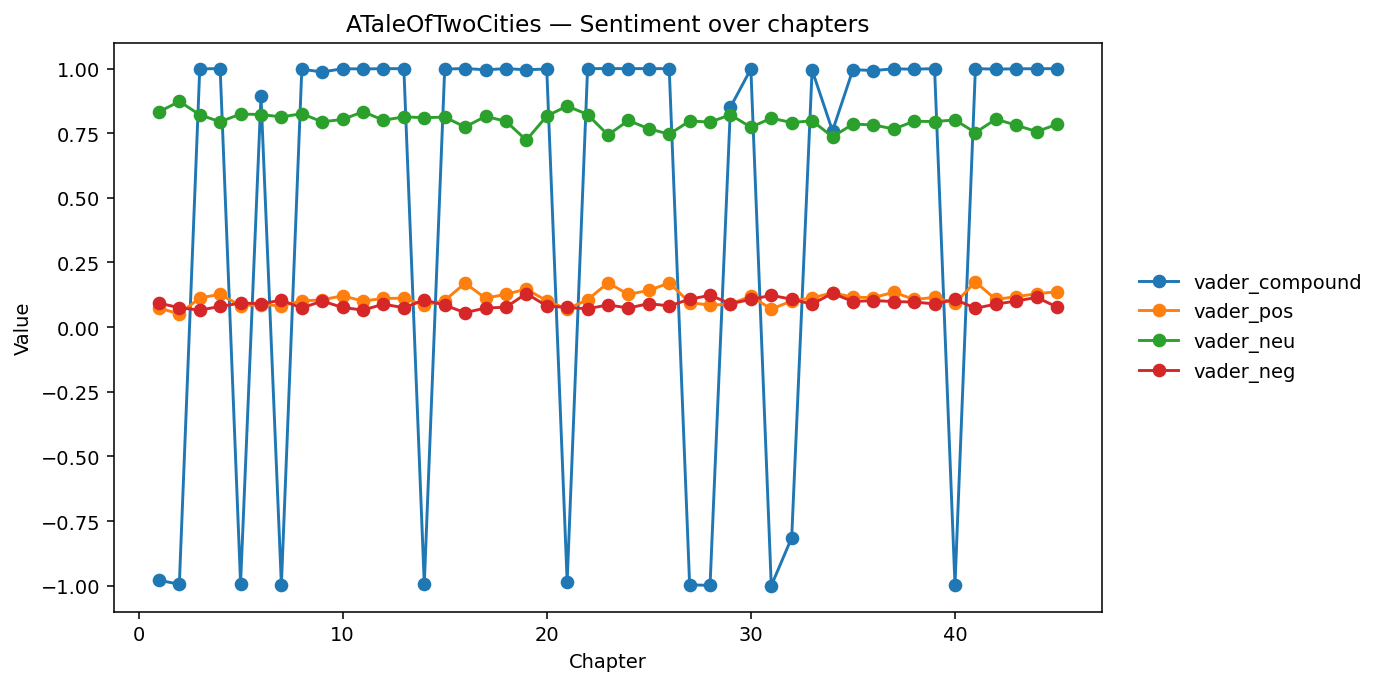

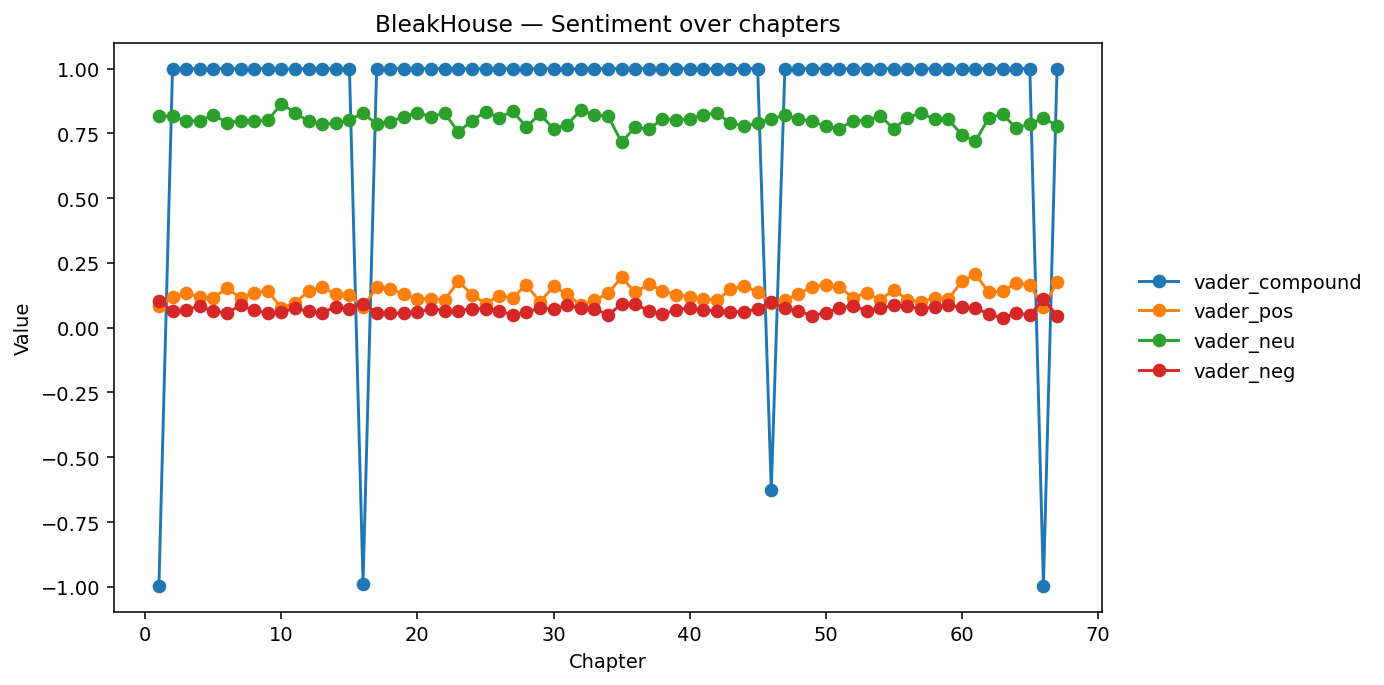

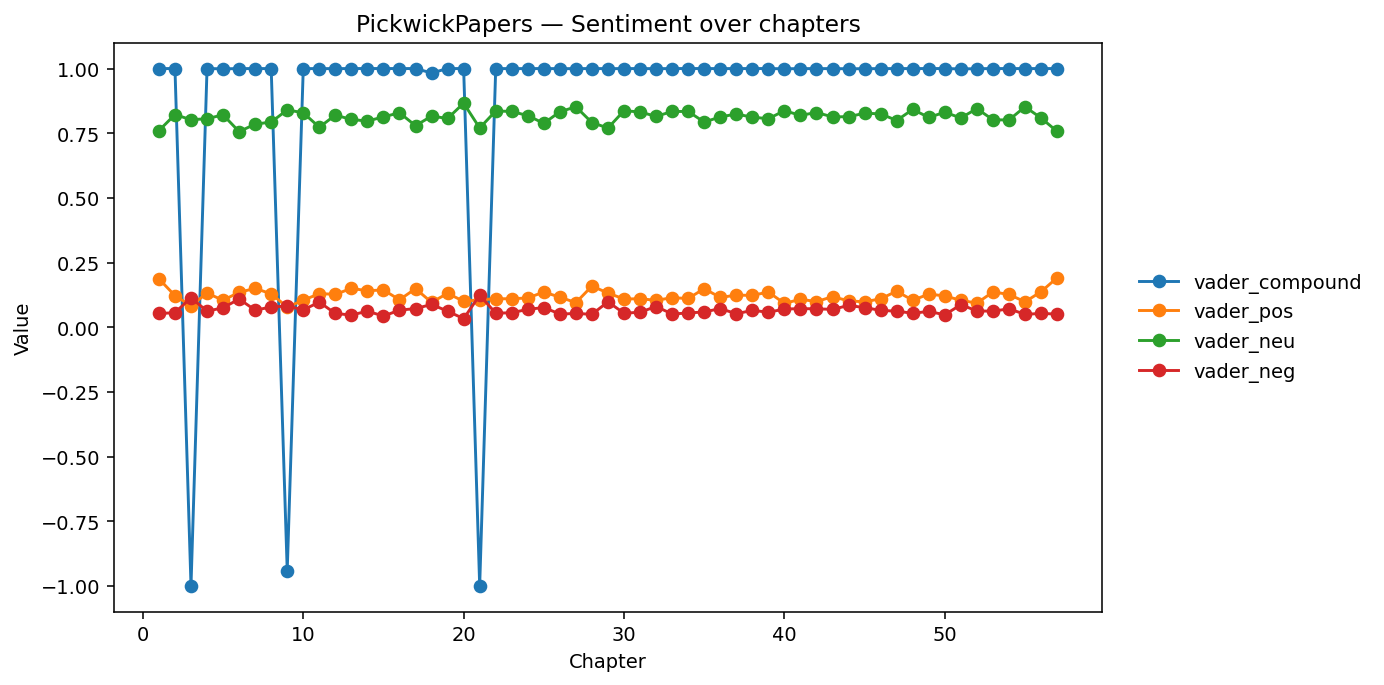


VADER: Correlations


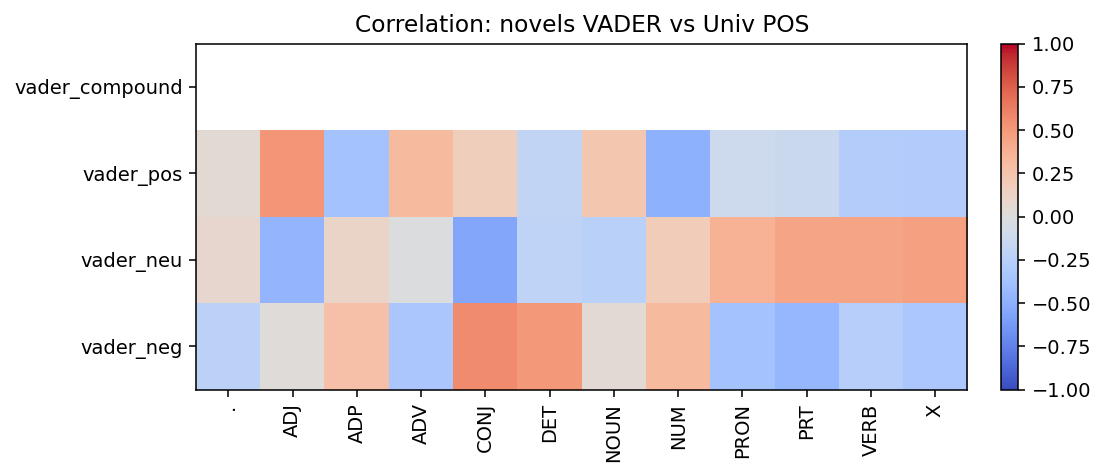

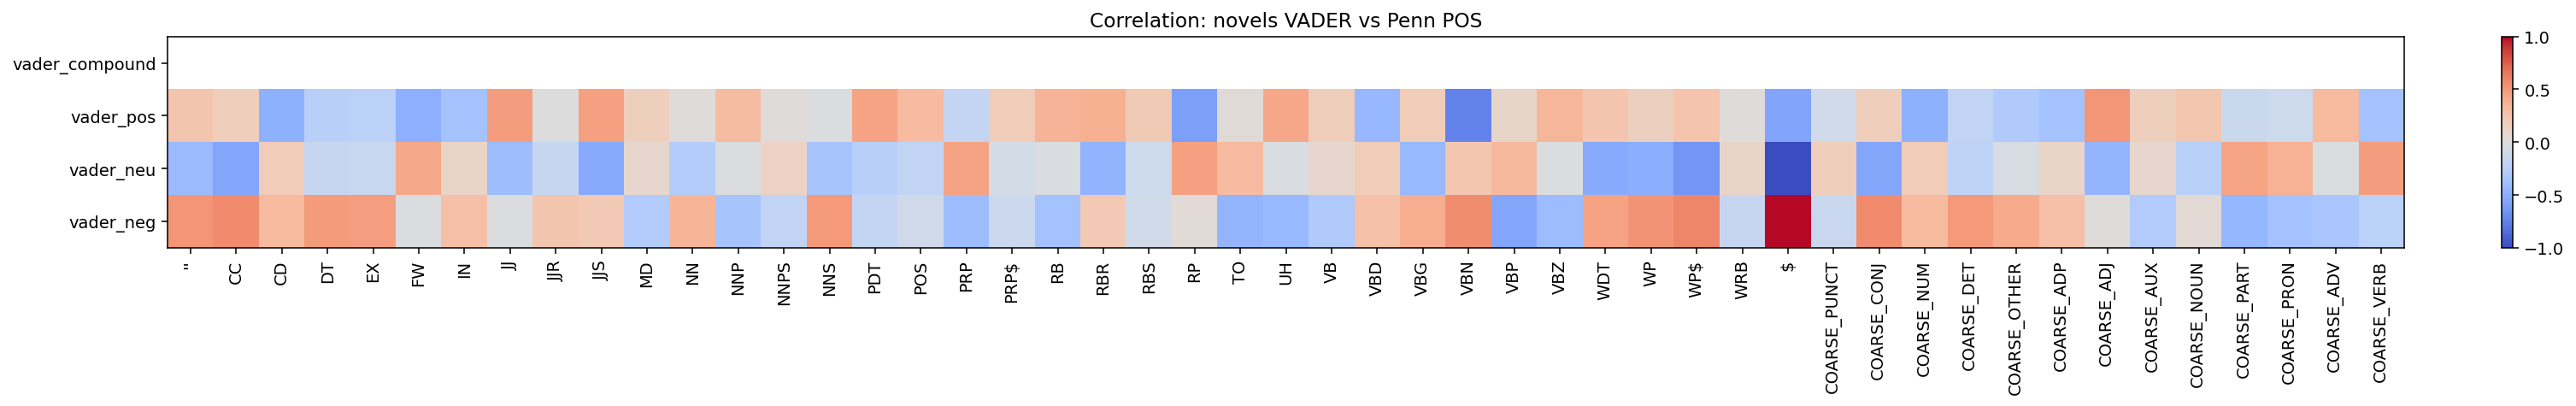

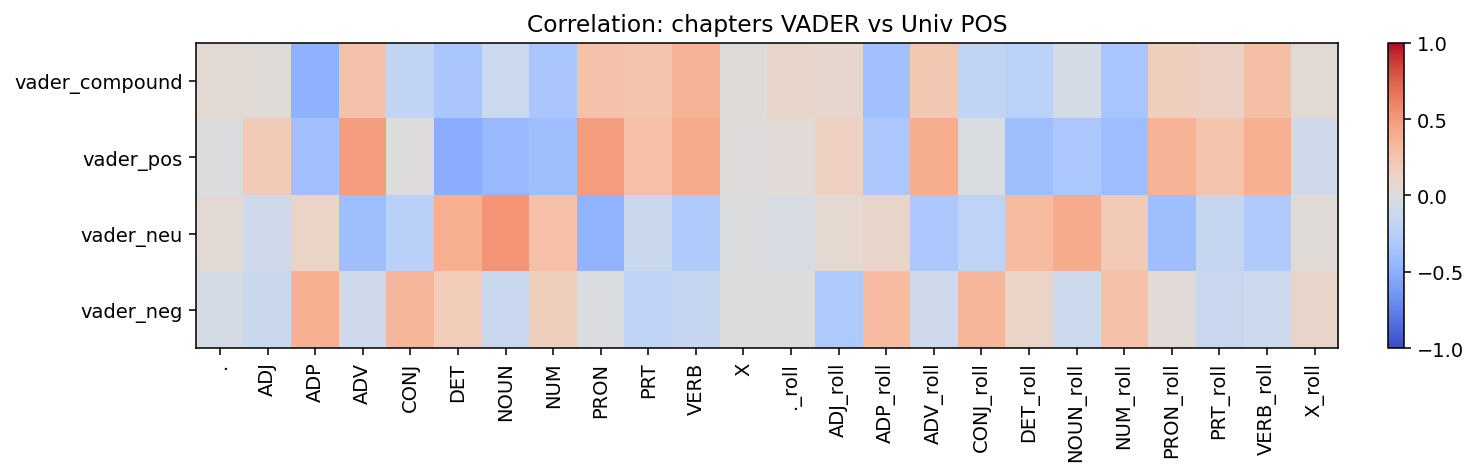

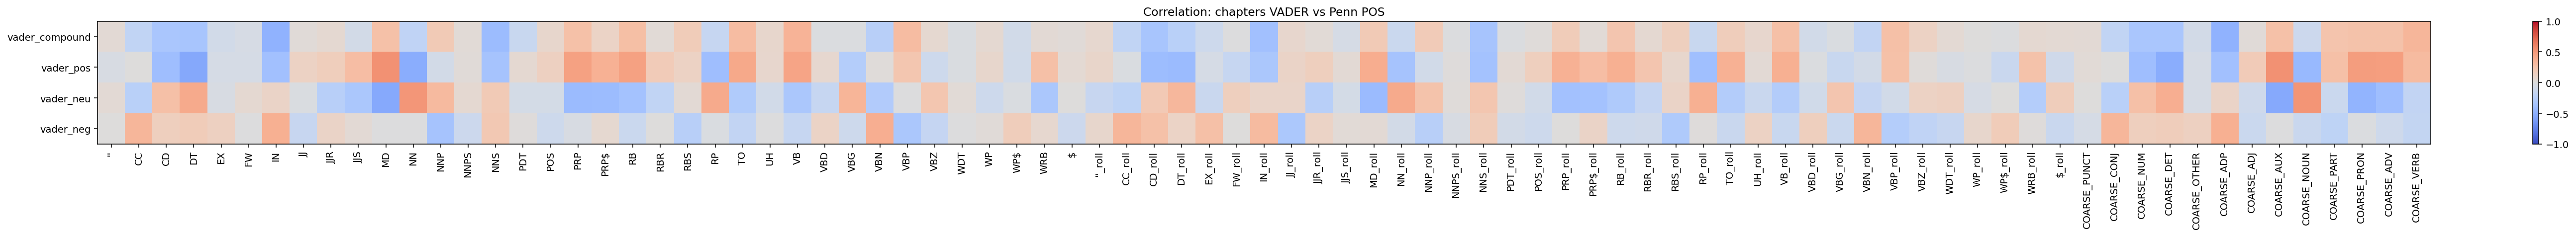

In [14]:
# PART 4 - SENTIMENT ANALYSIS

# List of variables related to sentiment analysis
VADER_VARS = ["vader_compound", "vader_pos", "vader_neu", "vader_neg"]

# Time series over Dickens' career (novel-level)
def plot_vader_time_series(novels_df, xcol="pub_year", vars_list=VADER_VARS, label="novels"):
    """ Plot VADER variables vs publication year."""
    present = [v for v in vars_list if v in novels_df.columns]
    if not present:
        print("[warn] No VADER columns present in novels_df.")
        return

    width, height = 12, max(6, 3 + 0.4*len(present))
    plt.figure(figsize=(width, height))
    x = novels_df[xcol].values

    for v in present:
        plt.plot(x, novels_df[v], marker="o", label=v)

    plt.xlabel(xcol.replace("_", " ").title())
    plt.ylabel("Value")
    plt.title(f"{label.capitalize()} — VADER over {xcol}")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    #plt.savefig(os.path.join(FIG_DIR, f"vader_timeseries_{label}.png"), dpi=150, bbox_inches="tight")
    plt.show()

# --- 2) Distributions (novel-level and chapter-level) ---
def plot_vader_distributions(df, label, vars_list=VADER_VARS):
    """Histogram + KDE (when variance > 0) for each VADER column present."""
    present = [v for v in vars_list if v in df.columns]
    if not present:
        print(f"[warn] No VADER columns for {label}.")
        return

    for v in present:
        series = df[v].dropna()
        plt.figure(figsize=(7, 4.5))
        series.plot.hist(bins=20, alpha=0.6, edgecolor="black", density=True)
        if series.var() > 0:
            series.plot.kde()
        else:
            print(f"[info] Skipping KDE for {v} — constant values detected.")
        plt.xlabel(v)
        plt.ylabel("Density")
        plt.title(f"Distribution of {v} — {label}")
        plt.tight_layout()
        #plt.savefig(os.path.join(FIG_DIR, f"dist_{v}_{label}.png"), dpi=150)
        plt.show()

# Chapter trajectories (per novel)
def plot_vader_by_chapter(chapters_df, novel_name, vars_list=VADER_VARS):
    """Plot chapter-by-chapter VADER curves for a single novel."""
    sub = chapters_df[chapters_df["novel"] == novel_name].copy()
    if sub.empty:
        print(f"[warn] Novel '{novel_name}' not found.")
        return

    present = [v for v in vars_list if v in sub.columns]
    if not present:
        print(f"[warn] No VADER columns found for chapters of '{novel_name}'.")
        return

    plt.figure(figsize=(10, max(5, 3 + 0.5*len(present))))
    x = sub["chapter"].values
    for v in present:
        plt.plot(x, sub[v], marker="o", label=v)

    plt.xlabel("Chapter")
    plt.ylabel("Value")
    plt.title(f"{novel_name} — Sentiment over chapters")
    plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    fname = f"sentiment_chapters_{novel_name.replace(' ','_')}.png"
    # plt.savefig(os.path.join(FIG_DIR, fname), dpi=150, bbox_inches="tight")
    plt.show()

# Correlation heatmaps with POS proportions (novel/chapter level)
def vader_corr_with_pos(df, tagset="univ", label="novels", vars_list=VADER_VARS):
    """Correlate VADER columns with POS proportion columns (pairwise corr to handle NaNs)."""
    present = [v for v in vars_list if v in df.columns]
    if not present:
        print(f"[warn] No VADER columns found for {label}.")
        return

    pos_cols = [c for c in df.columns if c.startswith(f"pos_{tagset}_prop_")]
    if not pos_cols:
        print(f"[warn] No POS proportion columns found for tagset '{tagset}'.")
        return

    corr_full = df[present + pos_cols].corr()
    corr = corr_full.loc[present, pos_cols]

    plt.figure(figsize=(max(8, len(pos_cols)*0.45), max(3.5, len(present)*0.6)))
    im = plt.imshow(corr, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(pos_cols)), [c.replace(f"pos_{tagset}_prop_", "") for c in pos_cols], rotation=90)
    plt.yticks(range(len(present)), present)
    plt.title(f"Correlation: {label} VADER vs {tagset.capitalize()} POS")
    plt.tight_layout()
    # plt.savefig(os.path.join(FIG_DIR, f"corr_vader_vs_{tagset}_{label}.png"), dpi=150)
    plt.show()

# Run VADER views 
print("\nVADER: Time series (novel-level)")
plot_vader_time_series(novels, xcol="pub_year", vars_list=VADER_VARS, label="novels")

print("\nVADER: Distributions")
plot_vader_distributions(novels, "novels", vars_list=VADER_VARS)
plot_vader_distributions(chapters, "chapters", vars_list=VADER_VARS)

print("\nVADER: Chapter-level trajectories")
for nv in chapters["novel"].unique():
    plot_vader_by_chapter(chapters, nv, vars_list=VADER_VARS)

print("\nVADER: Correlations")
vader_corr_with_pos(novels, tagset="univ", label="novels", vars_list=VADER_VARS)
vader_corr_with_pos(novels, tagset="penn", label="novels", vars_list=VADER_VARS)
vader_corr_with_pos(chapters, tagset="univ", label="chapters", vars_list=VADER_VARS)
vader_corr_with_pos(chapters, tagset="penn", label="chapters", vars_list=VADER_VARS)
